<a href="https://colab.research.google.com/github/tu55287/FSP-prototypes/blob/main/Prototype_Learning_for_Frame_Semantic_Parsing_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prototype Learning for Frame Semantic Parsing with Transformers**

This notebook contains the full implementation of experiments described in the master‚Äôs thesis ‚ÄúPrototype Learning for Frame Semantic Parsing with Transformers‚Äù by Chao Yu (KU Leuven, 2025).

In [3]:


# @title üß† encode_target_spans_batch encode_sentences_batch
def encode_target_spans_batch(sentences, target_spans_list, tokenizer, model,
                             batch_size=32, max_length=512, train_mode=False, verbose=False):
    """
    Batch encoding of target spans, using precise positioning + mean pooling, optimised for GPU performance
    """

    model.eval()
    device = next(model.parameters()).device  # Check device only once
    all_embeddings = []

    if verbose:
        print(f"üîÑ Batch encoding {len(sentences)} target spans (batch_size={batch_size})...")

    # Decide whether to show progress bar based on verbose parameter
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding target spans", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    # Check whether tokenizer supports offset_mapping
    supports_offset_mapping = hasattr(tokenizer, 'is_fast') and tokenizer.is_fast

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]
        batch_spans = target_spans_list[i:i + batch_size]

        # Preprocess spans, normalising them into position coordinates
        processed_spans = []
        for j, spans in enumerate(batch_spans):
            sentence = batch_sentences[j]

            # Handle different span formats
            if isinstance(spans, str):
                start = sentence.find(spans.strip())
                if start != -1:
                    processed_spans.append([(start, start + len(spans.strip()))])
                else:
                    processed_spans.append([])
            elif isinstance(spans, list):
                if spans and isinstance(spans[0], str):
                    positions = []
                    for span_text in spans:
                        start = sentence.find(span_text.strip())
                        if start != -1:
                            positions.append((start, start + len(span_text.strip())))
                    processed_spans.append(positions)
                else:
                    normalized = []
                    for span in spans:
                        if isinstance(span, (list, tuple)) and len(span) == 2:
                            normalized.append((int(span[0]), int(span[1])))
                    processed_spans.append(normalized)
            else:
                processed_spans.append([])

        # Batch tokenisation ‚Äì decide whether to use offset_mapping based on support
        if supports_offset_mapping:
            try:
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_offsets_mapping=True,
                    return_attention_mask=True
                )
                use_offset_mapping = True
            except:
                # Fallback if offset mapping fails
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_attention_mask=True
                )
                use_offset_mapping = False
        else:
            encoding = tokenizer(
                batch_sentences,
                return_tensors='pt',
                truncation=True,
                max_length=max_length,
                padding=True,
                return_attention_mask=True
            )
            use_offset_mapping = False

        # Move directly to device to avoid repeated conversion
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        if use_offset_mapping:
            offset_mappings = encoding['offset_mapping']  # Keep on CPU

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state

            batch_embeddings = []

            for j in range(len(batch_sentences)):
                target_spans = processed_spans[j]

                if use_offset_mapping:
                    # Accurate matching via offset mapping
                    offset_mapping = offset_mappings[j]
                    selected_indices = []
                    for start_char, end_char in target_spans:
                        for token_idx, (token_start, token_end) in enumerate(offset_mapping):
                            if token_start == 0 and token_end == 0:
                                continue
                            if token_start < end_char and token_end > start_char:
                                selected_indices.append(token_idx)

                    selected_indices = list(set(selected_indices))
                else:
                    # Fallback: approximate method based on linear mapping
                    selected_indices = []
                    if target_spans:
                        sentence_len = len(batch_sentences[j])
                        seq_len = attention_mask[j].sum().item() - 2  # Subtract [CLS] and [SEP]

                        for start_char, end_char in target_spans:
                            start_token = int((start_char / sentence_len) * seq_len) + 1
                            end_token = int((end_char / sentence_len) * seq_len) + 1
                            start_token = max(1, min(start_token, seq_len))
                            end_token = max(start_token, min(end_token, seq_len))
                            selected_indices.extend(range(start_token, end_token + 1))

                        selected_indices = list(set(selected_indices))

                if selected_indices:
                    selected_hidden = last_hidden[j, selected_indices, :]
                    embedding = selected_hidden.mean(dim=0)
                else:
                    valid_mask = attention_mask[j].bool()
                    valid_hidden = last_hidden[j][valid_mask]
                    embedding = valid_hidden[1:-1].mean(dim=0) if len(valid_hidden) > 2 else valid_hidden.mean(dim=0)

                batch_embeddings.append(embedding)

            # Stack on GPU and convert at once
            batch_embeddings_tensor = torch.stack(batch_embeddings)
            all_embeddings.append(batch_embeddings_tensor)

    # Concatenate and return
    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


def encode_sentences_batch(sentences, tokenizer, model, batch_size=32,
                          max_length=512, train_mode=False, verbose=False):
    """
    Batch sentence encoding function, using CLS token, optimised for GPU performance
    """
    model.eval()
    device = next(model.parameters()).device  # Check device only once
    all_embeddings = []

    if verbose:
        print(f"üîÑ Batch encoding {len(sentences)} sentences (batch_size={batch_size})...")

    # Decide whether to show progress bar based on verbose parameter
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding sentences", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]

        # Batch tokenisation
        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding=True,
            return_attention_mask=True
        )

        # Move directly to device using non_blocking optimisation
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings)

    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


In [4]:
# @title üß† extract_frame_prototypes

def extract_frame_prototypes(model, tokenizer, df, batch_size=64):
    """
    Extract frame prototypes using mean pooling

    Args:
        model: Trained Transformer model
        tokenizer: HuggingFace tokenizer
        df: DataFrame containing training samples
        batch_size: Batch size

    Returns:
        dict: Mapping from frame name to prototype vector
    """

    model.eval()
    frame_prototypes = {}
    frame_groups = df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="Extracting frame prototypes"):
        sentences = frame_df['sentence'].tolist()
        target_spans_list = frame_df['target_spans'].tolist()

        # Batch encode target spans
        target_embeddings = encode_target_spans_batch(
            sentences, target_spans_list, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )

        # Compute mean prototype
        prototype = target_embeddings.mean(dim=0).cpu().numpy()
        frame_prototypes[frame_name] = prototype

    print(f"‚úÖ Extracted {len(frame_prototypes)} frame prototypes")
    return frame_prototypes



In [5]:
# @title üß† evaluate_target_known evaluate_target_unknown

def evaluate_target_known(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    Target-known evaluation: given the target span, evaluate frame classification accuracy

    Args:
        model: Trained model
        tokenizer: HuggingFace tokenizer
        test_df: Test dataset
        frame_prototypes: Precomputed frame prototype dictionary (optional)
        train_df: Training dataset (used to compute prototypes on the fly if not provided)
        top_n: Number of top predictions to consider
        batch_size: Batch size

    Returns:
        dict: Evaluation results dictionary
    """

    model.eval()

    # Get or compute frame prototypes
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("Must provide either frame_prototypes or train_df")
        print("üîÑ Computing frame prototypes on the fly...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("üìä Using existing frame prototypes")

    # Prepare prototype matrix
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ Evaluating {len(test_df)} test samples, {len(prototype_frames)} frame prototypes")

    # Batch encode target spans of the test data
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # Filter out invalid spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù Valid test samples: {len(valid_indices)}/{len(test_df)}")

    # Batch encode target embeddings
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # Evaluation results
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Get top-N predictions
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # Sort in descending order
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # Compute various metrics
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # Print results
    print(f"\n‚úÖ Target-known evaluation results (Cosine similarity)")
    print(f"Top-1 accuracy: {results['top1_accuracy']:.4f}")
    print(f"Top-3 accuracy: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Processed samples: {results['valid_samples']}/{len(test_df)}")

    return results





def _generate_candidate_spans(sentence, tokenizer, strategy='stopwords'):
    """ÁîüÊàêÂÄôÈÄâtarget spans"""

    if strategy == 'stopwords':
        # ÊîπËøõÁöÑÂÅúÁî®ËØçÊñπÊ≥ïÔºöÂè™ËøáÊª§ÁúüÊ≠£ÁöÑÂäüËÉΩËØçÔºå‰øùÁïôÂèØËÉΩÁöÑtarget words
        # ÂéªÊéâdo, go, runÁ≠âÂèØËÉΩÁöÑÂä®ËØçtarget words
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
            'before', 'after', 'above', 'below', 'between', 'among', 'under', 'over',
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'shall',
            'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we',
            'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her',
            'its', 'our', 'their'
        }

        encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        offsets = encoding["offset_mapping"]
        spans = []

        for start, end in offsets:
            if start == end:
                continue
            token = sentence[start:end].strip()

            # ÂÖÅËÆ∏ÂçïÂ≠óÊØçÔºàÂ¶Ç 'I', 'a'‰Ωú‰∏∫target wordÔºâÂíå‰ªª‰ΩïÈùûÂÅúÁî®ËØç
            if (token.lower() not in stop_words and
                any(c.isalnum() for c in token) and  # ÂåÖÂê´Â≠óÊØçÊàñÊï∞Â≠ó
                not all(c in '.,!?;:"()[]{}' for c in token)):  # ‰∏çÊòØÁ∫ØÊ†áÁÇπ
                spans.append((start, end))
        return spans

    elif strategy == 'pos_filter':
        # Âü∫‰∫éËØçÊÄßÊ†áÊ≥®ÔºàÈúÄË¶ÅÂÆâË£ÖspacyÔºâ
        try:
            import spacy
            nlp = spacy.load("en_core_web_sm")
            doc = nlp(sentence)

            spans = []
            for token in doc:
                # ‰øùÁïôÂêçËØç„ÄÅÂä®ËØç„ÄÅÂΩ¢ÂÆπËØç„ÄÅÂâØËØçÔºåÂÖÅËÆ∏ÂçïÂ≠óÊØçËØç
                if (token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and
                    not token.is_stop):  # ÂéªÊéâÈïøÂ∫¶ÈôêÂà∂
                    spans.append((token.idx, token.idx + len(token.text)))
            return spans

        except ImportError:
            print("‚ö†Ô∏è spacyÊú™ÂÆâË£ÖÔºåÂõûÈÄÄÂà∞stopwordsÊñπÊ≥ï")
            return _generate_candidate_spans(sentence, tokenizer, 'stopwords')

    else:
        # ÈªòËÆ§ÂõûÈÄÄÂà∞stopwords
        return _generate_candidate_spans(sentence, tokenizer, 'stopwords')


def _spans_overlap(span1, span2):
    """Ê£ÄÊü•‰∏§‰∏™spanÊòØÂê¶ÈáçÂè†"""
    return span1[1] > span2[0] and span1[0] < span2[1]


In [6]:
# @title ‚öôÔ∏è Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from tqdm.auto import tqdm
import random
import nltk
from sklearn.cluster import KMeans, AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pickle
import os
import warnings
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import json
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
import shutil
from datetime import datetime
from collections import Counter
from matplotlib.patches import FancyArrowPatch
from nltk.corpus import framenet as fn
import pprint
from datetime import datetime, timezone, timedelta
from google.colab import drive
import copy
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os, pickle
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import framenet as fn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import re


In [7]:
# @title ‚öôÔ∏è Environment Setup: Download FrameNet, Enable GPU, Set Seed

"""
Prototype Learning for Frame Semantic Parsing with Transformers

"""
print("Downloading all required NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

# Download FrameNet data (if not already available)
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn

# Set device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====== Reproducibility: Set Random Seed ======

def set_seed(seed=42):
    """
    Set random seed for reproducibility across Python, NumPy, PyTorch, CuDNN, and OS hash.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)     # For hash() stability
    random.seed(seed)                            # Python RNG
    np.random.seed(seed)                         # NumPy RNG
    torch.manual_seed(seed)                      # PyTorch CPU
    torch.cuda.manual_seed(seed)                 # Single-GPU
    torch.cuda.manual_seed_all(seed)             # Multi-GPU
    torch.backends.cudnn.deterministic = True    # CuDNN deterministic
    torch.backends.cudnn.benchmark = False       # Disable CuDNN autotune

# Call early in the script
set_seed(42)

# Mount Google Drive to /content/drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Unzipping corpora/framenet_v17.zip.


Using device: cuda
Mounted at /content/drive


In [ ]:
import os
import pickle

# ËÆæÁΩÆË∑ØÂæÑÔºà‰Ω†‰πãÂâç‰øùÂ≠òÁöÑ‰ΩçÁΩÆÔºâ
load_dir = "/content/drive/MyDrive/more50/framenet_data"

# Âä†ËΩΩ‰∏ªÊï∞ÊçÆ DataFrame
with open(os.path.join(load_dir, "framenet_df.pkl"), "rb") as f:
    framenet_df = pickle.load(f)

# Âä†ËΩΩ frame ÂÆö‰πâ
with open(os.path.join(load_dir, "frame_definitions.pkl"), "rb") as f:
    frame_definitions = pickle.load(f)

# Âä†ËΩΩ frame ËØ≠‰πâÂÖ≥Á≥ª
with open(os.path.join(load_dir, "frame_relations.pkl"), "rb") as f:
    frame_relations = pickle.load(f)

print("‚úÖ FrameNet Êï∞ÊçÆÂä†ËΩΩÂÆåÊØï")
print(f"üìÑ Total exemplars: {len(framenet_df)}")
print(f"üß† Unique frames: {framenet_df['frame_name'].nunique()}")
print(f"üìö Sample columns: {list(framenet_df.columns)}")


‚úÖ FrameNet Êï∞ÊçÆÂä†ËΩΩÂÆåÊØï
üìÑ Total exemplars: 200750
üß† Unique frames: 1014
üìö Sample columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']


In [8]:
# @title üì¶ Extract FrameNet Data

"""
This module extracts structured data from FrameNet 1.7, including both semantic frame exemplars
and the inter-frame graph structure. It performs the following steps:

1. Constructs a directed frame-to-frame graph from all definable FrameNet relations,
   using role-specific directionality and edge labels for each relation type.

2. Iterates over all exemplars to extract sentence-level annotations, including:
   - Target word spans
   - Frame names and definitions
   - Lexical units (LUs) and LU definitions
   - Frame elements and their textual spans

3. Aggregates the extracted information into a structured DataFrame, filters by a per-frame limit,
   and saves both the data and metadata (frame definitions and frame relations) for future use.
"""

# ========== Frame-to-Frame Relation Definitions ==========
RELATION_FIELDS = {
    "Inheritance": ("Parent", "Child"),
    "Using": ("Parent", "Child"),
    "Subframe": ("Complex", "Component"),
    "Perspective_on": ("Neutral", "Perspectivized"),
    "Precedes": ("Earlier", "Later"),
    "Causative_of": ("Causative", "Inchoative/state"),
    "Inchoative_of": ("Inchoative", "Stative"),
    "ReFraming_Mapping": ("Source", "Target"),
    "Metaphor": ("Source", "Target"),
    "See_also": ("MainEntry", "ReferringEntry")
}

RELATION_LABELS = {
    "Inheritance": ("Is Inherited by", "Inherits from"),
    "Using": ("Is Used by", "Uses"),
    "Subframe": ("Has Subframe(s)", "Subframe of"),
    "Perspective_on": ("Perspective on", "Is Perspectivized in"),
    "Precedes": ("Precedes", "Is Preceded by"),
    "Causative_of": ("Is Causative of", "Is Inchoative of"),
    "Inchoative_of": ("Is Inchoative of", "Is Causative of"),
    "ReFraming_Mapping": ("Reframes", "Is Reframed by"),
    "Metaphor": ("Metaphor: Source", "Metaphor: Target"),
    "See_also": ("See also", "See also")
}



FRAMENET_RELATION_TYPES = [
    'Inheritance', 'Using', 'See_also', 'Perspective_on', 'ReFraming_Mapping',
    'Causative_of', 'Subframe', 'Precedes', 'Inchoative_of', 'Metaphor', 'Unrelated'
]



REVERSE_RELATIONS = {
    'Parent': 'Child',
    'Child': 'Parent',
    'Uses': 'Used_by',
    'Used_by': 'Uses',
    'Perspective_on': 'Perspectivised_by',
    'Perspectivised_by': 'Perspective_on',
    'Includes_subframe': 'Subframe_of',
    'Precedes': 'Follows',
    'Follows': 'Precedes',
    'Initiates': 'Initiated_by',
    'Initiated_by': 'Initiates',
    'Causes': 'Caused_by',
    'Caused_by': 'Causes',
    'See_also': 'See_also'
}


# ========== Main Extraction Function ==========
def extract_framenet_data(max_per_frame=50, save_path="framenet_data.pkl"):
    print("Extracting FrameNet data...")
    exemplar_data = []
    frame_definitions = {}
    frame_relations = defaultdict(list)
    skipped = 0

    # Step 1: Extract frame definitions and frame-frame relations
    for frame in tqdm(fn.frames(), desc="Extracting frame definitions and relations"):
        frame_name = frame.name
        frame_definitions[frame_name] = frame.definition

        for relation in frame.frameRelations:
            try:
                rel_type = relation.type.name
                if rel_type not in RELATION_FIELDS:
                    continue
                source_field, target_field = RELATION_FIELDS[rel_type]
                label_out, label_in = RELATION_LABELS.get(rel_type, (rel_type, rel_type))
                source = getattr(relation, source_field, None)
                target = getattr(relation, target_field, None)
                if not source or not target:
                    continue

                if hasattr(source, "name") and source.name == frame_name:
                    frame_relations[frame_name].append((target.name, rel_type, "out", label_out))
                elif hasattr(target, "name") and target.name == frame_name:
                    frame_relations[frame_name].append((source.name, rel_type, "in", label_in))
                elif rel_type == "See_also":
                    if hasattr(source, "name") and source.name == frame_name:
                        frame_relations[frame_name].append((target.name, rel_type, "undirected", label_out))
                    elif hasattr(target, "name") and target.name == frame_name:
                        frame_relations[frame_name].append((source.name, rel_type, "undirected", label_in))
            except Exception:
                continue

    # Step 2: Extract exemplar annotations
    for ex in tqdm(fn.exemplars(), desc="Extracting exemplars"):
        try:
            sentence = ex["text"]
            frame = ex.get("frame")
            frame_name = frame.name if hasattr(frame, "name") else None
            frame_id = frame.ID if hasattr(frame, "ID") else None
            if frame_name is None:
                skipped += 1
                continue

            lu = ex.get("LU")
            lu_name = lu.name if hasattr(lu, "name") else None
            lu_id = lu.ID if hasattr(lu, "ID") else None
            lu_definition = lu.definition if hasattr(lu, "definition") else None

            annotation_sets = ex.get("annotationSet", [])
            if not annotation_sets or len(annotation_sets) < 2:
                skipped += 1
                continue

            target_annotation = annotation_sets[1]
            layers = target_annotation.get("layer", [])
            target_spans, fes, fe_spans = [], defaultdict(list), []

            for layer in layers:
                if layer["name"] == "Target":
                    for label in layer.get("label", []):
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int):
                            target_spans.append((start, end))
                elif layer["name"] == "FE":
                    for label in layer.get("label", []):
                        fe_name = label.get("name")
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int) and fe_name:
                            fes[fe_name].append(sentence[start:end])
                            fe_spans.append({"fe_name": fe_name, "start": start, "end": end})

            if not target_spans:
                skipped += 1
                continue

            target_text = " ".join([sentence[start:end] for start, end in target_spans])

            exemplar_data.append({
                "sentence": sentence,
                "target_spans": target_spans,
                "target_text": target_text,
                "frame_name": frame_name,
                "frame_id": frame_id,
                "lexical_unit": lu_name,
                "lu_id": lu_id,
                "lu_definition": lu_definition,
                "frame_elements": {k: " / ".join(v) for k, v in fes.items()},
                "fe_spans": fe_spans,
            })
        except Exception:
            skipped += 1
            continue

    print(f"[DEBUG] Extracted {len(exemplar_data)} examples; Skipped: {skipped}")
    if not exemplar_data:
        raise ValueError("[DEBUG] No exemplar extracted ‚Äî logic failure.")

    df = pd.DataFrame(exemplar_data)
    if max_per_frame is not None:
        df = df.groupby("frame_name").head(max_per_frame).reset_index(drop=True)

    df["frame_definition"] = df["frame_name"].map(frame_definitions)

    data_to_save = {
        "dataframe": df,
        "frame_definitions": frame_definitions,
        "frame_relations": dict(frame_relations),
    }

    with open(save_path, "wb") as f:
        pickle.dump(data_to_save, f)

    return data_to_save

# ========== Wrapper: Check Cache or Extract ==========
def load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data",
    df_name="framenet_df.pkl",
    defs_name="frame_definitions.pkl",
    rels_name="frame_relations.pkl",
):
    os.makedirs(save_dir, exist_ok=True)
    df_path = os.path.join(save_dir, df_name)
    defs_path = os.path.join(save_dir, defs_name)
    rels_path = os.path.join(save_dir, rels_name)

    if os.path.exists(df_path) and os.path.exists(defs_path) and os.path.exists(rels_path):
        print("üì¶ Cache files detected, loading automatically:")
        with open(df_path, "rb") as f:
            df = pickle.load(f)
        with open(defs_path, "rb") as f:
            frame_definitions = pickle.load(f)
        with open(rels_path, "rb") as f:
            frame_relations = pickle.load(f)
        print(f"‚úÖ Loaded {len(df)} samples, covering {df['frame_name'].nunique()} frames")
        return df, frame_definitions, frame_relations

    print("üîç Cache not found, starting FrameNet data extraction...")
    data = extract_framenet_data(
        max_per_frame=max_per_frame,
        save_path=os.path.join(save_dir, "framenet_data.pkl")
    )

    df = data['dataframe']
    frame_definitions = data['frame_definitions']
    frame_relations = data['frame_relations']

    with open(df_path, "wb") as f:
        pickle.dump(df, f)

    with open(defs_path, "wb") as f:
        pickle.dump(frame_definitions, f)

    with open(rels_path, "wb") as f:
        pickle.dump(frame_relations, f)

    print(f"‚úÖ FrameNet data extraction complete and saved, total {len(df)} samples")
    return df, frame_definitions, frame_relations


# ========== üèÉ‚Äç‚ôÇÔ∏è Execution ==========
df, frame_definitions, frame_relations = load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data"
)

print("\nüìä Data Overview:")
print(f"Total extracted samples: {len(df)}")
print(f"Number of distinct frames: {df['frame_name'].nunique()}")
print("\nüìÑ Sample data:")
print(df.head().to_string())

import pickle

save_dir = "/content/drive/MyDrive/more50/framenet_data"

with open(os.path.join(save_dir, "framenet_df.pkl"), "rb") as f:
    df = pickle.load(f)

print("‚úÖ Loaded df with shape:", df.shape)


üì¶ Cache files detected, loading automatically:
‚úÖ Loaded 200750 samples, covering 1014 frames

üìä Data Overview:
Total extracted samples: 200750
Number of distinct frames: 1014

üìÑ Sample data:
                                                                                                                                                                      sentence  target_spans target_text   frame_name  frame_id lexical_unit  lu_id     lu_definition                                                                                                              frame_elements                                                                                                                                        fe_spans                                                                                                                                                                                                                                                                             

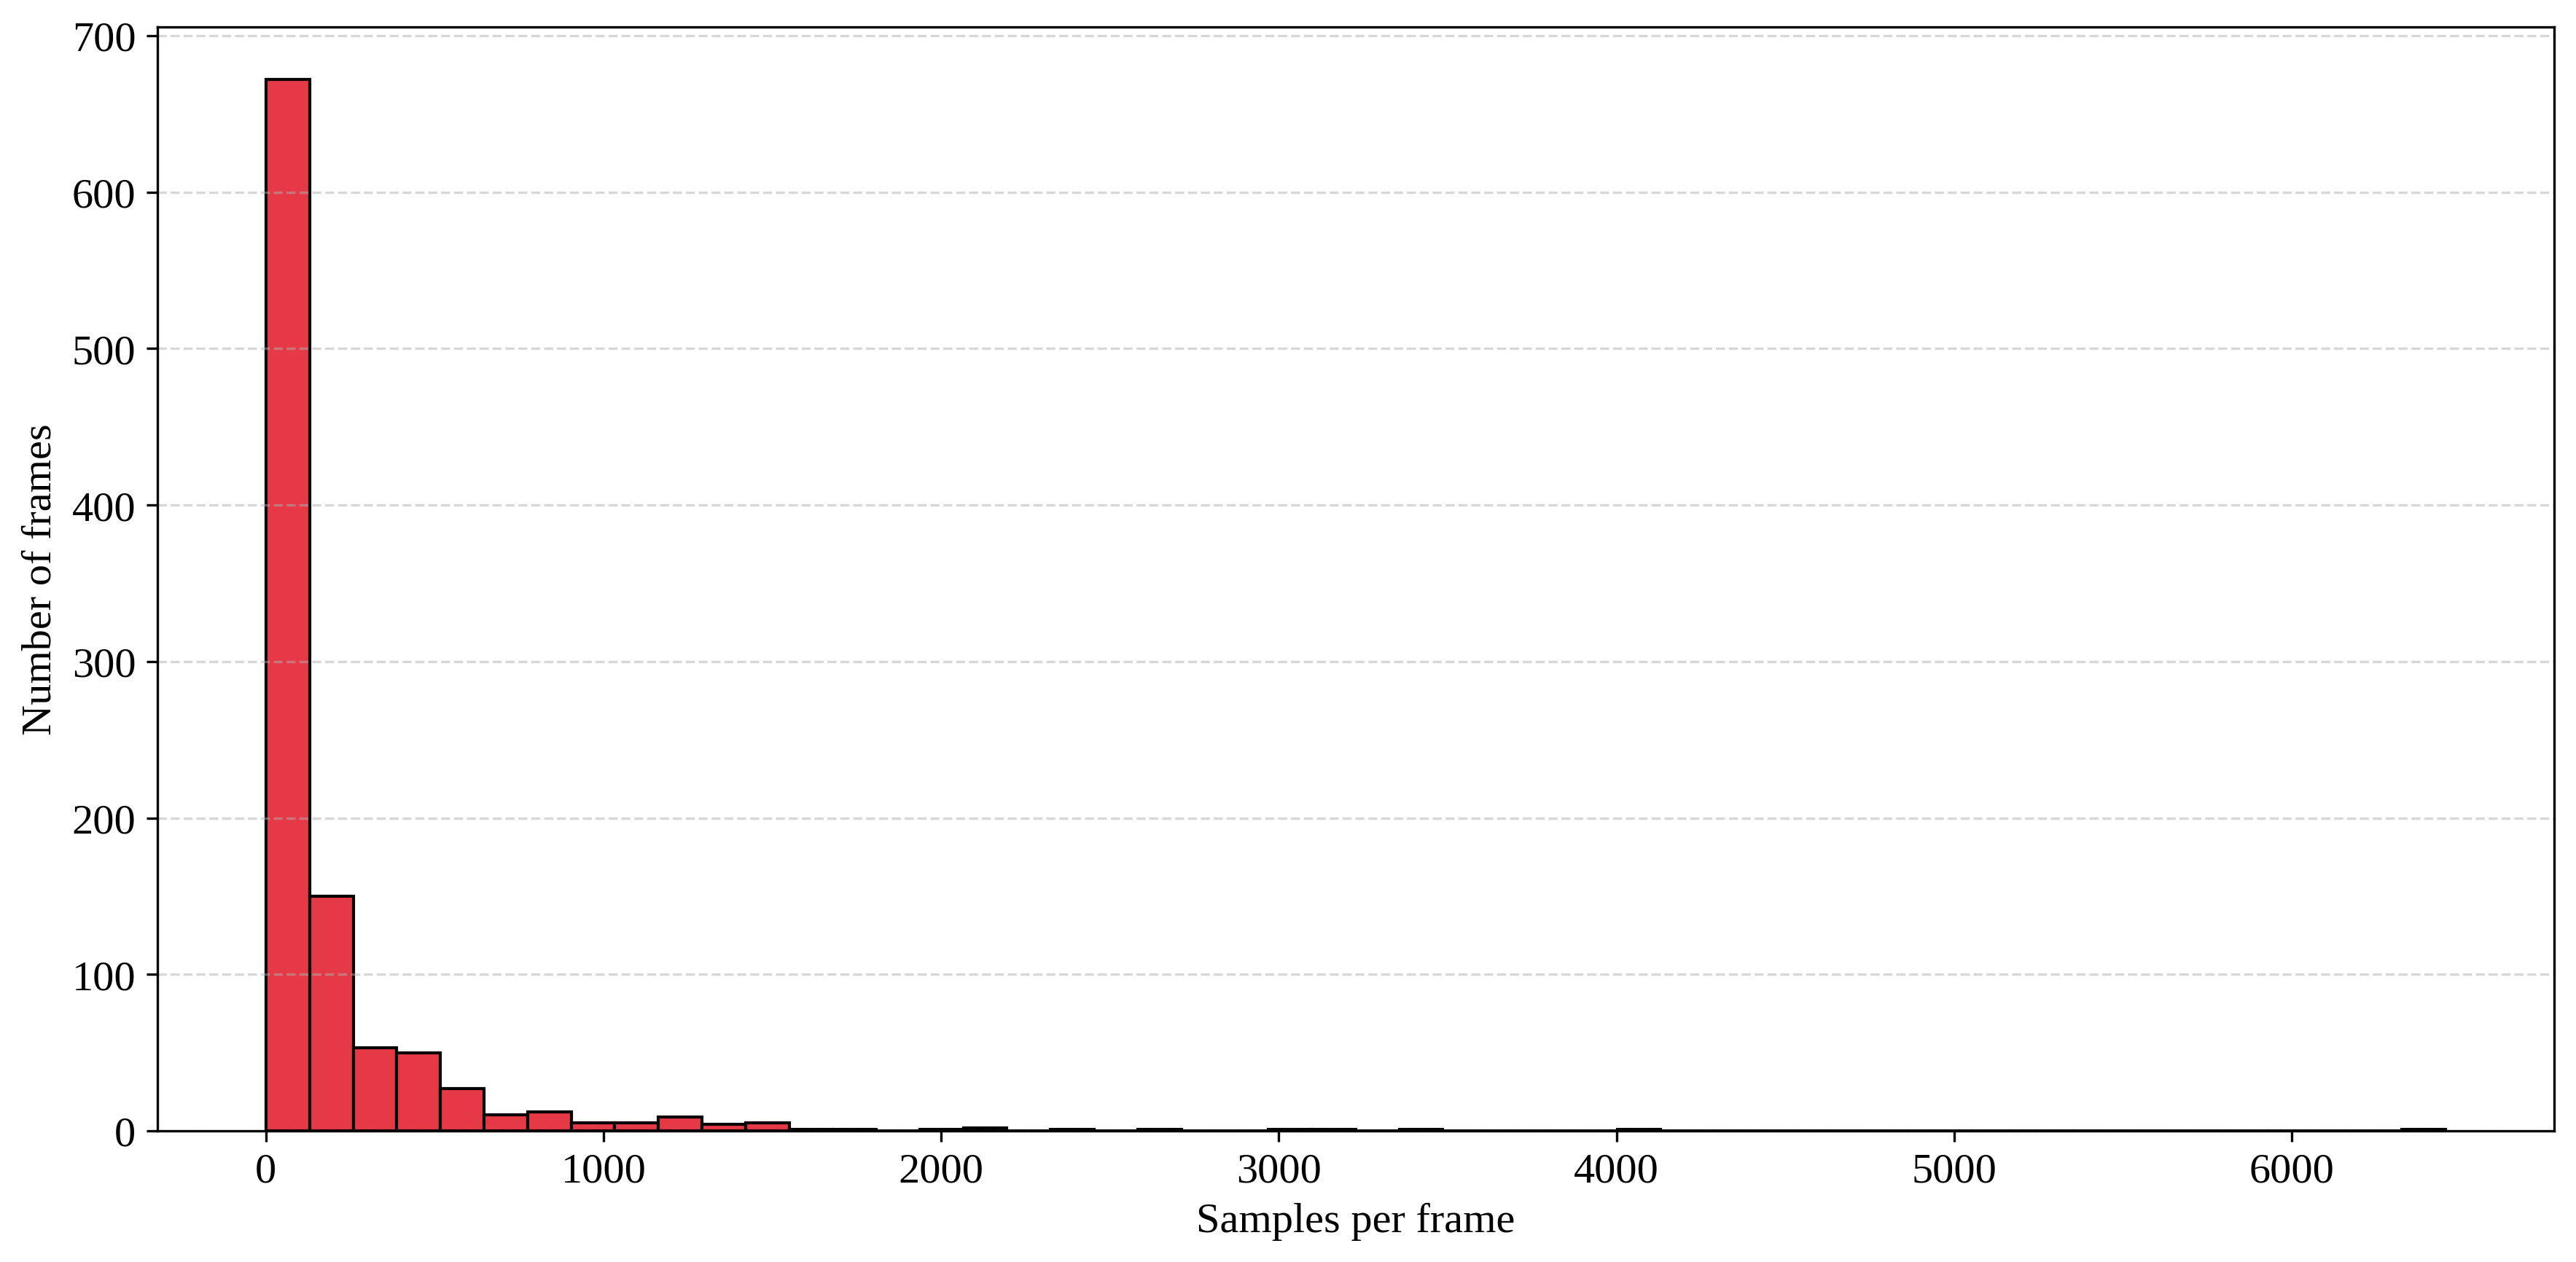

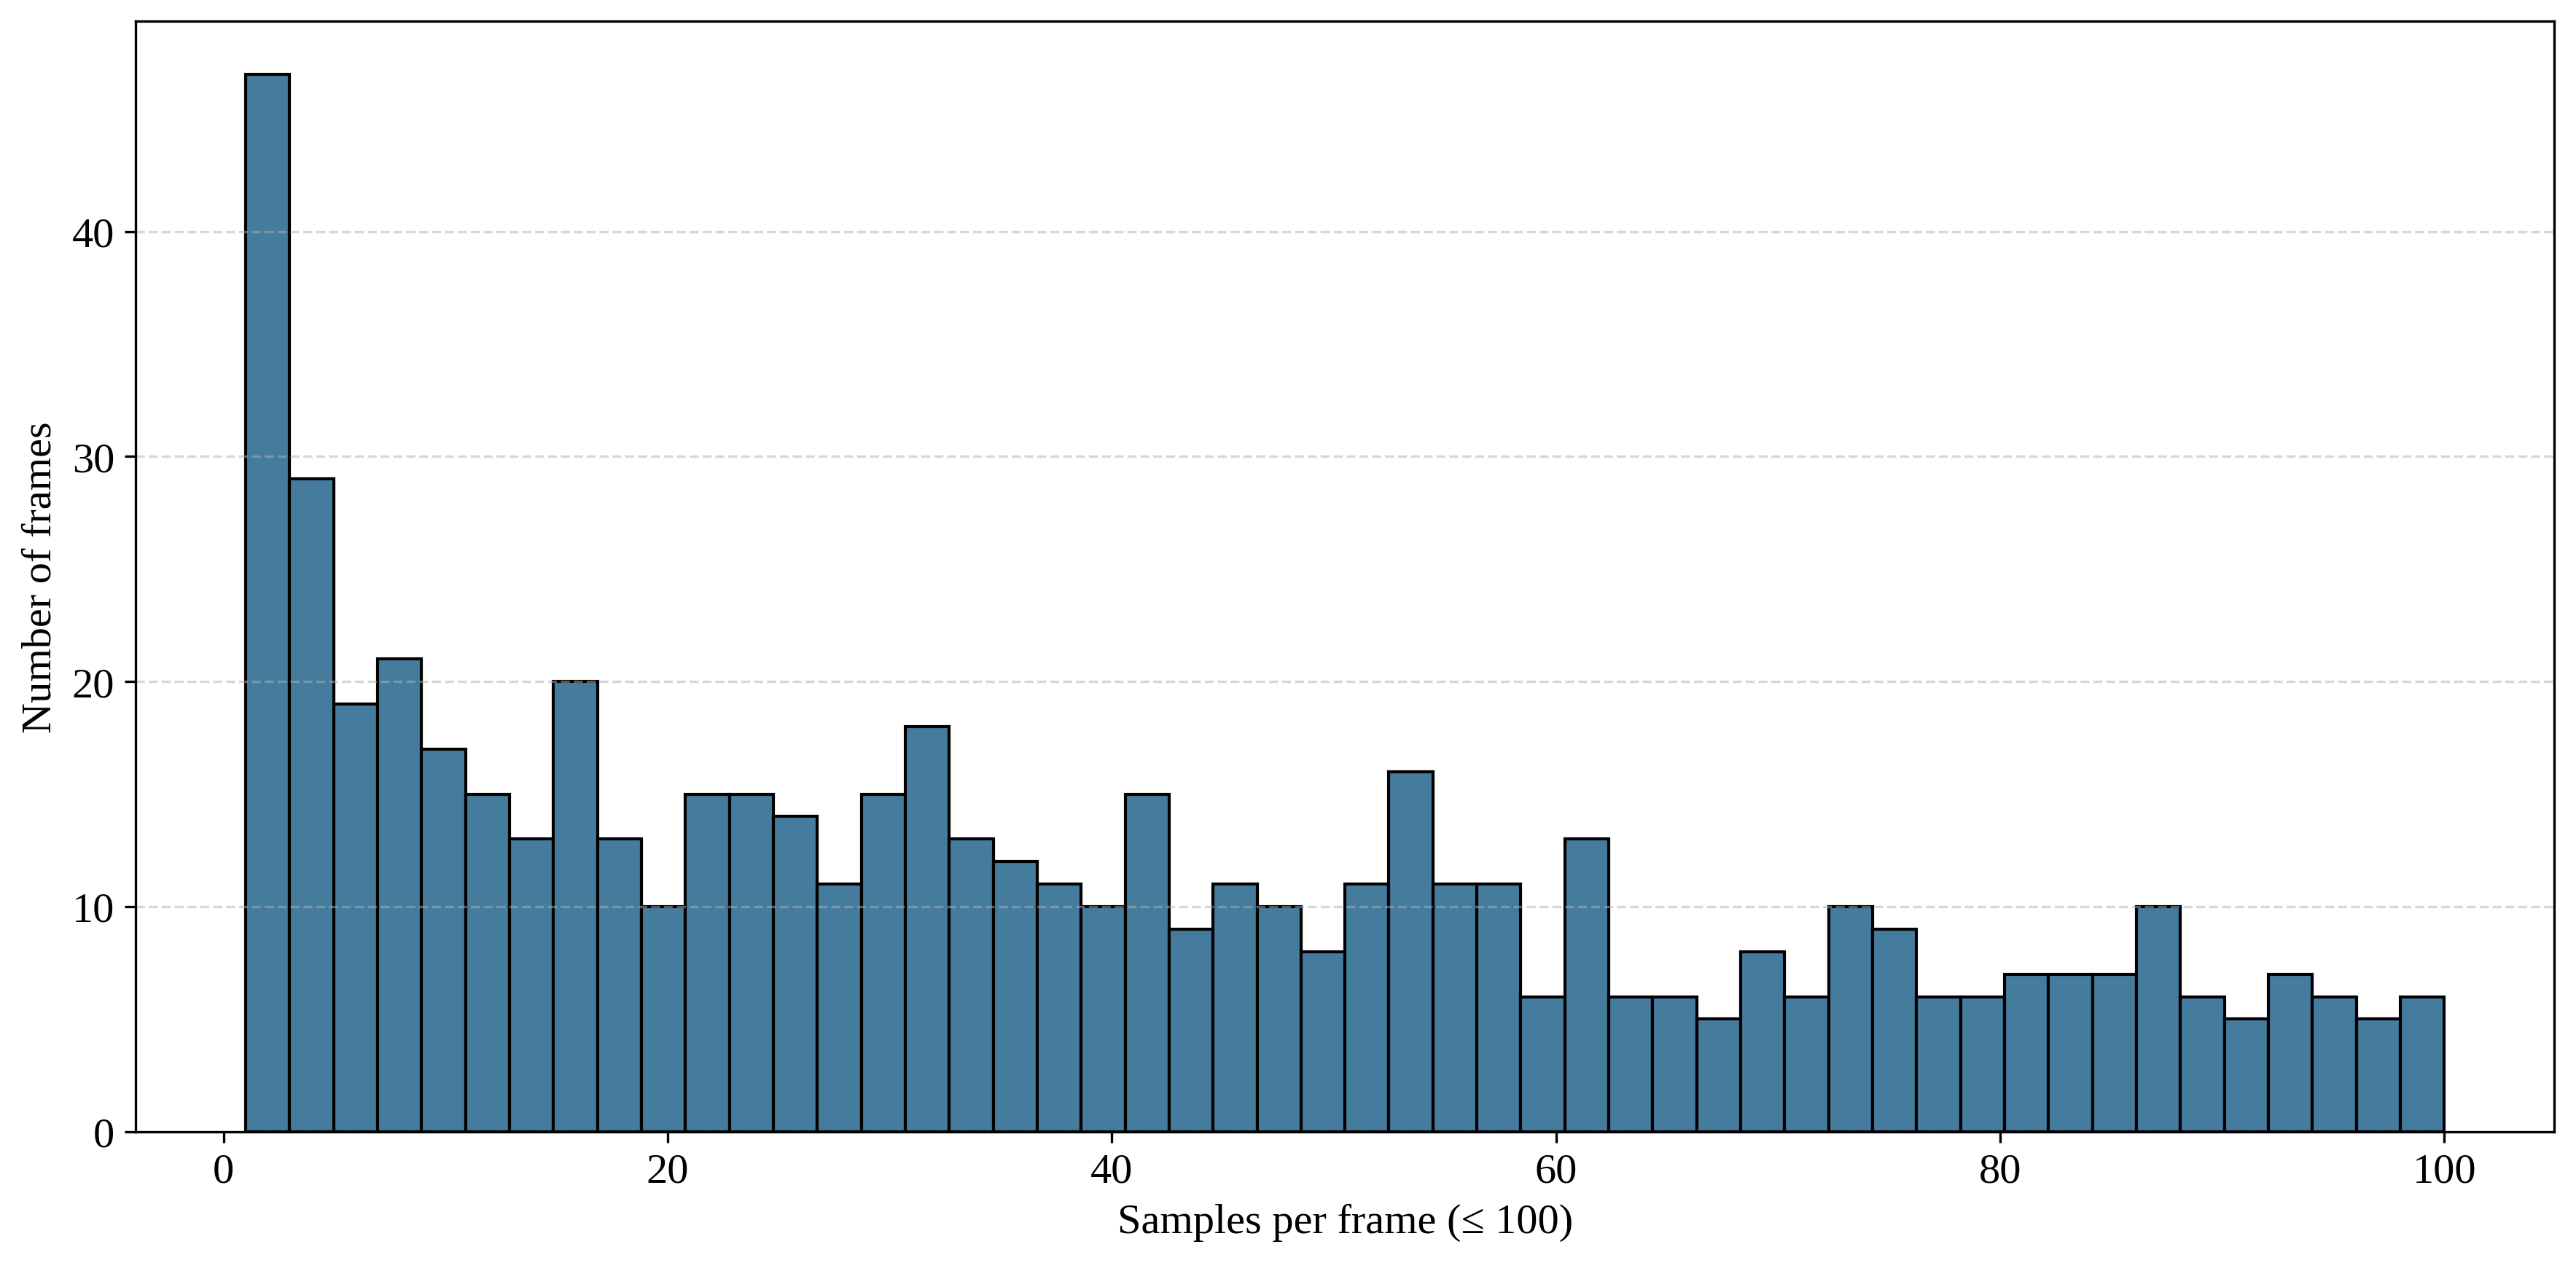

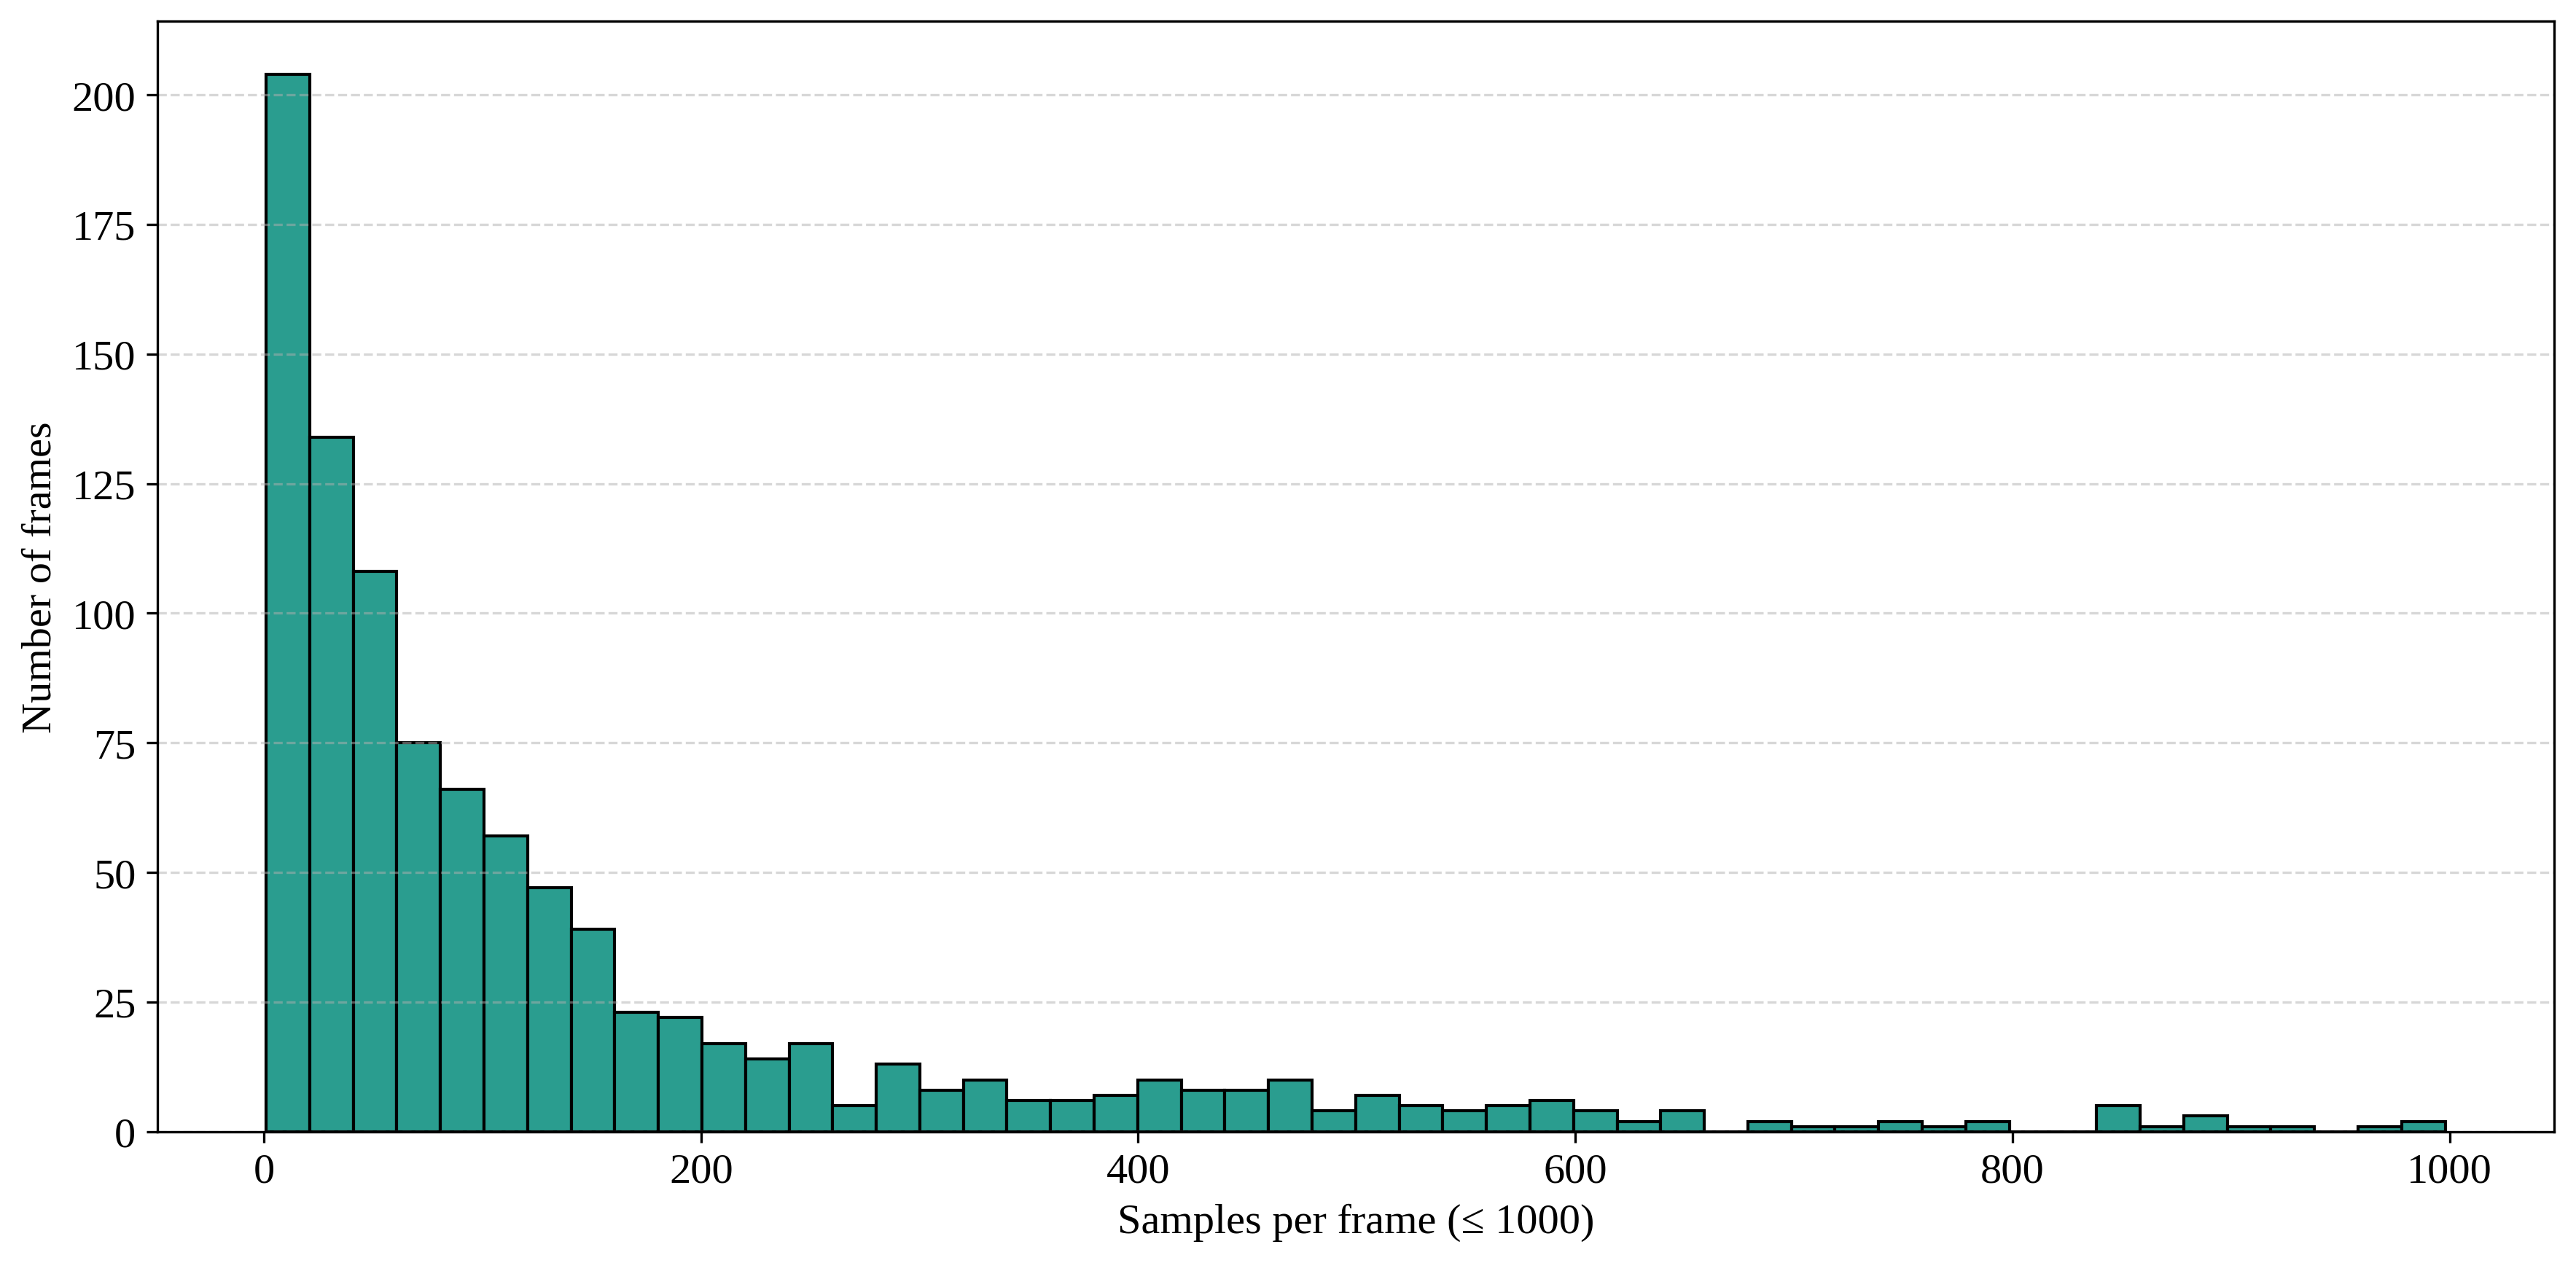

In [ ]:
import matplotlib.pyplot as plt

# ‚úÖ ËÆæÁΩÆÊõ¥Â§ßÂ≠ó‰ΩìÔºå‰æø‰∫éWordÁº©ÊîæÂêé‰ªçÊ∏ÖÊô∞
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # ÊØîÂéüÊù•Êõ¥Â§ßÔºåÈÄÇÂêàÊèíÂÖ•ÊñáÊ°£

# ‚úÖ Ëé∑ÂèñÊØè‰∏™ frame ÁöÑÊ†∑Êú¨Êï∞
frame_counts = df['frame_name'].value_counts()

# ================= Âõæ1ÔºöÂÖ®ÈõÜ =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts.values, bins=50, color='#e63946', edgecolor='black')
plt.xlabel("Samples per frame")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_full_distribution_hd.png", dpi=300, bbox_inches='tight')  # ‰øùÂ≠òÈ´òÊ∏ÖÂõæ
plt.show()

# ================= Âõæ2ÔºöÊ†∑Êú¨Êï∞ ‚â§ 100 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 100].values, bins=50, color='#457b9d', edgecolor='black')
plt.xlabel("Samples per frame (‚â§ 100)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under100_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()

# ================= Âõæ3ÔºöÊ†∑Êú¨Êï∞ ‚â§ 1000 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 1000].values, bins=50, color='#2a9d8f', edgecolor='black')
plt.xlabel("Samples per frame (‚â§ 1000)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under1000_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
import pickle
import xml.etree.ElementTree as ET
from tqdm import tqdm

# === ‰Ω†Êèê‰æõÁöÑÂéüÂßãÂáΩÊï∞ÔºåÂÆåÂÖ®ÊåâÁÖß‰Ω†ÁöÑÈÄªËæë ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

def add_pure_definition_column(file_path: str, output_path: str = None):
    """
    ‰∏∫pickleÊñá‰ª∂‰∏≠ÁöÑDataFrameÊ∑ªÂä†Á∫ØÂÆö‰πâÂàó
    """
    print(f"Processing file: {file_path}")

    # Âä†ËΩΩÊï∞ÊçÆ
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    # Â¶ÇÊûúÊï∞ÊçÆÊòØÂ≠óÂÖ∏Ê†ºÂºèÔºàÂåÖÂê´dataframeÈîÆÔºâ
    if isinstance(data, dict) and "dataframe" in data:
        df = data["dataframe"]
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        print(f"Unexpected data format in {file_path}")
        return

    print(f"Original dataframe shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Ê£ÄÊü•ÊòØÂê¶Â∑≤ÁªèÊúâpure_definitionÂàó
    if "pure_definition" in df.columns:
        print("pure_definition column already exists, will overwrite...")

    # Á°ÆÂÆöÂÆö‰πâÂàóÁöÑÂêçÁß∞
    definition_column = None
    for col in ["frame_definition", "definition", "frame_def"]:
        if col in df.columns:
            definition_column = col
            break

    if definition_column is None:
        print("Warning: No definition column found. Looking for columns containing 'def'...")
        def_cols = [col for col in df.columns if 'def' in col.lower()]
        if def_cols:
            definition_column = def_cols[0]
            print(f"Using column: {definition_column}")
        else:
            print("Error: No definition column found!")
            return

    print(f"Using definition column: {definition_column}")

    # Â∫îÁî®Á∫ØÂÆö‰πâÊèêÂèñ
    print("Extracting pure definitions...")
    tqdm.pandas(desc="Processing definitions")
    df["pure_definition"] = df[definition_column].progress_apply(extract_pure_definition_from_markup)

    # ÊòæÁ§∫‰∏Ä‰∫õÁ§∫‰æã
    print("\nSample results:")
    for i in range(min(3, len(df))):
        print(f"\nExample {i+1}:")
        print(f"Original: {df.iloc[i][definition_column][:200]}...")
        print(f"Pure: {df.iloc[i]['pure_definition'][:200]}...")

    # ‰øùÂ≠òÁªìÊûú
    if output_path is None:
        output_path = file_path.replace(".pkl", "_with_pure_def.pkl")

    if isinstance(data, dict):
        data["dataframe"] = df
        save_data = data
    else:
        save_data = df

    with open(output_path, "wb") as f:
        pickle.dump(save_data, f)

    print(f"\nSaved to: {output_path}")
    print(f"Final dataframe shape: {df.shape}")

    return df

def main():
    """
    Â§ÑÁêÜÊâÄÊúâÊï∞ÊçÆÈõÜÊñá‰ª∂
    """
    # ÂÆö‰πâÊñá‰ª∂Ë∑ØÂæÑ
    file_paths = {
        "train": "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "val": "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "test": "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    }

    processed_files = {}

    for dataset_name, file_path in file_paths.items():
        try:
            print(f"\n{'='*50}")
            print(f"Processing {dataset_name} dataset")
            print(f"{'='*50}")

            output_path = file_path.replace(".pkl", "_with_pure_def.pkl")
            df = add_pure_definition_column(file_path, output_path)
            processed_files[dataset_name] = output_path

            print(f"‚úÖ Successfully processed {dataset_name} dataset")

        except FileNotFoundError:
            print(f"‚ùå File not found: {file_path}")
        except Exception as e:
            print(f"‚ùå Error processing {dataset_name}: {e}")

    print(f"\n{'='*50}")
    print("Summary of processed files:")
    print(f"{'='*50}")
    for dataset_name, output_path in processed_files.items():
        print(f"{dataset_name}: {output_path}")

if __name__ == "__main__":
    main()


Processing train dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
Unexpected data format in /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
‚úÖ Successfully processed train dataset

Processing val dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/val_df.pkl
Original dataframe shape: (25179, 11)
Columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']
Using definition column: frame_definition
Extracting pure definitions...


Processing definitions: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25179/25179 [00:00<00:00, 143058.14it/s]



Sample results:

Example 1:
Original: These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Part_2.)  There is a symmetrical relationship between the components that undergo the process, and aft...
Pure: [ParseError]...

Example 2:
Original: An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belongs to the River Police.'  'It's a nuisance having to abandon my belongings, though.'...
Pure: [ParseError]...

Example 3:
Original: An Assessor examines a Phenomenon to figure out its Value according to some Feature of the Phenomenon.  This Value is a factor in determining the acceptability of the Phenomenon.  In some cases, a Met...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/val_df_with_pure_def.pkl
Final dataframe shape: (25179, 12)
‚úÖ Successfully processed val dataset

Processing test dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
Ori

Processing definitions: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25579/25579 [00:00<00:00, 143092.78it/s]



Sample results:

Example 1:
Original: An Agent makes a particular facial expression, generally in response to some Internal_cause (generally an emotional state).  Sometimes the Body_part involved in the expression is mentioned in lieu of ...
Pure: [ParseError]...

Example 2:
Original: This frame contains nouns denoting Aggregates of Individuals.  The Aggregates may be described by an Aggregate_property.   'An army of postal workers descended on my office.'  ...
Pure: [ParseError]...

Example 3:
Original: This frame concerns people's knowledge or skill in certain domains.  It does not concern acquaintance or familiarity with people. With adjectives as targets in this frame, we annotate on two FE layers...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/test_df_with_pure_def.pkl
Final dataframe shape: (25579, 12)
‚úÖ Successfully processed test dataset

Summary of processed files:
train: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balance

In [9]:
# @title üì¶ Dataset Splitting with Stratified Sampling


split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
os.makedirs(split_save_dir, exist_ok=True)

train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path = os.path.join(split_save_dir, "val_df.pkl")
test_path = os.path.join(split_save_dir, "test_df.pkl")

def split_data_stratified(df, frame_relations, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42, force=False):
    """
    Perform stratified sampling to split the dataset, ensuring each frame is represented in all subsets.
    If split files already exist and force=False, skip re-splitting.

    Args:
        df: DataFrame containing sentences, target words, and frame labels
        frame_relations: Dictionary of frame-to-frame relationships
        train_ratio: Proportion of training set
        val_ratio: Proportion of validation set
        test_ratio: Proportion of test set
        random_state: Random seed
        force: If True, redo the split even if files exist

    Returns:
        train_df, val_df, test_df: Splitted DataFrames
    """
    if (not force
        and os.path.exists(train_path)
        and os.path.exists(val_path)
        and os.path.exists(test_path)):
        print("‚úÖ Split files already exist. Skipping split (use force=True to regenerate).")
        with open(train_path, "rb") as f:
            train_df = pickle.load(f)
        with open(val_path, "rb") as f:
            val_df = pickle.load(f)
        with open(test_path, "rb") as f:
            test_df = pickle.load(f)
        return train_df, val_df, test_df

    # --- your original splitting logic starts here ---
    from collections import defaultdict
    import numpy as np

    print("Grouping by sentence...")
    sentence_groups = {}
    for idx, row in df.iterrows():
        sentence = row['sentence']
        if sentence not in sentence_groups:
            sentence_groups[sentence] = []
        sentence_groups[sentence].append(idx)

    print("Collecting sentences for each frame...")
    frame_sentences = defaultdict(set)
    for sentence, indices in sentence_groups.items():
        frames = set(df.loc[idx, 'frame_name'] for idx in indices)
        for frame in frames:
            frame_sentences[frame].add(sentence)

    frame_counts = {frame: len(sentences) for frame, sentences in frame_sentences.items()}
    print(f"Total number of frames: {len(frame_counts)}")

    rare_frames = {f: c for f, c in frame_counts.items() if c < 5}
    medium_frames = {f: c for f, c in frame_counts.items() if 5 <= c < 20}
    common_frames = {f: c for f, c in frame_counts.items() if c >= 20}

    print(f"Rare frames (<5 sentences): {len(rare_frames)}")
    print(f"Medium-frequency frames (5‚Äì19 sentences): {len(medium_frames)}")
    print(f"Common frames (‚â•20 sentences): {len(common_frames)}")

    train_sentences, val_sentences, test_sentences = set(), set(), set()
    rare_frame_sentences = set()
    for frame in rare_frames:
        rare_frame_sentences.update(frame_sentences[frame])

    np.random.seed(random_state)

    for frame in common_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    for frame in medium_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = max(n // 2, 2)
        remaining = n - n_train
        n_val = remaining // 2
        n_test = remaining - n_val
        if n_val == 0 and n > 2:
            n_val = 1
            n_train -= 1
        if n_test == 0 and n > 2:
            n_test = 1
            n_train -= 1
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    train_sentences.update(rare_frame_sentences)
    val_sentences -= train_sentences
    test_sentences -= train_sentences | val_sentences

    print(f"Number of training sentences: {len(train_sentences)}")
    print(f"Number of validation sentences: {len(val_sentences)}")
    print(f"Number of test sentences: {len(test_sentences)}")

    train_indices = [idx for s in train_sentences for idx in sentence_groups.get(s, [])]
    val_indices = [idx for s in val_sentences for idx in sentence_groups.get(s, [])]
    test_indices = [idx for s in test_sentences for idx in sentence_groups.get(s, [])]

    train_df = df.loc[train_indices].reset_index(drop=True)
    val_df = df.loc[val_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)

    train_frames = set(train_df['frame_name'])
    val_frames = set(val_df['frame_name'])
    test_frames = set(test_df['frame_name'])

    print(f"Number of frames in training set: {len(train_frames)}")
    print(f"Number of frames in validation set: {len(val_frames)}")
    print(f"Number of frames in test set: {len(test_frames)}")
    print(f"Validation-only frames: {len(val_frames - train_frames)}")
    print(f"Test-only frames: {len(test_frames - train_frames)}")

    for i in range(1, 6):
        exact_frames = [f for f, c in frame_counts.items() if c == i]
        print(f"Frames with exactly {i} sentence(s): {len(exact_frames)}")
        if exact_frames:
            print(f"  ‚Üí Frame names: {', '.join(exact_frames)}")

    # Save to disk
    with open(train_path, "wb") as f:
        pickle.dump(train_df, f)
    with open(val_path, "wb") as f:
        pickle.dump(val_df, f)
    with open(test_path, "wb") as f:
        pickle.dump(test_df, f)
    print("‚úÖ Saved train/val/test splits to disk.")

    return train_df, val_df, test_df


# Apply stratified dataset split
train_df, val_df, test_df = split_data_stratified(df, frame_relations)

frame_freq_df = df['frame_name'].value_counts().reset_index()
frame_freq_df.columns = ['frame_name', 'sentence_count']
frame_freq_df = frame_freq_df.sort_values(by='sentence_count', ascending=False).reset_index(drop=True)


‚úÖ Split files already exist. Skipping split (use force=True to regenerate).


In [14]:
# @title üìä Exemplar Dataset Statistics



import pandas as pd
import os

# ‚úÖ 1. Set paths for exemplar dataset
split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path   = os.path.join(split_save_dir, "val_df.pkl")
test_path  = os.path.join(split_save_dir, "test_df.pkl")

# ‚úÖ 2. Load splits
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# Combine to create the full exemplar dataset
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# ‚úÖ 3. Statistics function
def analyze_exemplar_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples   = len(subset)
        num_frames    = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\nüìÇ {name} subset statistics:")
        print(f"   ‚Üí Number of samples (#Samples): {num_samples:,}")
        print(f"   ‚Üí Number of frames (#Frames): {num_frames:,}")
        print(f"   ‚Üí Number of sentences (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = os.path.join(split_save_dir, "exemplar_split_summary.xlsx")
        summary_df.to_excel(save_path, index=False)
        print(f"\n‚úÖ Summary table saved to: {save_path}")

    return summary_df

# ‚úÖ 4. Execute
summary_df = analyze_exemplar_splits(all_df, train_df, val_df, test_df)



üìÇ All subset statistics:
   ‚Üí Number of samples (#Samples): 200,750
   ‚Üí Number of frames (#Frames): 1,014
   ‚Üí Number of sentences (#Sentences): 171,664

üìÇ Train subset statistics:
   ‚Üí Number of samples (#Samples): 150,110
   ‚Üí Number of frames (#Frames): 1,014
   ‚Üí Number of sentences (#Sentences): 121,901

üìÇ Val subset statistics:
   ‚Üí Number of samples (#Samples): 25,113
   ‚Üí Number of frames (#Frames): 906
   ‚Üí Number of sentences (#Sentences): 24,553

üìÇ Test subset statistics:
   ‚Üí Number of samples (#Samples): 25,527
   ‚Üí Number of frames (#Frames): 907
   ‚Üí Number of sentences (#Sentences): 25,210

‚úÖ Summary table saved to: /content/drive/MyDrive/more50/framenet_data/exemplar_split_summary.xlsx


In [16]:
# @title üìä Fulltext Dataset Statistics - OpenSesame

import pandas as pd
import os

# ‚úÖ 1. Set paths for exemplar dataset
full_path = "/content/drive/MyDrive/Open_sesame/framenet_data/framenet_data.pkl"  # fulltext full dataset path
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ‚úÖ 2. Load datasets
all_df   = pd.read_pickle(full_path)  # this is still fulltext full dataset, change if exemplar full file exists
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# ‚úÖ 3. Statistics function
def analyze_exemplar_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples   = len(subset)
        num_frames    = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\nüìÇ {name} subset statistics:")
        print(f"   ‚Üí Number of samples (#Samples): {num_samples:,}")
        print(f"   ‚Üí Number of frames (#Frames): {num_frames:,}")
        print(f"   ‚Üí Number of sentences (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = "/content/drive/MyDrive/Open_sesame/framenet_data/exemplar_split_summary.xlsx"
        summary_df.to_excel(save_path, index=False)
        print(f"\n‚úÖ Summary table saved to: {save_path}")

    return summary_df

# ‚úÖ 4. Execute
summary_df = analyze_exemplar_splits(all_df, train_df, val_df, test_df)




üìÇ All subset statistics:
   ‚Üí Number of samples (#Samples): 29,359
   ‚Üí Number of frames (#Frames): 796
   ‚Üí Number of sentences (#Sentences): 4,924

üìÇ Train subset statistics:
   ‚Üí Number of samples (#Samples): 20,105
   ‚Üí Number of frames (#Frames): 753
   ‚Üí Number of sentences (#Sentences): 3,353

üìÇ Val subset statistics:
   ‚Üí Number of samples (#Samples): 2,382
   ‚Üí Number of frames (#Frames): 368
   ‚Üí Number of sentences (#Sentences): 326

üìÇ Test subset statistics:
   ‚Üí Number of samples (#Samples): 6,872
   ‚Üí Number of frames (#Frames): 574
   ‚Üí Number of sentences (#Sentences): 1,247

‚úÖ Summary table saved to: /content/drive/MyDrive/Open_sesame/framenet_data/exemplar_split_summary.xlsx


In [26]:
import pandas as pd

# ‚úÖ 1. Load the three datasets
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# ‚úÖ 2. Get unique frame sets
train_frames = set(train_df["frame_name"].unique())
val_frames   = set(val_df["frame_name"].unique())
test_frames  = set(test_df["frame_name"].unique())

# ‚úÖ 3. Find exclusive frames
exclusive_train = train_frames - (val_frames | test_frames)
exclusive_val   = val_frames - (train_frames | test_frames)
exclusive_test  = test_frames - (train_frames | val_frames)

# ‚úÖ 4. Find overlaps
train_val_overlap = train_frames & val_frames
train_test_overlap = train_frames & test_frames
val_test_overlap = val_frames & test_frames
all_three_overlap = train_frames & val_frames & test_frames

# ‚úÖ 5. Print summary
print("\n=== Frame Overlap & Exclusive Analysis ===")
print(f"Train unique frames: {len(train_frames)}")
print(f"Val unique frames:   {len(val_frames)}")
print(f"Test unique frames:  {len(test_frames)}")

print(f"\nExclusive to Train: {len(exclusive_train)} ‚Üí {sorted(list(exclusive_train))}")
print(f"Exclusive to Val:   {len(exclusive_val)} ‚Üí {sorted(list(exclusive_val))}")
print(f"Exclusive to Test:  {len(exclusive_test)} ‚Üí {sorted(list(exclusive_test))}")

print(f"\nOverlap (Train ‚à© Val): {len(train_val_overlap)}")
print(f"Overlap (Train ‚à© Test): {len(train_test_overlap)}")
print(f"Overlap (Val ‚à© Test):   {len(val_test_overlap)}")
print(f"Overlap (all three):    {len(all_three_overlap)}")



=== Frame Overlap & Exclusive Analysis ===
Train unique frames: 753
Val unique frames:   368
Test unique frames:  574

Exclusive to Train: 183 ‚Üí ['Abandonment', 'Abundance', 'Activity_resume', 'Actually_occurring_entity', 'Aging', 'Aiming', 'Animals', 'Apply_heat', 'Appointing', 'Arraignment', 'Arson', 'Attempt_means', 'Attitude_description', 'Awareness_status', 'Bail_decision', 'Be_subset_of', 'Becoming_dry', 'Behind_the_scenes', 'Being_in_captivity', 'Being_in_control', 'Being_incarcerated', 'Being_relevant', 'Being_wet', 'Besieging', 'Billing', 'Biological_entity', 'Body_mark', 'Breaking_out_captive', 'Breathing', 'Catching_fire', 'Cause_bodily_experience', 'Cause_change_of_phase', 'Cause_change_of_strength', 'Cause_emotion', 'Cause_fluidic_motion', 'Cause_impact', 'Cause_to_experience', 'Cause_to_make_noise', 'Cause_to_move_in_place', 'Change_of_phase', 'Change_operational_state', 'Change_post-state', 'Change_tool', 'Co-association', 'Color_qualities', 'Come_down_with', 'Communi

In [20]:
# ============================================
#  @title üìä FE-only Frame Classification (Exemplar)
# Rebuild FE prototypes & preferences from train set,
# evaluate on the given val_df path.
# Paths are hard-coded as requested.
# ============================================

# -------------------------
# 0) Paths (hard-coded)
# -------------------------
split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path   = os.path.join(split_save_dir, "val_df.pkl")  # <-- use THIS path to load val set (as you asked)

# -------------------------
# 1) Load data
# -------------------------
print("üì¶ Loading datasets...")
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
print(f"‚úÖ Loaded train_df: {train_df.shape}, val_df: {val_df.shape}")

# -------------------------
# 2) Model & tokenizer
# -------------------------
model_name = "distilbert-base-uncased"  # keep consistent with your project unless you change it
print(f"üß† Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
print(f"‚úÖ Device: {device}")

# -------------------------------------------------
# 3) Utilities: batch encoding with offset mapping
# -------------------------------------------------
def encode_batch_with_offsets(sentences, tokenizer, max_length=512, device="cpu"):
    """
    Tokenize a list of sentences and return encoding on device,
    keeping offset_mapping on CPU for span to token alignment.
    """
    encoding = tokenizer(
        sentences,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
    )
    # Move tensors used by the model to device; keep offsets on CPU
    model_inputs = {
        "input_ids": encoding["input_ids"].to(device, non_blocking=True),
        "attention_mask": encoding["attention_mask"].to(device, non_blocking=True),
    }
    offset_mappings = encoding["offset_mapping"]  # CPU
    return model_inputs, offset_mappings

def mean_token_embedding(hidden_states, token_indices):
    """Mean-pool hidden states at token_indices (unique)."""
    if not token_indices:
        return None
    unique = sorted(set(token_indices))
    return hidden_states[unique, :].mean(dim=0)

def char_span_to_token_indices(offset_mapping, start_char, end_char):
    """
    Map a character span [start_char, end_char) to token indices using offset_mapping.
    """
    idxs = []
    for tidx, (s, e) in enumerate(offset_mapping.tolist()):
        if s == 0 and e == 0:  # special tokens
            continue
        # overlap condition
        if s < end_char and e > start_char and s != e:
            idxs.append(tidx)
    return idxs

# -------------------------------------------------------------------
# 4) Build FE preferences from train set (top-K FE types per frame)
# -------------------------------------------------------------------
def build_frame_fe_preferences(train_df, top_k=3):
    """
    For each frame, find top-K most frequent FE types from train_df['fe_spans'].
    Expects fe_spans as a list of dicts with keys: fe_name, start, end.
    """
    frame_fe_counts = defaultdict(Counter)
    for _, row in train_df.iterrows():
        frame = row["frame_name"]
        fe_spans = row.get("fe_spans", [])
        if isinstance(fe_spans, list):
            for fe in fe_spans:
                if isinstance(fe, dict) and "fe_name" in fe:
                    frame_fe_counts[frame][fe["fe_name"]] += 1

    frame_fe_prefs = {}
    for frame, counter in frame_fe_counts.items():
        # keep top_k by frequency (ties broken arbitrarily by Counter)
        prefs = [fe for fe, _ in counter.most_common(top_k)]
        frame_fe_prefs[frame] = prefs

    return frame_fe_prefs

print("üß≠ Building FE preferences (top-3 per frame) from train set...")
frame_fe_preferences = build_frame_fe_preferences(train_df, top_k=3)
print(f"‚úÖ Built FE preferences for {len(frame_fe_preferences)} frames.")

# -------------------------------------------------------------
# 5) Build FE prototypes from train set (mean-pooled embeddings)
# -------------------------------------------------------------
def build_frame_fe_prototypes(train_df, frame_fe_prefs, model, tokenizer, device, batch_size=64):
    """
    For each frame and each preferred FE in that frame, compute a prototype
    as the mean embedding over all its occurrences in the train set.
    Returns: dict[frame_name] -> dict[fe_name] -> torch.Tensor (on device)
    """
    # Accumulators
    proto_sum = defaultdict(lambda: defaultdict(lambda: torch.zeros(model.config.hidden_size, device=device)))
    proto_cnt = defaultdict(lambda: defaultdict(int))

    sentences = train_df["sentence"].tolist()
    fe_spans_list = train_df["fe_spans"].tolist()
    frames = train_df["frame_name"].tolist()

    print("üß± Building FE prototypes from train set...")
    for start in tqdm(range(0, len(sentences), batch_size), desc="Proto batching"):
        end = min(start + batch_size, len(sentences))
        batch_sents = sentences[start:end]
        batch_fes   = fe_spans_list[start:end]
        batch_frames= frames[start:end]

        # encode
        model_inputs, offset_mappings = encode_batch_with_offsets(batch_sents, tokenizer, device=device)
        with torch.no_grad():
            outputs = model(**model_inputs)
            hidden = outputs.last_hidden_state  # [B, T, H]

        for i in range(len(batch_sents)):
            frame = batch_frames[i]
            prefs = frame_fe_prefs.get(frame, [])
            if not prefs:
                continue

            offset_map = offset_mappings[i]
            sample_fes = batch_fes[i] if isinstance(batch_fes[i], list) else []
            # group by fe_name
            fes_by_name = defaultdict(list)
            for fe in sample_fes:
                if isinstance(fe, dict) and "fe_name" in fe and "start" in fe and "end" in fe:
                    fes_by_name[fe["fe_name"]].append((int(fe["start"]), int(fe["end"])))

            # for each preferred FE, compute mean embedding of all its spans in this sample
            for fe_name in prefs:
                if fe_name not in fes_by_name:
                    continue
                token_indices = []
                for (s_char, e_char) in fes_by_name[fe_name]:
                    token_indices.extend(char_span_to_token_indices(offset_map, s_char, e_char))

                if token_indices:
                    emb = mean_token_embedding(hidden[i], token_indices)  # [H]
                    if emb is not None:
                        proto_sum[frame][fe_name] += emb
                        proto_cnt[frame][fe_name] += 1

    # finalise prototypes
    frame_fe_prototypes = {}
    for frame, fe_map in proto_sum.items():
        frame_fe_prototypes[frame] = {}
        for fe_name, sum_vec in fe_map.items():
            cnt = proto_cnt[frame][fe_name]
            if cnt > 0:
                frame_fe_prototypes[frame][fe_name] = (sum_vec / cnt)
    print(f"‚úÖ Built FE prototypes for {len(frame_fe_prototypes)} frames.")
    return frame_fe_prototypes

frame_fe_prototypes = build_frame_fe_prototypes(
    train_df, frame_fe_preferences, model, tokenizer, device, batch_size=64
)

# -------------------------------------------------------------
# 6) FE-only evaluation on val_df
# -------------------------------------------------------------
def extract_fe_embeddings_batch(sentences, fe_spans_list, allowed_fe_names, model, tokenizer, device, batch_size=64):
    """
    Extract FE embeddings per sample as {fe_name: embedding (np.array)}.
    Only keep FE types in allowed_fe_names.
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for start in tqdm(range(0, len(sentences), batch_size), desc="üîé FE embedding batches", leave=False):
        end = min(start + batch_size, len(sentences))
        batch_sents = sentences[start:end]
        batch_fes   = fe_spans_list[start:end]

        model_inputs, offset_mappings = encode_batch_with_offsets(batch_sents, tokenizer, device=device)
        with torch.no_grad():
            hidden = model(**model_inputs).last_hidden_state  # [B, T, H]

        for i in range(len(batch_sents)):
            fe_dict = {}
            try:
                offset_map = offset_mappings[i]
                fe_spans = batch_fes[i] if isinstance(batch_fes[i], list) else []
                for fe in fe_spans:
                    if (
                        isinstance(fe, dict)
                        and "fe_name" in fe
                        and fe["fe_name"] in allowed_fe_names
                        and "start" in fe and "end" in fe
                    ):
                        idxs = char_span_to_token_indices(offset_map, int(fe["start"]), int(fe["end"]))
                        if idxs:
                            emb = mean_token_embedding(hidden[i], idxs)
                            if emb is not None:
                                fe_dict[fe["fe_name"]] = emb.detach().cpu().numpy()
                all_fe_embeddings.append(fe_dict)
                stats["success"] += int(bool(fe_dict))
                stats["failed"]  += int(not bool(fe_dict))
            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats

def fe_only_classification(val_df, frame_fe_prototypes, frame_fe_prefs, model, tokenizer, device):
    """
    FE-only frame classification on val_df using cosine similarity to FE prototypes.
    """
    print("\nüß™ Running FE-only frame classification on val set...")
    val_sentences = val_df["sentence"].tolist()
    val_fe_spans  = val_df["fe_spans"].tolist()
    val_gold      = val_df["frame_name"].tolist()

    # collect all FE types appearing in preferences (universe of allowed FEs)
    all_preferred_fes = set()
    for fes in frame_fe_prefs.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)
    print(f"üìä Number of preferred FE types (union): {len(all_preferred_fes)}")

    print("‚ö° Extracting FE embeddings for queries...")
    query_fe_embs, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"‚úÖ Done: success {fe_stats['success']}, failed {fe_stats['failed']}")

    frames = list(frame_fe_prototypes.keys())
    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0,
    }

    print("üîÑ Scoring by mean cosine similarity...")
    for i in tqdm(range(len(query_fe_embs)), desc="üîç Similarity & prediction"):
        q = query_fe_embs[i]
        if not q:
            # fallback: deterministic fallback to first frame for reproducibility
            predictions.append(frames[0] if frames else None)
            stats["samples_without_fes"] += 1
            stats["random_predictions"]  += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}
        for frame in frames:
            prefs = frame_fe_prefs.get(frame, [])
            fe_protos = frame_fe_prototypes.get(frame, {})
            total, cnt = 0.0, 0
            for fe_name, q_vec in q.items():
                if fe_name in prefs and fe_name in fe_protos:
                    q_tensor = torch.tensor(q_vec, device=device)
                    p_tensor = fe_protos[fe_name]  # already on device
                    sim = F.cosine_similarity(q_tensor, p_tensor, dim=0).item()
                    total += sim
                    cnt += 1
            frame_scores[frame] = (total / cnt) if cnt > 0 else 0.0

        if frame_scores and max(frame_scores.values()) > 0:
            pred = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            pred = frames[0] if frames else None
            stats["random_predictions"] += 1

        predictions.append(pred)

    # compute metrics
    correct = sum(int(p == g) for p, g in zip(predictions, val_gold))
    fe_correct = sum(int(p == g) for p, g, emb in zip(predictions, val_gold, query_fe_embs) if emb)

    overall_acc = correct / stats["total_samples"] if stats["total_samples"] > 0 else 0.0
    fe_only_acc = (fe_correct / stats["samples_with_fes"]) if stats["samples_with_fes"] > 0 else 0.0
    fe_coverage = stats["samples_with_fes"] / stats["total_samples"] if stats["total_samples"] > 0 else 0.0

    # pretty print
    print("\nüìä FE-only classification results:")
    print(f"   Total samples:          {stats['total_samples']:,}")
    print(f"   Samples with FEs:       {stats['samples_with_fes']:,}")
    print(f"   Samples without FEs:    {stats['samples_without_fes']:,}")
    print(f"   Overall accuracy:       {overall_acc:.4f}")
    print(f"   Accuracy on FE samples: {fe_only_acc:.4f}")
    print(f"   FE coverage:            {fe_coverage:.2%}")

    # quick qualitative conclusion
    if fe_only_acc > 0:
        print("\nüí° Conclusion:")
        if fe_only_acc >= 0.6:
            print(f"   ‚úÖ FEs show strong independent discriminative power ({fe_only_acc:.1%})")
        elif fe_only_acc >= 0.4:
            print(f"   ‚ö†Ô∏è  FEs show moderate discriminative power ({fe_only_acc:.1%})")
        else:
            print(f"   ‚ùå FEs show weak independent discriminative power ({fe_only_acc:.1%})")

        # optional theoretical upper bound if perfectly fused with a target baseline
        target_baseline = 0.76  # adjust if your current target-based baseline changes
        potential_gain = fe_only_acc * (1 - target_baseline)
        print(f"   üìà Theoretical upper bound gain: +{potential_gain:.1%} (with perfect fusion)")

    return overall_acc, fe_only_acc, stats

# -------------------------
# 7) Run the experiment
# -------------------------
overall_acc, fe_only_acc, stats = fe_only_classification(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)

# Optionally save summary
summary = {
    "overall_accuracy": float(overall_acc),
    "fe_only_accuracy": float(fe_only_acc),
    "total_samples": int(stats["total_samples"]),
    "samples_with_fes": int(stats["samples_with_fes"]),
    "samples_without_fes": int(stats["samples_without_fes"]),
    "fe_coverage": float(stats["samples_with_fes"] / max(1, stats["total_samples"])),
    "model_name": model_name,
}
out_path = os.path.join(split_save_dir, "fe_only_exemplar_eval_summary.json")
with open(out_path, "w") as f:
    json.dump(summary, f, indent=2)
print(f"\nüìù Saved summary to: {out_path}")


üì¶ Loading datasets...
‚úÖ Loaded train_df: (150110, 11), val_df: (25113, 11)
üß† Loading model: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

‚úÖ Device: cuda
üß≠ Building FE preferences (top-3 per frame) from train set...
‚úÖ Built FE preferences for 1014 frames.
üß± Building FE prototypes from train set...


Proto batching: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2346/2346 [02:18<00:00, 16.88it/s]


‚úÖ Built FE prototypes for 1013 frames.

üß™ Running FE-only frame classification on val set...
üìä Number of preferred FE types (union): 817
‚ö° Extracting FE embeddings for queries...


‚úÖ Done: success 24358, failed 755
üîÑ Scoring by mean cosine similarity...


üîç Similarity & prediction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25113/25113 [03:29<00:00, 120.08it/s]


üìä FE-only classification results:
   Total samples:          25,113
   Samples with FEs:       24,358
   Samples without FEs:    755
   Overall accuracy:       0.4403
   Accuracy on FE samples: 0.4538
   FE coverage:            96.99%

üí° Conclusion:
   ‚ö†Ô∏è  FEs show moderate discriminative power (45.4%)
   üìà Theoretical upper bound gain: +10.9% (with perfect fusion)

üìù Saved summary to: /content/drive/MyDrive/more50/framenet_data/fe_only_exemplar_eval_summary.json


In [19]:
# @title ‚úÖ ÊâÄÊúâÂàùÂßãÂéüÂûãÊµãËØïÔºàÈ™åËØÅÈõÜÔºâ

# @title ‚úÖ All Initial Prototype Tests (Validation Set)

# Load data and model
def load_data_and_model():
    """Load all required datasets and the model"""
    print("Loading data and model...")

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load training and validation data
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    # Load definition embeddings
    definition_data = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl")

    # Load untrained model
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    print(f"Training samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    print(f"Definition data type: {type(definition_data)}")
    if isinstance(definition_data, dict):
        print(f"Number of definitions: {len(definition_data)}")
        print(f"First few keys: {list(definition_data.keys())[:3]}")
    else:
        print(f"Definition data shape: {definition_data.shape}")
        print(f"Definition data columns: {definition_data.columns.tolist()}")
    print(f"Number of frames in training set: {len(train_df['frame_name'].unique()):,}")

    return train_df, val_df, definition_data, model, tokenizer, device

def analyze_frame_distribution(train_df):
    """Analyse the frame frequency distribution"""
    frame_counts = train_df['frame_name'].value_counts()

    print("\nFrame frequency statistics:")
    print(f"Total frames: {len(frame_counts)}")
    print("Sample count statistics:")
    print(f"  >= 10 samples: {(frame_counts >= 10).sum()} frames")
    print(f"  >= 5 samples:  {(frame_counts >= 5).sum()} frames")
    print(f"  >= 3 samples:  {(frame_counts >= 3).sum()} frames")
    print(f"  = 1 sample:    {(frame_counts == 1).sum()} frames")
    print(f"  = 2 samples:   {(frame_counts == 2).sum()} frames")

    print(f"\nAvailable frames for each shot setting:")
    for shot in [1, 3, 5, 10]:
        available = (frame_counts >= shot).sum()
        print(f"  {shot}-shot: {available} frames available ({available/len(frame_counts)*100:.1f}%)")

    return frame_counts

def save_prototypes_to_drive(prototypes, save_path, description):
    """Save prototypes to Google Drive"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_dict = {}
    for frame_name, prototype in prototypes.items():
        if isinstance(prototype, torch.Tensor):
            save_dict[frame_name] = prototype.numpy()
        else:
            save_dict[frame_name] = prototype

    with open(save_path, 'wb') as f:
        pickle.dump(save_dict, f)

    file_name = os.path.basename(save_path)
    print(f"‚úÖ {description} saved successfully:")
    print(f"   File name: {file_name}")
    print(f"   Full path: {save_path}")
    return save_path

def analyze_prototype_similarity(prototypes, method_name):
    """Analyse prototype similarity (3 core metrics)"""
    embeddings = np.array(list(prototypes.values()))

    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)

    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    mean_sim = np.mean(upper_triangle)
    std_sim = np.std(upper_triangle)
    max_sim = np.max(upper_triangle)

    print(f"  üìä {method_name} internal similarity:")
    print(f"     Mean similarity: {mean_sim:.4f} (lower = more diverse)")
    print(f"     Std deviation:   {std_sim:.4f} (higher = more spread)")
    print(f"     Max similarity:  {max_sim:.4f} (lower = better separation)")

    return {
        'mean_similarity': mean_sim,
        'std_similarity': std_sim,
        'max_similarity': max_sim,
        'prototype_count': len(prototypes)
    }

def build_few_shot_prototypes(model, tokenizer, train_df, shot_num=5):
    """Build few-shot prototypes using the untrained model (mean pooling)"""

    if shot_num == float('inf'):
        print(f"\nBuilding full-set initial prototypes...")
        shot_desc = "full set"
    else:
        print(f"\nBuilding {shot_num}-shot prototypes...")
        shot_desc = f"{shot_num}-shot"

    few_shot_prototypes = {}
    frame_groups = train_df.groupby('frame_name')

    stats = {
        'sufficient_samples': 0,
        'insufficient_samples': 0,
        'skipped_frames': 0,
        'actual_shots_used': []
    }

    error_count = 0

    model.eval()
    with torch.no_grad():
        for frame_name, group in tqdm(frame_groups, desc=f"Building {shot_desc} prototypes"):
            group_size = len(group)

            if shot_num == float('inf'):
                actual_shot = group_size
                sampled = group
                stats['sufficient_samples'] += 1
            elif group_size >= shot_num:
                actual_shot = shot_num
                stats['sufficient_samples'] += 1
                sampled = group.sample(n=actual_shot, random_state=42)
            elif group_size > 0:
                actual_shot = group_size
                stats['insufficient_samples'] += 1
                sampled = group
            else:
                stats['skipped_frames'] += 1
                continue

            stats['actual_shots_used'].append(actual_shot)

            try:
                embeddings = encode_target_spans_batch(
                    sampled['sentence'].tolist(),
                    sampled['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(sampled), train_mode=False
                )

                if embeddings is not None and len(embeddings) > 0:
                    embedding_list = []

                    if isinstance(embeddings, torch.Tensor):
                        if embeddings.dim() == 1:
                            embedding_list = [embeddings.cpu()]
                        else:
                            for i in range(embeddings.size(0)):
                                embedding_list.append(embeddings[i].cpu())
                    elif isinstance(embeddings, list):
                        for emb in embeddings:
                            if isinstance(emb, torch.Tensor):
                                embedding_list.append(emb.cpu())
                            else:
                                embedding_list.append(torch.tensor(emb))

                    if embedding_list:
                        standardized_embeddings = []
                        for emb in embedding_list:
                            if emb.dim() > 1:
                                emb = emb.squeeze()
                            standardized_embeddings.append(emb)

                        if len(standardized_embeddings) > 1:
                            stacked = torch.stack(standardized_embeddings)
                            prototype = stacked.mean(0)
                        else:
                            prototype = standardized_embeddings[0]

                        if prototype.dim() > 1:
                            prototype = prototype.squeeze()

                        few_shot_prototypes[frame_name] = prototype

            except Exception as e:
                error_count += 1
                if error_count <= 3:
                    print(f"  Error processing {frame_name}: {e}")
                elif error_count == 4:
                    print("  ... (more errors omitted)")
                stats['skipped_frames'] += 1
                continue

    if shot_num == float('inf'):
        print(f"\nFull-set initial prototypes built:")
    else:
        print(f"\n{shot_num}-shot prototypes built:")
    print(f"  Successfully built: {len(few_shot_prototypes)} prototypes")
    print(f"  Sufficient samples: {stats['sufficient_samples']} frames")
    print(f"  Insufficient samples: {stats['insufficient_samples']} frames")
    print(f"  Skipped frames: {stats['skipped_frames']} frames")
    if error_count > 0:
        print(f"  Processing errors: {error_count} frames")
    if stats['actual_shots_used']:
        avg_shots = np.mean(stats['actual_shots_used'])
        total_shots = np.sum(stats['actual_shots_used'])
        print(f"  Average shots used: {avg_shots:.1f}")
        if shot_num == float('inf'):
            print(f"  Total samples: {total_shots:,}")

    return few_shot_prototypes, stats



def build_definition_prototypes(definition_data):
    """Build prototypes from frame definitions (precomputed embeddings)"""
    print("\nBuilding definition-based prototypes...")

    definition_prototypes = {}
    skipped = 0

    for frame_name, embedding in definition_data.items():
        try:
            if isinstance(embedding, torch.Tensor):
                definition_prototypes[frame_name] = embedding.cpu()
            elif isinstance(embedding, list) or isinstance(embedding, np.ndarray):
                definition_prototypes[frame_name] = torch.tensor(embedding).cpu()
            else:
                raise ValueError("Unsupported embedding type")
        except Exception as e:
            skipped += 1
            continue

    print(f"Definition prototypes built: {len(definition_prototypes)}")
    if skipped > 0:
        print(f"Skipped frames (no definition embedding): {skipped}")
    return definition_prototypes


def combine_prototypes(span_prototypes, definition_prototypes, alpha=0.7):
    """
    Combine target span prototypes with definition prototypes.
    alpha: weight for span prototype (1-alpha is for definition prototype)
    """
    print(f"\nCombining prototypes with alpha={alpha:.2f} (span weight)")
    combined_prototypes = {}
    combined_count = 0
    missing_count = 0

    for frame_name in span_prototypes:
        span_proto = span_prototypes[frame_name]
        def_proto = definition_prototypes.get(frame_name)

        if def_proto is None:
            combined_prototypes[frame_name] = span_proto
            missing_count += 1
            continue

        combined_proto = alpha * span_proto + (1 - alpha) * def_proto
        combined_prototypes[frame_name] = combined_proto
        combined_count += 1

    print(f"Combined {combined_count} frames, missing definitions for {missing_count} frames")
    return combined_prototypes


def run_experiment(train_df, val_df, definition_data, model, tokenizer, device, shots=[1, 3, 5]):
    """
    Run experiments for different few-shot settings, with and without definition prototypes.
    """
    results = []

    for shot in shots:
        print("\n" + "="*60)
        print(f"Running {shot}-shot prototype evaluation")

        # Build span-based prototypes
        span_prototypes, stats = build_few_shot_prototypes(model, tokenizer, train_df, shot_num=shot)

        # Analyse similarity
        sim_stats = analyze_prototype_similarity(span_prototypes, f"{shot}-shot span prototypes")

        # Save span prototypes
        span_path = f"/content/drive/MyDrive/fewshot_outputs/{shot}shot_span_prototypes.pkl"
        save_prototypes_to_drive(span_prototypes, span_path, f"{shot}-shot span prototypes")

        # Build definition prototypes
        definition_prototypes = build_definition_prototypes(definition_data)

        # Combine prototypes
        combined_prototypes = combine_prototypes(span_prototypes, definition_prototypes, alpha=0.7)

        # Save combined prototypes
        combined_path = f"/content/drive/MyDrive/fewshot_outputs/{shot}shot_combined_prototypes.pkl"
        save_prototypes_to_drive(combined_prototypes, combined_path, f"{shot}-shot combined prototypes")

        # Evaluate (target-known)
        print("\nEvaluating span-only prototypes on validation set:")
        span_eval = evaluate_target_known(model, tokenizer, val_df, span_prototypes)

        print("\nEvaluating combined prototypes on validation set:")
        combined_eval = evaluate_target_known(model, tokenizer, val_df, combined_prototypes)

        # Store results
        results.append({
            "shot": shot,
            "span_eval": span_eval,
            "combined_eval": combined_eval,
            "sim_stats": sim_stats
        })

    return results


# Run experiment
if __name__ == "__main__":
    try:
        results = run_experiment(train_df, val_df, definition_data, model, tokenizer, device)
        print("\n‚úÖ Experiment completed! Results stored in 'results' variable")
        print(f"Results type: {type(results)}")

        if isinstance(results, list):
            print(f"Number of shot settings evaluated: {len(results)}")
            print("Shot settings:", [r['shot'] for r in results])
        elif isinstance(results, dict):
            print(f"Methods included: {list(results.keys())}")
        else:
            print("Results format not recognised.")

    except Exception as e:
        print(f"‚ùå Experiment failed: {e}")
        import traceback
        traceback.print_exc()


Few-shotÂíåZero-shotÂéüÂûãÊµãËØïÂÆûÈ™å
Âä†ËΩΩÊï∞ÊçÆÂíåÊ®°Âûã...
‰ΩøÁî®ËÆæÂ§á: cuda
ËÆ≠ÁªÉÊ†∑Êú¨: 150,110
È™åËØÅÊ†∑Êú¨: 25,113
ÂÆö‰πâÊï∞ÊçÆÁ±ªÂûã: <class 'dict'>
ÂÆö‰πâÊï∞ÊçÆÈïøÂ∫¶: 1221
ÂÆö‰πâÊï∞ÊçÆÂâçÂá†‰∏™key: ['Abandonment', 'Abounding_with', 'Absorb_heat']
ËÆ≠ÁªÉÈõÜFrameÊï∞: 1,014

FrameÊï∞ÈáèÂàÜÂ∏ÉÁªüËÆ°:
ÊÄªFrameÊï∞: 1014
Ê†∑Êú¨Êï∞ÁªüËÆ°:
  >= 10Ê†∑Êú¨: 838 frames
  >= 5Ê†∑Êú¨:  910 frames
  >= 3Ê†∑Êú¨:  961 frames
  = 1Ê†∑Êú¨:   27 frames
  = 2Ê†∑Êú¨:   26 frames

ÂêÑshotËÆæÁΩÆÁöÑÂèØÁî®frameÊï∞:
  1-shot: 1014 framesÂèØÁî® (100.0%)
  3-shot: 961 framesÂèØÁî® (94.8%)
  5-shot: 910 framesÂèØÁî® (89.7%)
  10-shot: 838 framesÂèØÁî® (82.6%)

ÂÆûÈ™å1: ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊµãËØïÔºàÊú™ËÆ≠ÁªÉÊ®°ÂûãÔºâ

ÊûÑÂª∫ÂÖ®ÈõÜÂàùÂßãÂéüÂûã...


ÊûÑÂª∫ÂÖ®ÈõÜÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [08:09<00:00,  2.07it/s]



ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 1014 frames
  Ê†∑Êú¨‰∏çË∂≥: 0 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 148.0 shots
  ÊÄªÊ†∑Êú¨Êï∞: 150,110
‚è≥ ËØÑ‰º∞ÂÖ®ÈõÜÂàùÂßãÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6744
Top-3ÂáÜÁ°ÆÁéá: 0.8617
Macro F1: 0.6170
Weighted F1: 0.6872
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.6744
  Top-3ÂáÜÁ°ÆÁéá: 0.8616652729661928
  Macro F1: 0.6170
  Weighted F1: 0.6872252444372045
  üìä ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.6509 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0824 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9758 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: full_initial_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_ex

ÊûÑÂª∫1-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:06<00:00, 160.01it/s]



1-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 1014 frames
  Ê†∑Êú¨‰∏çË∂≥: 0 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 1.0 shots
‚è≥ ËØÑ‰º∞1-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.2133
Top-3ÂáÜÁ°ÆÁéá: 0.3310
Macro F1: 0.2177
Weighted F1: 0.2171
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
1-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.2133
  Top-3ÂáÜÁ°ÆÁéá: 0.3310237725480827
  Macro F1: 0.2177
  Weighted F1: 0.21710241616601791
  üìä 1-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.4295 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0645 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.8521 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 1-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 1_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/1_shot_prototypes.pkl

--- 3-shot ÊµãËØï ---

ÊûÑÂª∫3-sho

ÊûÑÂª∫3-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:09<00:00, 105.99it/s]



3-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 961 frames
  Ê†∑Êú¨‰∏çË∂≥: 53 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 2.9 shots
‚è≥ ËØÑ‰º∞3-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4109
Top-3ÂáÜÁ°ÆÁéá: 0.5973
Macro F1: 0.3912
Weighted F1: 0.4250
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
3-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.4109
  Top-3ÂáÜÁ°ÆÁéá: 0.5973400230956079
  Macro F1: 0.3912
  Weighted F1: 0.42498879085976393
  üìä 3-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.5605 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0658 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9087 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 3-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 3_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/3_shot_prototypes.pkl

--- 5-shot ÊµãËØï ---

ÊûÑÂª∫5-sho

ÊûÑÂª∫5-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:12<00:00, 83.80it/s]



5-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 910 frames
  Ê†∑Êú¨‰∏çË∂≥: 104 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 4.7 shots
‚è≥ ËØÑ‰º∞5-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4863
Top-3ÂáÜÁ°ÆÁéá: 0.6804
Macro F1: 0.4583
Weighted F1: 0.5019
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
5-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.4863
  Top-3ÂáÜÁ°ÆÁéá: 0.6804045713375543
  Macro F1: 0.4583
  Weighted F1: 0.5019036920285003
  üìä 5-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.5952 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0699 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9357 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 5-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 5_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/5_shot_prototypes.pkl

--- 10-shot ÊµãËØï ---

ÊûÑÂª∫10-s

ÊûÑÂª∫10-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:18<00:00, 53.37it/s]



10-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 838 frames
  Ê†∑Êú¨‰∏çË∂≥: 176 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 9.0 shots
‚è≥ ËØÑ‰º∞10-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5598
Top-3ÂáÜÁ°ÆÁéá: 0.7549
Macro F1: 0.5339
Weighted F1: 0.5752
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
10-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.5598
  Top-3ÂáÜÁ°ÆÁéá: 0.7549078166686577
  Macro F1: 0.5339
  Weighted F1: 0.5751858892572475
  üìä 10-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.6244 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0742 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9662 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 10-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 10_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/10_shot_prototypes.pkl

ÂÆûÈ™å3: Zero-shotÂÆö‰πâÂéü

In [53]:
# @title ‚úÖ ÊâÄÊúâÂàùÂßãÂéüÂûãÊµãËØïÔºà‰∏§‰∏™ÊµãËØïÈõÜÔºâ

import torch
import pandas as pd
import numpy as np
import pickle
import os
from transformers import AutoModel, AutoTokenizer
from glob import glob

def load_saved_prototypes(prototype_path):
    """Âä†ËΩΩÂ∑≤‰øùÂ≠òÁöÑÂéüÂûã"""
    print(f"Âä†ËΩΩÂéüÂûã: {os.path.basename(prototype_path)}")

    try:
        with open(prototype_path, 'rb') as f:
            prototypes = pickle.load(f)

        # ËΩ¨Êç¢‰∏∫tensorÊ†ºÂºè
        converted_prototypes = {}
        for frame_name, prototype in prototypes.items():
            if isinstance(prototype, np.ndarray):
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)
            elif isinstance(prototype, torch.Tensor):
                converted_prototypes[frame_name] = prototype.float()
            else:
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ {len(converted_prototypes)} ‰∏™ÂéüÂûã")
        return converted_prototypes

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩÂ§±Ë¥•: {e}")
        return None

def test_prototypes_on_datasets():
    """ÊµãËØïÂ∑≤‰øùÂ≠òÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞"""
    print("="*80)
    print("ÊµãËØïÂ∑≤‰øùÂ≠òÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞")
    print("="*80)

    # ËÆæÁΩÆËÆæÂ§á
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊ®°Âûã
    print("\nÂä†ËΩΩÊú™ËÆ≠ÁªÉÁöÑÊ®°Âûã...")
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # Âä†ËΩΩ‰∏§‰∏™ÊµãËØïÈõÜ
    print("\nÂä†ËΩΩÊµãËØïÈõÜ...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")  # ÂéüÂßãÊµãËØïÈõÜ
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")  # fulltextÊµãËØïÈõÜ

    print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(test_df_original):,} Ê†∑Êú¨")
    print(f"FulltextÊµãËØïÈõÜ: {len(test_df_fulltext):,} Ê†∑Êú¨")

    # Êü•ÊâæÊâÄÊúâÂ∑≤‰øùÂ≠òÁöÑÂéüÂûãÊñá‰ª∂
    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"‚ùå Âú® {prototype_dir} ‰∏≠Êú™ÊâæÂà∞ÂéüÂûãÊñá‰ª∂")
        return

    print(f"\nÊâæÂà∞ {len(prototype_files)} ‰∏™ÂéüÂûãÊñá‰ª∂:")
    for f in prototype_files:
        print(f"  {os.path.basename(f)}")

    # ÊµãËØïÁªìÊûúÂ≠òÂÇ®
    results = {
        'original_test': {},
        'fulltext_test': {}
    }

    # ÂØπÊØè‰∏™ÂéüÂûãÊñá‰ª∂ËøõË°åÊµãËØï
    for prototype_path in prototype_files:
        file_name = os.path.basename(prototype_path)
        method_name = file_name.replace('.pkl', '').replace('_prototypes', '')

        print(f"\n" + "="*60)
        print(f"ÊµãËØïÊñπÊ≥ï: {method_name}")
        print("="*60)

        # Âä†ËΩΩÂéüÂûã
        prototypes = load_saved_prototypes(prototype_path)
        if prototypes is None:
            continue

        # Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï
        print(f"\nüìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_original = evaluate_target_known_fixed(
                model, tokenizer, test_df_original, prototypes
            )
            results['original_test'][method_name] = result_original

            print(f"ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:")
            print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_original['top1_accuracy']:.4f}")
            print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_original['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_original['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

        except Exception as e:
            print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜÊµãËØïÂ§±Ë¥•: {e}")
            results['original_test'][method_name] = None

        # Âú®fulltextÊµãËØïÈõÜ‰∏äÊµãËØï
        print(f"\nüéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_fulltext = evaluate_target_known_fixed(
                model, tokenizer, test_df_fulltext, prototypes
            )
            results['fulltext_test'][method_name] = result_fulltext

            print(f"FulltextÊµãËØïÈõÜÁªìÊûú:")
            print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_fulltext['top1_accuracy']:.4f}")
            print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_fulltext['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

        except Exception as e:
            print(f"‚ùå FulltextÊµãËØïÈõÜÊµãËØïÂ§±Ë¥•: {e}")
            results['fulltext_test'][method_name] = None

        # Ê∏ÖÁêÜGPUÂÜÖÂ≠ò
        torch.cuda.empty_cache()

    # ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*90)
    print("ÊâÄÊúâÂéüÂûãÊñπÊ≥ïÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑÁªìÊûúÊ±áÊÄª")
    print("="*90)

    # ÂàõÂª∫ÁªìÊûúË°®Ê†º
    print(f"{'ÊñπÊ≥ï':<20} {'ÂéüÂßãÊµãËØïÈõÜ':<25} {'FulltextÊµãËØïÈõÜ':<25}")
    print(f"{'':20} {'Top-1':<8} {'Macro F1':<8} {'Top-1':<8} {'Macro F1':<8}")
    print("-" * 85)

    # Êî∂ÈõÜÊâÄÊúâÊñπÊ≥ïÂêç
    all_methods = set(results['original_test'].keys()) | set(results['fulltext_test'].keys())

    for method in sorted(all_methods):
        orig_result = results['original_test'].get(method)
        full_result = results['fulltext_test'].get(method)

        # ÂéüÂßãÊµãËØïÈõÜÁªìÊûú
        if orig_result:
            orig_top1 = f"{orig_result['top1_accuracy']:.4f}"
            orig_f1 = f"{orig_result['macro_f1']:.4f}"
        else:
            orig_top1 = "Â§±Ë¥•"
            orig_f1 = "Â§±Ë¥•"

        # FulltextÊµãËØïÈõÜÁªìÊûú
        if full_result:
            full_top1 = f"{full_result['top1_accuracy']:.4f}"
            full_f1 = f"{full_result['macro_f1']:.4f}"
        else:
            full_top1 = "Â§±Ë¥•"
            full_f1 = "Â§±Ë¥•"

        print(f"{method:<20} {orig_top1:<8} {orig_f1:<8} {full_top1:<8} {full_f1:<8}")

    return results

def compare_datasets():
    """ÊØîËæÉ‰∏§‰∏™ÊµãËØïÈõÜÁöÑÂü∫Êú¨ÁªüËÆ°‰ø°ÊÅØ"""
    print(f"\n" + "="*60)
    print("ÊµãËØïÈõÜÂü∫Êú¨‰ø°ÊÅØÂØπÊØî")
    print("="*60)

    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"ÂéüÂßãÊµãËØïÈõÜ:")
    print(f"  Ê†∑Êú¨Êï∞: {len(test_df_original):,}")
    print(f"  FrameÊï∞: {test_df_original['frame_name'].nunique()}")
    print(f"  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: {len(test_df_original) / test_df_original['frame_name'].nunique():.1f}")

    print(f"\nFulltextÊµãËØïÈõÜ:")
    print(f"  Ê†∑Êú¨Êï∞: {len(test_df_fulltext):,}")
    print(f"  FrameÊï∞: {test_df_fulltext['frame_name'].nunique()}")
    print(f"  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: {len(test_df_fulltext) / test_df_fulltext['frame_name'].nunique():.1f}")

    # ÂÖ±ÂêåFrameÂàÜÊûê
    orig_frames = set(test_df_original['frame_name'].unique())
    full_frames = set(test_df_fulltext['frame_name'].unique())

    common_frames = orig_frames & full_frames
    orig_only = orig_frames - full_frames
    full_only = full_frames - orig_frames

    print(f"\nFrameÂàÜÂ∏É:")
    print(f"  ÂÖ±ÂêåFrame: {len(common_frames)}")
    print(f"  ‰ªÖÂú®ÂéüÂßãÊµãËØïÈõÜ: {len(orig_only)}")
    print(f"  ‰ªÖÂú®FulltextÊµãËØïÈõÜ: {len(full_only)}")
    print(f"  FrameÈáçÂè†Áéá: {len(common_frames) / len(orig_frames | full_frames) * 100:.1f}%")

def analyze_prototype_files():
    """ÂàÜÊûêÂéüÂûãÊñá‰ª∂‰ø°ÊÅØ"""
    print(f"\n" + "="*60)
    print("ÂéüÂûãÊñá‰ª∂‰ø°ÊÅØÂàÜÊûê")
    print("="*60)

    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"‚ùå Êú™ÊâæÂà∞ÂéüÂûãÊñá‰ª∂")
        return

    print(f"{'Êñá‰ª∂Âêç':<30} {'ÂéüÂûãÊï∞Èáè':<10} {'Êñá‰ª∂Â§ßÂ∞è':<10}")
    print("-" * 55)

    for file_path in sorted(prototype_files):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path) / 1024  # KB

        try:
            with open(file_path, 'rb') as f:
                prototypes = pickle.load(f)
            prototype_count = len(prototypes)
        except:
            prototype_count = "Âä†ËΩΩÂ§±Ë¥•"

        print(f"{file_name:<30} {prototype_count:<10} {file_size:<10.1f}KB")

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    # ÂàÜÊûêÂéüÂûãÊñá‰ª∂
    analyze_prototype_files()

    # ÊØîËæÉÊï∞ÊçÆÈõÜ
    compare_datasets()

    # ËøêË°å‰∏ªË¶ÅÊµãËØï
    print(f"\nÂºÄÂßãÊµãËØïÊâÄÊúâÂéüÂûã...")
    results = test_prototypes_on_datasets()

    print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅ")
    print(f"ÁªìÊûúÂ∑≤‰øùÂ≠òÂú® results ÂèòÈáè‰∏≠")

    if results:
        print(f"ÊµãËØïÁöÑÊñπÊ≥ïÊï∞: {len(set(results['original_test'].keys()) | set(results['fulltext_test'].keys()))}")
        print(f"ÂéüÂßãÊµãËØïÈõÜÊàêÂäü: {len([r for r in results['original_test'].values() if r is not None])}")
        print(f"FulltextÊµãËØïÈõÜÊàêÂäü: {len([r for r in results['fulltext_test'].values() if r is not None])}")


ÂéüÂûãÊñá‰ª∂‰ø°ÊÅØÂàÜÊûê
Êñá‰ª∂Âêç                            ÂéüÂûãÊï∞Èáè       Êñá‰ª∂Â§ßÂ∞è      
-------------------------------------------------------
10_shot_prototypes.pkl         1014       3092.2    KB
1_shot_prototypes.pkl          1014       3092.2    KB
3_shot_prototypes.pkl          1014       3092.2    KB
5_shot_prototypes.pkl          1014       3092.2    KB
full_initial_prototypes.pkl    1014       3092.2    KB
zero_shot_prototypes.pkl       1221       3724.3    KB

ÊµãËØïÈõÜÂü∫Êú¨‰ø°ÊÅØÂØπÊØî
ÂéüÂßãÊµãËØïÈõÜ:
  Ê†∑Êú¨Êï∞: 25,527
  FrameÊï∞: 907
  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: 28.1

FulltextÊµãËØïÈõÜ:
  Ê†∑Êú¨Êï∞: 6,872
  FrameÊï∞: 574
  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: 12.0

FrameÂàÜÂ∏É:
  ÂÖ±ÂêåFrame: 544
  ‰ªÖÂú®ÂéüÂßãÊµãËØïÈõÜ: 363
  ‰ªÖÂú®FulltextÊµãËØïÈõÜ: 30
  FrameÈáçÂè†Áéá: 58.1%

ÂºÄÂßãÊµãËØïÊâÄÊúâÂéüÂûã...
ÊµãËØïÂ∑≤‰øùÂ≠òÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞
‰ΩøÁî®ËÆæÂ§á: cuda

Âä†ËΩΩÊú™ËÆ≠ÁªÉÁöÑÊ®°Âûã...

Âä†ËΩΩÊµãËØïÈõÜ...
ÂéüÂßãÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
FulltextÊµãËØïÈõ

In [10]:
import pickle, os, numpy as np, torch

initial_proto_path = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl"
trained_ckpt_path  = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"

# load initial prototypes (pickle)
with open(initial_proto_path, "rb") as f:
    init_protos_raw = pickle.load(f)   # {frame: np.ndarray or torch.Tensor}

def load_trained_prototypes(ckpt_path):
    """
    Robust loader for PyTorch 2.6+ checkpoints containing numpy scalars.
    Tries weights_only=False; if blocked, temporarily allowlists numpy scalar.
    """
    try:
        # 1) simplest: allow full objects (ONLY if you trust the file)
        ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
        return ckpt["prototypes"]
    except Exception as e1:
        print("‚ö†Ô∏è Direct load failed, trying safe allowlist:", e1)
        try:
            # 2) allowlist numpy scalar globally for this session, then retry
            import numpy as _np
            from torch.serialization import add_safe_globals
            add_safe_globals([_np.core.multiarray.scalar])  # allow numpy scalar
            ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
            return ckpt["prototypes"]
        except Exception as e2:
            raise RuntimeError(f"Still failed to load checkpoint: {e2}")

trained_protos_raw = load_trained_prototypes(trained_ckpt_path)

# unify to numpy
def to_np(x):
    if isinstance(x, np.ndarray): return x
    if isinstance(x, torch.Tensor): return x.detach().cpu().numpy()
    return np.asarray(x, dtype=np.float32)

# intersect frames present in both
frames = sorted(set(init_protos_raw.keys()) & set(trained_protos_raw.keys()))
init_mat = np.stack([to_np(init_protos_raw[f]).squeeze()   for f in frames])
trn_mat  = np.stack([to_np(trained_protos_raw[f]).squeeze() for f in frames])
print(f"Common frames: {len(frames)}")


Common frames: 1014


Off-diagonal cosine similarity (‚Üì better separation)
Initial: {'mean': 0.6508554816246033, 'median': 0.6551588773727417, 'p90': 0.7527294158935547, 'max': 0.9758237600326538}
Trained: {'mean': 0.9218878149986267, 'median': 0.9252980351448059, 'p90': 0.9477219581604004, 'max': 0.9916886687278748}


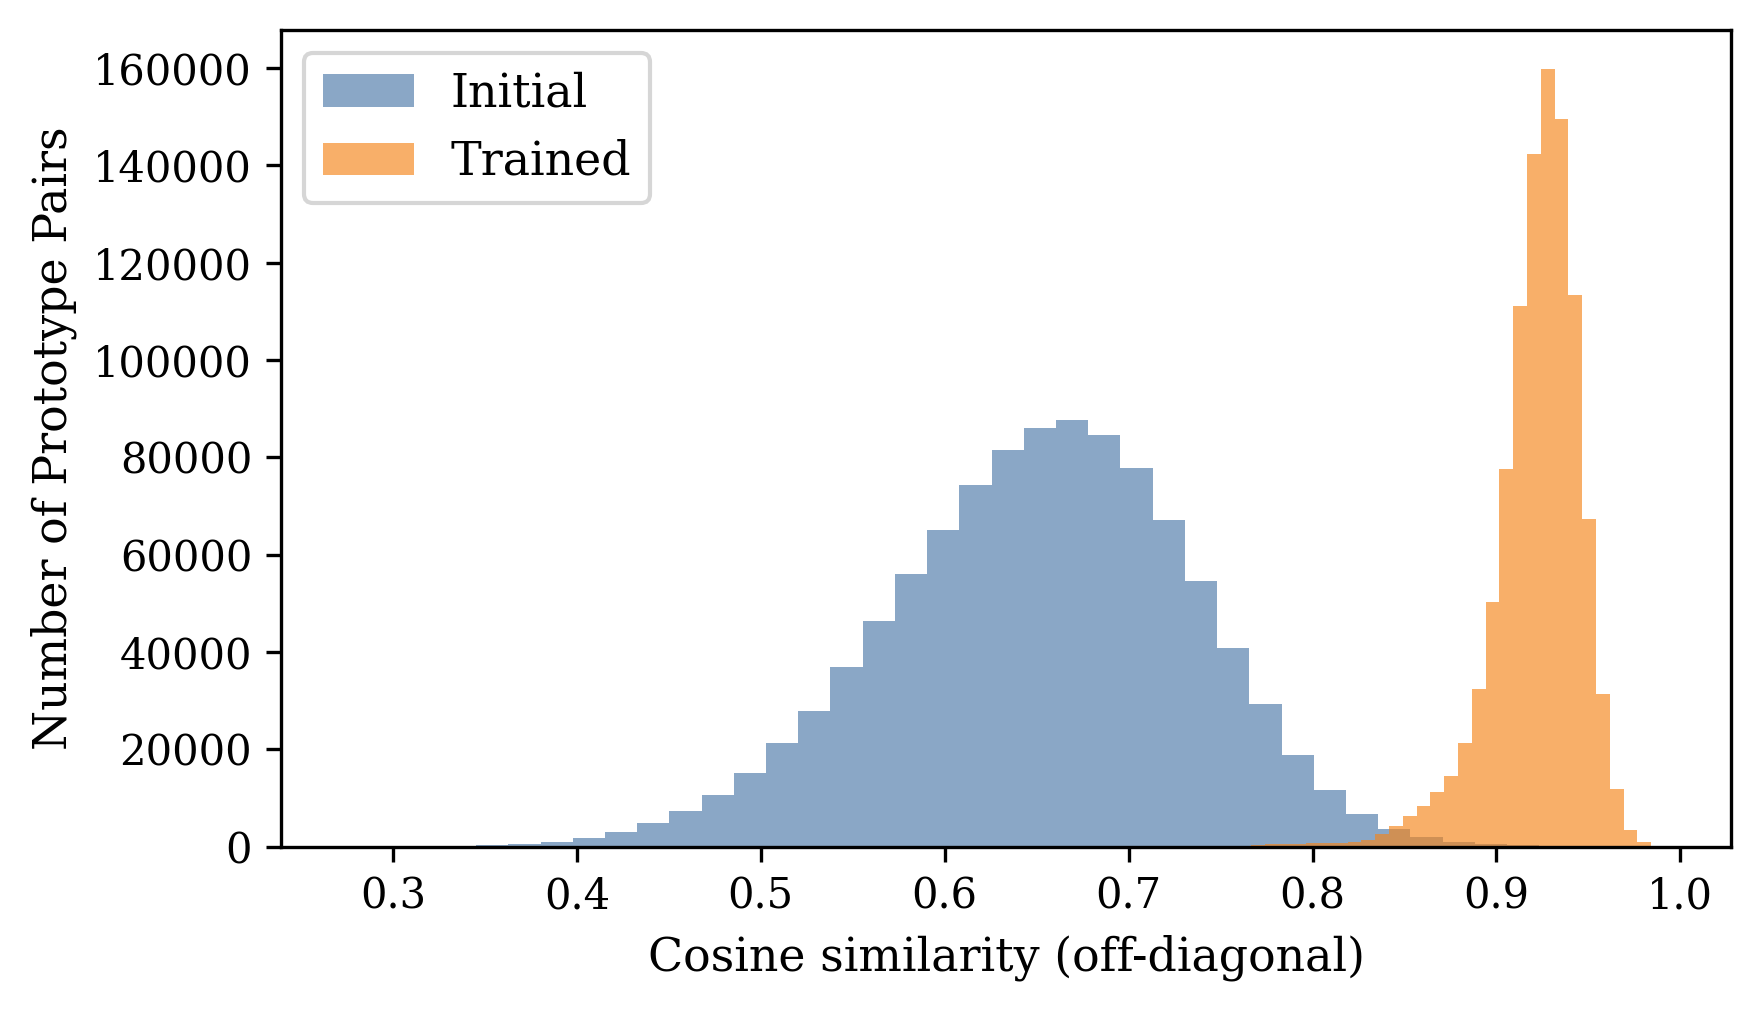

Cosine nearest-neighbour margin (‚Üë larger gaps)
Initial: mean=0.1299, median=0.1210
Trained: mean=0.0299, median=0.0268


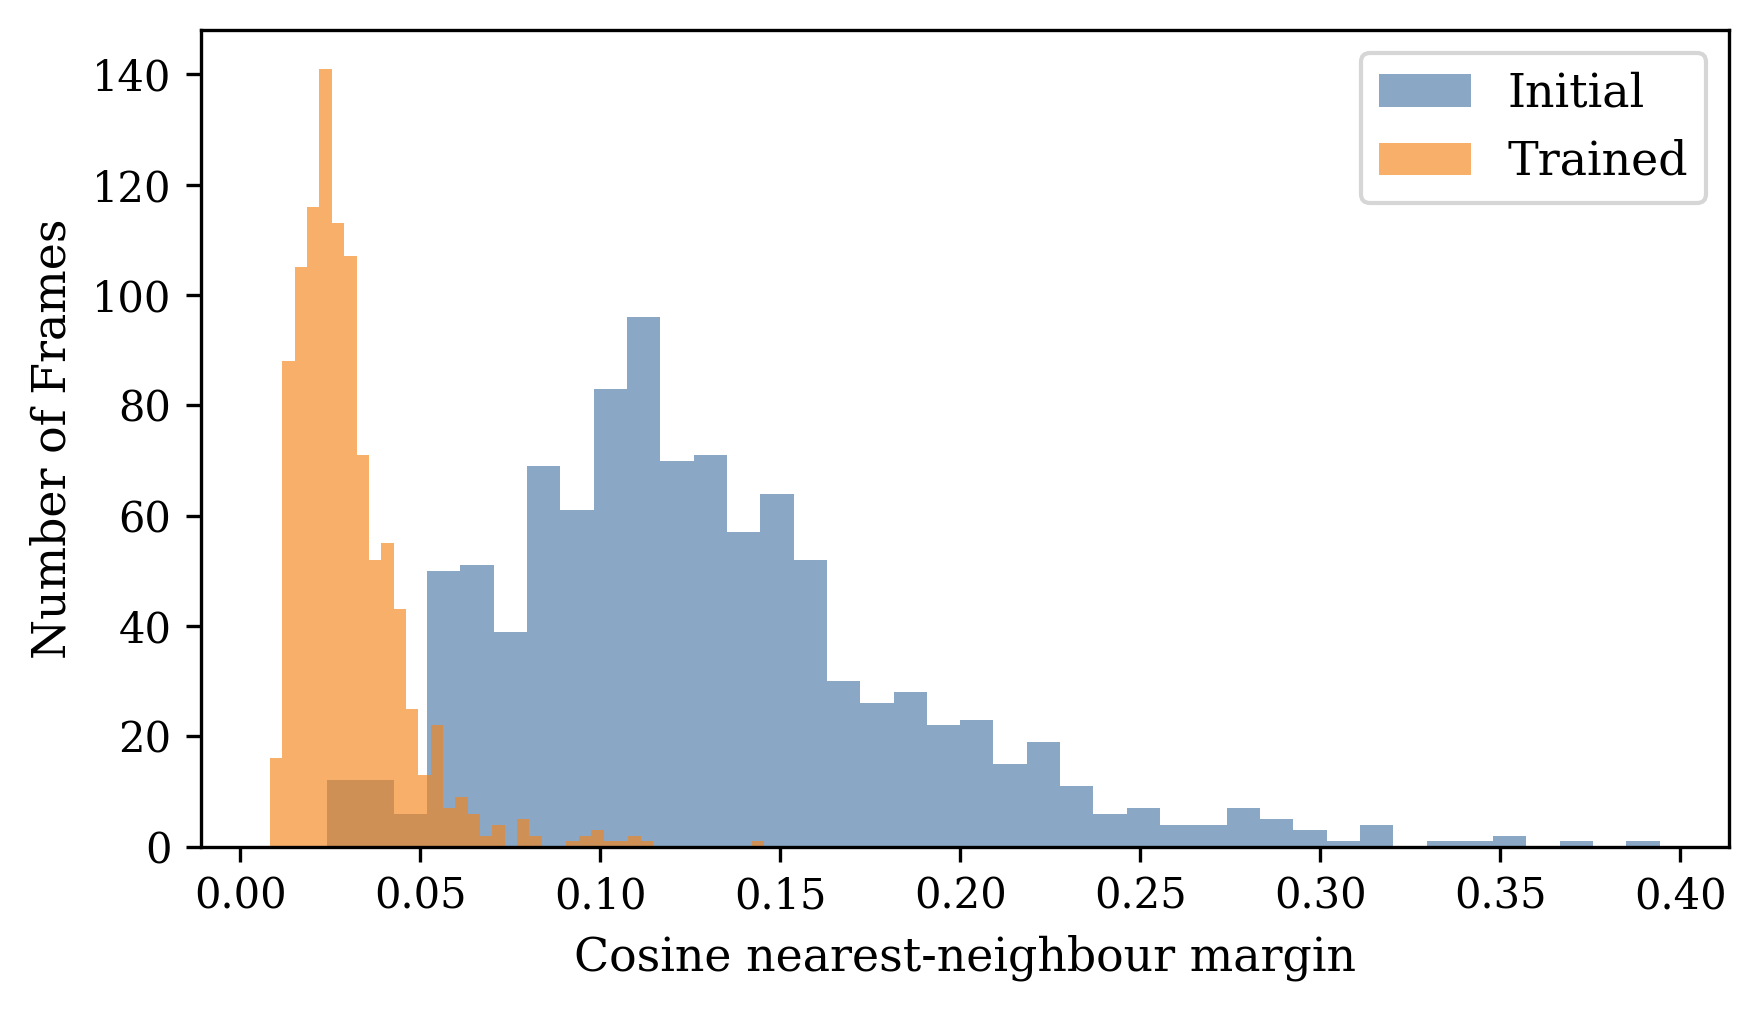

In [15]:
# -*- coding: utf-8 -*-
# Visualization: prototype geometry before vs after training (cosine-based)
# Figure 11: Inter-class cosine similarity (‚Üì better separation)
# Figure 12: Cosine nearest-neighbour margin (‚Üë larger margin)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# ======= CONFIG =======
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300
})

COL_INIT   = "#4C78A8"
COL_TRAIN  = "#F58518"
ALPHA      = 0.65
BINS       = 40

# ======= Utils =======
def offdiag_cosine_values(X: np.ndarray):
    """Off-diagonal cosine similarity stats."""
    S = cosine_similarity(X)
    mask = ~np.eye(len(X), dtype=bool)
    vals = S[mask]
    stats = {
        "mean":   float(np.mean(vals)),
        "median": float(np.median(vals)),
        "p90":    float(np.quantile(vals, 0.90)),
        "max":    float(np.max(vals)),
    }
    return stats, vals

def nn_gap_cosine(X: np.ndarray):
    """Cosine NN margin = 1 ‚àí max_{j ‚â† i} cos(x_i, x_j)."""
    S = cosine_similarity(X)
    np.fill_diagonal(S, -np.inf)
    nn_sim = np.max(S, axis=1)
    return 1.0 - nn_sim  # margin

# ======= Inputs =======
# init_mat = ...
# trn_mat  = ...

# 1) Off-diagonal cosine similarity (Figure 11)
init_stat, init_vals = offdiag_cosine_values(init_mat)
trn_stat,  trn_vals  = offdiag_cosine_values(trn_mat)

print("Off-diagonal cosine similarity (‚Üì better separation)")
print("Initial:", init_stat)
print("Trained:", trn_stat)

plt.figure(figsize=(6, 3.5))
plt.hist(init_vals, bins=BINS, alpha=ALPHA, color=COL_INIT, label="Initial")
plt.hist(trn_vals,  bins=BINS, alpha=ALPHA, color=COL_TRAIN, label="Trained")
plt.xlabel("Cosine similarity (off-diagonal)")
plt.ylabel("Number of Prototype Pairs")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()  # Figure 11

# 2) Cosine nearest-neighbour margin (Figure 12)
init_nn = nn_gap_cosine(init_mat)
trn_nn  = nn_gap_cosine(trn_mat)

print("Cosine nearest-neighbour margin (‚Üë larger gaps)")
print(f"Initial: mean={init_nn.mean():.4f}, median={np.median(init_nn):.4f}")
print(f"Trained: mean={trn_nn.mean():.4f}, median={np.median(trn_nn):.4f}")

plt.figure(figsize=(6, 3.5))
plt.hist(init_nn, bins=BINS, alpha=ALPHA, color=COL_INIT,  label="Initial")
plt.hist(trn_nn,  bins=BINS, alpha=ALPHA, color=COL_TRAIN, label="Trained")
plt.xlabel("Cosine nearest-neighbour margin")
plt.ylabel("Number of Frames")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()  # Figure 12



In [6]:
# @title ‚úÖ ‰∏ªËÆ≠ÁªÉÊ®°Âûã



class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """‰øùÊåÅÂéüÊù•ÁöÑÊ∏©Â∫¶Ë∞ÉÊï¥Á≠ñÁï•Ôºå‰∏çËÆæ‰∫∫‰∏∫‰∏ãÈôê"""
        if self.adaptive_temp:
            # ‰øùÊåÅÂéüÊù•ÁöÑcosË°∞ÂáèÂÖ¨Âºè
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device

        # Êõ¥Êñ∞Ê∏©Â∫¶
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        # ÊîπËøõÁöÑÂàÜÁ¶ªÊçüÂ§±ÔºöÊõ¥Ê∏©ÂíåÁöÑÊÉ©ÁΩö
        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            # ÂéªÈô§ÂØπËßíÁ∫øÔºåonlyÊÉ©ÁΩöÁõ∏‰ººÂ∫¶>0.4ÁöÑÂéüÂûãÂØπ
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }

class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'sentence': row['sentence'],
            'target_spans': row['target_spans'],
            'frame_name': row['frame_name']
        }

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }

def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\nÂàÜÂ±ÇËØÑ‰º∞:")
    groups = [
        ('Rich', 50, float('inf')),
        ('Medium', 20, 49),
        ('Poor', 10, 19),
        ('Very Poor', 0, 9)
    ]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")

class PostClusteringAnalyzer:
    """ËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûêÂô®"""

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def extract_all_embeddings(self, df, batch_size=64):
        """ÊèêÂèñÊâÄÊúâÊ†∑Êú¨ÁöÑembeddings"""
        print("\nÊèêÂèñËÆ≠ÁªÉÊ†∑Êú¨embeddingsÁî®‰∫éÂêéËÅöÁ±ªÂàÜÊûê...")

        frame_embeddings = defaultdict(list)
        self.model.eval()

        with torch.no_grad():
            for i in tqdm(range(0, len(df), batch_size), desc="ÊèêÂèñembeddings"):
                batch = df.iloc[i:i+batch_size]

                try:
                    # ‰ΩøÁî®Áé∞ÊúâÁöÑencodeÂáΩÊï∞
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        self.tokenizer, self.model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        frame_embeddings[frame_name].append(embs[j].cpu())

                except Exception as e:
                    print(f"ÊâπÊ¨°Â§ÑÁêÜÈîôËØØ: {e}")
                    continue

        # ËΩ¨Êç¢‰∏∫tensor
        processed_embeddings = {}
        for frame, emb_list in frame_embeddings.items():
            if emb_list:
                processed_embeddings[frame] = torch.stack(emb_list)

        print(f"ÊèêÂèñÂÆåÊàê: {len(processed_embeddings)} frames")
        return processed_embeddings

    def analyze_clustering_potential(self, frame_embeddings, min_samples=10):
        """ÂàÜÊûêÊØè‰∏™frameÁöÑËÅöÁ±ªÊΩúÂäõ"""
        print("\nÂàÜÊûêÂêÑframeËÅöÁ±ªÊΩúÂäõ...")

        clustering_analysis = {}

        for frame_name, embeddings in frame_embeddings.items():
            if len(embeddings) < min_samples:
                clustering_analysis[frame_name] = {
                    'optimal_clusters': 1,
                    'reason': f'Ê†∑Êú¨Â§™Â∞ë({len(embeddings)})',
                    'internal_similarity': 0.0,
                    'dbi_score': 0.0
                }
                continue

            # ËÆ°ÁÆóÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
            center = embeddings.mean(0)
            similarities = F.cosine_similarity(embeddings, center.unsqueeze(0))
            avg_similarity = similarities.mean().item()

            # Â∞ùËØï‰∏çÂêåÁöÑËÅöÁ±ªÊï∞Èáè
            best_k = 1
            best_dbi = float('inf')

            max_k = min(5, len(embeddings) // 10)  # ÊúÄÂ§ö5‰∏™Á∞á

            if max_k > 1:
                for k in range(2, max_k + 1):
                    try:
                        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
                        labels = kmeans.fit_predict(embeddings.numpy())

                        # ËÆ°ÁÆóDBI
                        dbi = davies_bouldin_score(embeddings.numpy(), labels)

                        if dbi < best_dbi:
                            best_dbi = dbi
                            best_k = k

                    except Exception:
                        continue

            # ÂÜ≥Á≠ñÈÄªËæëÔºöÂÜÖÈÉ®Áõ∏‰ººÂ∫¶‰Ωé‰∏îDBIÂêàÁêÜÊó∂ÊâçËÅöÁ±ª
            if avg_similarity < 0.7 and best_k > 1 and best_dbi < 2.0:
                optimal_k = best_k
                reason = f'ÂÜÖËÅöÂ∫¶‰Ωé({avg_similarity:.3f}), DBI={best_dbi:.3f}'
            else:
                optimal_k = 1
                reason = f'ÂÜÖËÅöÂ∫¶È´ò({avg_similarity:.3f})'

            clustering_analysis[frame_name] = {
                'optimal_clusters': optimal_k,
                'reason': reason,
                'internal_similarity': avg_similarity,
                'dbi_score': best_dbi,
                'sample_count': len(embeddings)
            }

        return clustering_analysis

    def create_clustered_prototypes(self, frame_embeddings, clustering_analysis):
        """Âü∫‰∫éËÅöÁ±ªÂàÜÊûêÂàõÂª∫Êñ∞ÂéüÂûã"""
        print("\nÂü∫‰∫éËÅöÁ±ªÂàÜÊûêÂàõÂª∫Â§öÂéüÂûã...")

        new_prototypes = {}
        multi_prototype_count = 0

        for frame_name, embeddings in frame_embeddings.items():
            analysis = clustering_analysis[frame_name]
            optimal_k = analysis['optimal_clusters']

            if optimal_k == 1:
                # ÂçïÂéüÂûãÔºö‰ΩøÁî®‰∏≠ÂøÉÂåñÁöÑÂπ≥Âùá
                new_prototypes[frame_name] = self._create_robust_prototype(embeddings)
            else:
                # Â§öÂéüÂûãÔºöËÅöÁ±ªÂêéÊØè‰∏™Á∞á‰∏Ä‰∏™ÂéüÂûã
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(embeddings.numpy())

                sub_prototypes = []
                for cluster_id in range(optimal_k):
                    cluster_mask = labels == cluster_id
                    if cluster_mask.sum() > 0:
                        cluster_embeddings = embeddings[cluster_mask]
                        prototype = self._create_robust_prototype(cluster_embeddings)
                        sub_prototypes.append(prototype)

                if sub_prototypes:
                    new_prototypes[frame_name] = sub_prototypes
                    multi_prototype_count += 1
                    print(f"   {frame_name}: {len(sub_prototypes)}‰∏™Â≠êÂéüÂûã "
                          f"({analysis['sample_count']}Ê†∑Êú¨, {analysis['reason']})")
                else:
                    # ËÅöÁ±ªÂ§±Ë¥•ÔºåÂõûÈÄÄÂà∞ÂçïÂéüÂûã
                    new_prototypes[frame_name] = self._create_robust_prototype(embeddings)

        print(f"Â§öÂéüÂûãÂàõÂª∫ÂÆåÊàê: {multi_prototype_count} frames‰ΩøÁî®Â§öÂéüÂûã")
        return new_prototypes

    def _create_robust_prototype(self, embeddings):
        """ÂàõÂª∫È≤ÅÊ£íÁöÑÂéüÂûãÔºàÂºÇÂ∏∏ÂÄºËøáÊª§Ôºâ"""
        if len(embeddings) <= 3:
            return embeddings.mean(0)

        # ÂºÇÂ∏∏ÂÄºËøáÊª§ÔºöÁßªÈô§Ë∑ùÁ¶ª‰∏≠ÂøÉÊúÄËøúÁöÑ20%
        center = embeddings.mean(0)
        distances = torch.norm(embeddings - center, dim=1)
        keep_ratio = 0.8
        keep_num = max(1, int(len(embeddings) * keep_ratio))

        _, keep_indices = torch.topk(distances, keep_num, largest=False)
        filtered_embeddings = embeddings[keep_indices]

        return filtered_embeddings.mean(0)

class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # ‰ΩøÁî®‰ºòÂåñÁöÑÊçüÂ§±ÂáΩÊï∞ - ‰øùÊåÅÂéüÊù•ÁöÑËÆæËÆ°
        self.criterion = OptimizedPrototypeLossWithSeparation(
            initial_temperature=0.1,
            sep_weight=0.15,          # ‰øùÊåÅÂéüÊù•ÁöÑÊùÉÈáç
            adaptive_temp=True        # ‰∏çËÆæÁΩÆmin_tempÈôêÂà∂
        )

        self.prototypes = {}
        self.best_val = 0
        self.save_dir = save_dir
        self.best_model_path = None

        # ÂàõÂª∫‰øùÂ≠òÁõÆÂΩï
        os.makedirs(save_dir, exist_ok=True)

        # ÂêéËÅöÁ±ªÂàÜÊûêÂô®
        self.clustering_analyzer = PostClusteringAnalyzer(self.model, self.tokenizer)

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        """‰øùÂ≠òÊ£ÄÊü•ÁÇπ"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'best_val_acc': self.best_val,
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }

        if is_best:
            # ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò
            save_path = f"{self.save_dir}/best_model.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"  ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path
        else:
            # ÂÆöÊúüÊ£ÄÊü•ÁÇπ‰øùÂ≠ò
            save_path = f"{self.save_dir}/checkpoint_epoch{epoch}.pt"
            torch.save(checkpoint, save_path)
            print(f"  Ê£ÄÊü•ÁÇπÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path

    def load_checkpoint(self, checkpoint_path):
        """Âä†ËΩΩÊ£ÄÊü•ÁÇπ"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.prototypes = checkpoint['prototypes']
        self.best_val = checkpoint['best_val_acc']

        # ÊÅ¢Â§çÊçüÂ§±ÂáΩÊï∞Áä∂ÊÄÅ
        if 'criterion_state' in checkpoint:
            criterion_state = checkpoint['criterion_state']
            self.criterion.current_temperature = criterion_state['current_temperature']
            self.criterion.initial_temperature = criterion_state['initial_temperature']
            self.criterion.sep_weight = criterion_state['sep_weight']

        print(f"Â∑≤Âä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
        print(f"   ÊÅ¢Â§çepoch: {checkpoint['epoch']}, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {self.best_val:.4f}")
        return checkpoint['epoch']

    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3,
              save_every=2):

        # ÂàùÂßãÊûÑÂª∫ÂçïÂéüÂûã
        self.build_prototypes(train_df)

        # ‰ºòÂåñÂô®ËÆæÁΩÆ - ÊÅ¢Â§çÂà∞Êõ¥ÁßØÊûÅÁöÑÂèÇÊï∞ÔºåÂõ†‰∏∫Ê®°ÂûãÂú®ËøõÊ≠•
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,  # ÊÅ¢Â§çÂéüÊù•ÁöÑÊùÉÈáçË°∞Âáè
            eps=1e-6
        )

        # ÊÅ¢Â§çÂéüÊù•ÁöÑÂ≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr * 0.1
        )

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn,
            # Ê∑ªÂä†Á°ÆÂÆöÊÄßÂèÇÊï∞
            generator=torch.Generator().manual_seed(42),  # Á°Æ‰øùshuffleÁöÑÂèØÈáçÁé∞ÊÄß
            num_workers=0  # ÈÅøÂÖçÂ§öËøõÁ®ãÂ∏¶Êù•ÁöÑÈöèÊú∫ÊÄß
        )

        patience_counter = 0

        print(f"\n" + "="*60)
        print(f"ÂºÄÂßãËÆ≠ÁªÉ - Â¢ûÂº∫‰øùÂ≠òÊú∫Âà∂")
        print(f"="*60)
        print(f"ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_df):,}")
        print(f"È™åËØÅÊ†∑Êú¨: {len(val_df):,}")
        print(f"FrameÊï∞Èáè: {len(train_counts):,}")
        print(f"‰øùÂ≠òÁõÆÂΩï: {self.save_dir}")
        print(f"ÊÄªËΩÆÊï∞: {epochs}, Êó©ÂÅúpatience: {patience}")

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}

            print(f"\n" + "-"*60)
            print(f"Epoch {ep+1:2d}/{epochs}")
            print(f"-"*60)
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )

                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )

                # Ê≠£Â∏∏ÁöÑÊ¢ØÂ∫¶Ë£ÅÂâ™
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # ËÆ∞ÂΩïÊØè‰∏™batchÁöÑÊçüÂ§±Áî®‰∫éËÆ°ÁÆóepochÂπ≥ÂùáÂÄº
                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()

            # ËÆ°ÁÆóepochÂπ≥ÂùáÊçüÂ§±
            avg_total_loss = np.mean(epoch_losses['total'])
            avg_ce_loss = np.mean(epoch_losses['cross_entropy'])
            avg_sep_loss = np.mean(epoch_losses['separation'])
            current_temp = loss_dict['temperature']  # Ê∏©Â∫¶ÊòØÂõ∫ÂÆöÁöÑÔºåÂèñÊúÄÂêé‰∏Ä‰∏™Âç≥ÂèØ

            print(f"ËÆ≠ÁªÉÊçüÂ§± - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | Ê∏©Â∫¶: {current_temp:.3f}")

            # ÂÆöÊúüÈáçÂª∫ÂéüÂûã
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # ËØÑ‰º∞
            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = result['top1_accuracy']
            print(f"È™åËØÅÂáÜÁ°ÆÁéá: {acc:.4f}")

            # ÂàÜÂ±ÇËØÑ‰º∞
            print(f"\nÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            # ‰øùÂ≠òÈÄªËæë
            is_best = acc > self.best_val

            # ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                print(f"‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã - ÂáÜÁ°ÆÁéá: {acc:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1

            # ÂÆöÊúüÊ£ÄÊü•ÁÇπ‰øùÂ≠ò
            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep+1, acc, avg_total_loss)

            # Êó©ÂÅúÊ£ÄÊü•
            if patience_counter >= patience:
                print(f"ËøûÁª≠{patience}ËΩÆÊó†ÊîπÂñÑÔºåÊèêÂâçÂÅúÊ≠¢")
                break

        # ÊúÄÁªà‰øùÂ≠ò
        final_save_path = f"{self.save_dir}/final_model_epoch{ep+1}_acc{acc:.4f}.pt"
        self.save_checkpoint(ep+1, acc, avg_total_loss)

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        if self.best_model_path and os.path.exists(self.best_model_path):
            print(f"\n" + "="*60)
            print(f"Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã: {self.best_model_path}")
            print(f"="*60)
            self.load_checkpoint(self.best_model_path)

        return self

    def build_prototypes(self, df):
        """ÊûÑÂª∫ÂéüÂûãÊó∂Â¢ûÂä†Á®≥ÂÆöÊÄß"""
        print(f"ÈáçÂª∫ÂéüÂûã‰∏≠...")
        frame2embeds = defaultdict(list)

        # ‰ΩøÁî®Áé∞ÊúâÁöÑÁºñÁ†ÅÂáΩÊï∞
        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  ÊâπÊ¨°Â§ÑÁêÜÂ§±Ë¥•: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue

            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])

            # Êõ¥È≤ÅÊ£íÁöÑÂéüÂûãÊûÑÂª∫
            if len(X) > 10:  # Ê†∑Êú¨Â§öÊó∂ËøõË°åÂºÇÂ∏∏ÂÄºËøáÊª§
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85  # ‰øùÁïô85%ÁöÑÊï∞ÊçÆ
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]

            self.prototypes[f] = X.mean(0)

        print(f"ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: {len(self.prototypes)} frames")

    def post_training_clustering(self, train_df):
        """ËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûê"""
        print(f"\n" + "="*50)
        print("Á¨¨‰∫åÈò∂ÊÆµÔºöËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûê")
        print(f"="*50)

        # ÊèêÂèñÊâÄÊúâembeddings
        frame_embeddings = self.clustering_analyzer.extract_all_embeddings(train_df)

        # ÂàÜÊûêËÅöÁ±ªÊΩúÂäõ
        clustering_analysis = self.clustering_analyzer.analyze_clustering_potential(frame_embeddings)

        # ÂàõÂª∫Â§öÂéüÂûã
        clustered_prototypes = self.clustering_analyzer.create_clustered_prototypes(
            frame_embeddings, clustering_analysis
        )

        return clustered_prototypes, clustering_analysis

# Á¨¨‰∏ÄÈò∂ÊÆµÔºöÂçïÂéüÂûãËÆ≠ÁªÉ
def run_first_stage_training():
    # Âú®ÂáΩÊï∞ÂºÄÂßãÊó∂ÂÜçÊ¨°ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠êÔºåÁ°Æ‰øùÁîüÊïà
    def set_seed(seed=42):
        import os
        import random
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    set_seed(42)  # Á°Æ‰øùÂú®ËÆ≠ÁªÉÂºÄÂßãÂâçÂÜçÊ¨°ËÆæÁΩÆ

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")
    print(f"ÈöèÊú∫ÁßçÂ≠êÂ∑≤ËÆæÁΩÆ: 42")

    # Âä†ËΩΩÊï∞ÊçÆ
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\nÊï∞ÊçÆÂä†ËΩΩÂÆåÊàê:")
    print(f"ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_df):,}")
    print(f"È™åËØÅÊ†∑Êú¨: {len(val_df):,}")
    print(f"FrameÊï∞Èáè: {len(train_df['frame_name'].unique()):,}")

    # ÂàõÂª∫Â≠¶‰π†Âô®
    learner = OptimizedPrototypeLearner(device)

    # Ê£ÄÊü•ÊòØÂê¶Êúâ‰πãÂâçÁöÑÊ£ÄÊü•ÁÇπ
    checkpoint_dir = learner.save_dir
    if os.path.exists(f"{checkpoint_dir}/best_model.pt"):
        print(f"\nÂèëÁé∞Â∑≤ÊúâÊúÄ‰Ω≥Ê®°Âûã")

    try:
        # Á¨¨‰∏ÄÈò∂ÊÆµÔºöÂçïÂéüÂûãËÆ≠ÁªÉ
        print(f"\n" + "="*60)
        print(f"="*60)
        learner.train(
            train_df, val_df,
            epochs=25,
            lr=1e-5,
            rebuild_every=2,
            patience=3,
            save_every=2
        )

    except KeyboardInterrupt:
        print(f"\nËÆ≠ÁªÉË¢´‰∏≠Êñ≠Ôºå‰ΩÜÂ∑≤‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂‰∏ç‰ºö‰∏¢Â§±")
        if learner.best_model_path:
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãË∑ØÂæÑ: {learner.best_model_path}")
        return learner

    except Exception as e:
        print(f"\nËÆ≠ÁªÉÂá∫Èîô: {e}")
        if learner.best_model_path:
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {learner.best_model_path}")
        return learner

    # Á¨¨‰∏ÄÈò∂ÊÆµÁªìÊûúËØÑ‰º∞
    baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    baseline_acc = baseline_result['top1_accuracy']
    print(f"\n" + "="*60)
    print(f"Á¨¨‰∏ÄÈò∂ÊÆµÁªìÊûú - ÂçïÂéüÂûãTop-1ÂáÜÁ°ÆÁéá: {baseline_acc:.4f}")
    print(f"="*60)

    # ‰øùÂ≠òÁ¨¨‰∏ÄÈò∂ÊÆµÁªìÊûú
    first_stage_save_path = f"{learner.save_dir}/first_stage_complete.pt"
    torch.save({
        'model_state_dict': learner.model.state_dict(),
        'prototypes': learner.prototypes,
        'baseline_accuracy': baseline_acc,
        'training_config': {
            'epochs': 25,
            'lr': 1e-5,
            'temperature': learner.criterion.initial_temperature,
            'sep_weight': learner.criterion.sep_weight
        }
    }, first_stage_save_path)

    print(f"Á¨¨‰∏ÄÈò∂ÊÆµÂÆåÊï¥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {first_stage_save_path}")
    return learner

# Á¨¨‰∫åÈò∂ÊÆµÔºöÂêéËÅöÁ±ªÂàÜÊûê
def run_second_stage_clustering(learner=None, first_stage_model_path=None):
    """
    ËøêË°åÁ¨¨‰∫åÈò∂ÊÆµËÅöÁ±ªÂàÜÊûê
    Args:
        learner: Á¨¨‰∏ÄÈò∂ÊÆµËÆ≠ÁªÉÂÆåÊàêÁöÑlearnerÂØπË±°
        first_stage_model_path: Â¶ÇÊûúlearner‰∏∫NoneÔºå‰ªéÊ≠§Ë∑ØÂæÑÂä†ËΩΩÁ¨¨‰∏ÄÈò∂ÊÆµÊ®°Âûã
    """

    # Â¶ÇÊûúÊ≤°Êúâ‰º†ÂÖ•learnerÔºåÂàô‰ªéÊñá‰ª∂Âä†ËΩΩ
    if learner is None:
        if first_stage_model_path is None:
            first_stage_model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/first_stage_complete.pt"

        print(f"‰ªéÊñá‰ª∂Âä†ËΩΩÁ¨¨‰∏ÄÈò∂ÊÆµÊ®°Âûã: {first_stage_model_path}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        learner = OptimizedPrototypeLearner(device)

        # Âä†ËΩΩÁ¨¨‰∏ÄÈò∂ÊÆµÊ®°Âûã
        checkpoint = torch.load(first_stage_model_path, map_location=device)
        learner.model.load_state_dict(checkpoint['model_state_dict'])
        learner.prototypes = checkpoint['prototypes']
        baseline_acc = checkpoint['baseline_accuracy']
        print(f"Á¨¨‰∏ÄÈò∂ÊÆµÂáÜÁ°ÆÁéá: {baseline_acc:.4f}")
    else:
        # ‰ªéÁ¨¨‰∏ÄÈò∂ÊÆµËé∑ÂèñÂü∫ÂáÜÂáÜÁ°ÆÁéá
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
        baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        baseline_acc = baseline_result['top1_accuracy']

    # Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÁî®‰∫éËÅöÁ±ªÂàÜÊûê
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    try:
        print(f"\n" + "="*60)
        print(f"Á¨¨‰∫åÈò∂ÊÆµÔºöËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûê")
        print(f"="*60)
        clustered_prototypes, clustering_analysis = learner.post_training_clustering(train_df)

        # Êõ¥Êñ∞ÂéüÂûãÂπ∂ËØÑ‰º∞
        original_prototypes = learner.prototypes.copy()  # ‰øùÂ≠òÂéüÂßãÂçïÂéüÂûã
        learner.prototypes = clustered_prototypes

        # Á¨¨‰∫åÈò∂ÊÆµÁªìÊûúËØÑ‰º∞
        final_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        final_acc = final_result['top1_accuracy']

        print(f"\n" + "="*60)
        print(f"ÊúÄÁªàÁªìÊûúÂØπÊØî:")
        print(f"ÂçïÂéüÂûãÈò∂ÊÆµ: {baseline_acc:.4f}")
        print(f"Â§öÂéüÂûãÈò∂ÊÆµ: {final_acc:.4f}")
        print(f"ÊèêÂçáÂπÖÂ∫¶: {final_acc - baseline_acc:+.4f}")
        print(f"="*60)

        # ËÅöÁ±ªÂàÜÊûêÊä•Âëä
        multi_prototype_frames = sum(1 for analysis in clustering_analysis.values()
                                   if analysis['optimal_clusters'] > 1)
        print(f"\nËÅöÁ±ªÂàÜÊûêÊä•Âëä:")
        print(f"Â§öÂéüÂûãframes: {multi_prototype_frames}/{len(clustering_analysis)}")

        # ‰øùÂ≠òÊúÄÁªàÂÆåÊï¥Ê®°Âûã
        final_save_path = f"{learner.save_dir}/complete_model_final.pt"
        torch.save({
            'model_state_dict': learner.model.state_dict(),
            'single_prototypes': original_prototypes,  # ‰øùÂ≠òÂéüÂßãÂçïÂéüÂûã
            'clustered_prototypes': clustered_prototypes,
            'clustering_analysis': clustering_analysis,
            'baseline_accuracy': baseline_acc,
            'final_accuracy': final_acc,
            'training_config': {
                'epochs': 25,
                'lr': 1e-5,
                'temperature': learner.criterion.initial_temperature,
                'sep_weight': learner.criterion.sep_weight
            }
        }, final_save_path)

        print(f"ÂÆåÊï¥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {final_save_path}")
        return learner, clustering_analysis

    except Exception as e:
        print(f"ÂêéËÅöÁ±ªÂàÜÊûêÂ§±Ë¥•: {e}")
        return learner, None

# ÂÆåÊï¥ÊµÅÁ®ãÔºàÂ¶ÇÊûú‰Ω†ÊÉ≥‰∏ÄÊ¨°ËøêË°åÂÆåÔºâ
def run_complete_training():
    """ËøêË°åÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµËÆ≠ÁªÉ"""
    print("ÂºÄÂßãÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµËÆ≠ÁªÉÊµÅÁ®ã")

    # Á¨¨‰∏ÄÈò∂ÊÆµ
    learner = run_first_stage_training()

    # Á¨¨‰∫åÈò∂ÊÆµ
    learner, analysis = run_second_stage_clustering(learner)

    return learner, analysis

In [ ]:
# @title ‚úÖ ËøêË°å‰∏ªËÆ≠ÁªÉÂáΩÊï∞

learner, analysis = run_complete_training()

ÂºÄÂßãÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµËÆ≠ÁªÉÊµÅÁ®ã
‰ΩøÁî®ËÆæÂ§á: cuda
ÈöèÊú∫ÁßçÂ≠êÂ∑≤ËÆæÁΩÆ: 42

Êï∞ÊçÆÂä†ËΩΩÂÆåÊàê:
ËÆ≠ÁªÉÊ†∑Êú¨: 150,168
È™åËØÅÊ†∑Êú¨: 25,104
FrameÊï∞Èáè: 1,014

ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 326.31it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames

ÂºÄÂßãËÆ≠ÁªÉ - Â¢ûÂº∫‰øùÂ≠òÊú∫Âà∂
ËÆ≠ÁªÉÊ†∑Êú¨: 150,168
È™åËØÅÊ†∑Êú¨: 25,104
FrameÊï∞Èáè: 1,014
‰øùÂ≠òÁõÆÂΩï: /content/drive/MyDrive/more50/framenet_data/checkpoints
ÊÄªËΩÆÊï∞: 25, Êó©ÂÅúpatience: 3

------------------------------------------------------------
Epoch  1/25
------------------------------------------------------------


ËÆ≠ÁªÉÊçüÂ§± - Total: 1.0742 | CE: 1.0385 | Sep: 0.2383 | Ê∏©Â∫¶: 0.100
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.1838
Top-3ÂáÜÁ°ÆÁéá: 0.2900
Macro F1: 0.0382
Weighted F1: 0.1308
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.1838

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.1951
Top-3ÂáÜÁ°ÆÁéá: 0.3075
Macro F1: 0.0612
Weighted F1: 0.1405
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.195 | Macro F1: 0.061
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.0027
Top-3ÂáÜÁ°ÆÁéá: 0.0072
Macro F1: 0.0023
Weighted F1: 0.00

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.3039 | CE: 0.2681 | Sep: 0.2383 | Ê∏©Â∫¶: 0.100
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 317.37it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8619
Top-3ÂáÜÁ°ÆÁéá: 0.9608
Macro F1: 0.7633
Weighted F1: 0.8714
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.8619

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8617
Top-3ÂáÜÁ°ÆÁéá: 0.9616
Macro F1: 0.5957
Weighted F1: 0.8804
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.862 | Macro F1: 0.596
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8591
Top-3ÂáÜÁ°ÆÁéá: 0.9449
Macro F1: 0.6615
Weighted F1: 0.8934
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.3030 | CE: 0.2167 | Sep: 0.5752 | Ê∏©Â∫¶: 0.099
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9085
Top-3ÂáÜÁ°ÆÁéá: 0.9822
Macro F1: 0.8344
Weighted F1: 0.9120
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9085

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9119
Top-3ÂáÜÁ°ÆÁéá: 0.9832
Macro F1: 0.7292
Weighted F1: 0.9205
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.912 | Macro F1: 0.729
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8699
Top-3ÂáÜÁ°ÆÁéá: 0.9666
Macro F1: 0.6685
Weighted F1: 0.90

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1756 | CE: 0.0893 | Sep: 0.5752 | Ê∏©Â∫¶: 0.097
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 325.71it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9173
Top-3ÂáÜÁ°ÆÁéá: 0.9831
Macro F1: 0.8400
Weighted F1: 0.9207
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9173

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9182
Top-3ÂáÜÁ°ÆÁéá: 0.9837
Macro F1: 0.7005
Weighted F1: 0.9268
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.918 | Macro F1: 0.701
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9070
Top-3ÂáÜÁ°ÆÁéá: 0.9747
Macro F1: 0.7310
Weighted F1: 0.9300
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.2352 | CE: 0.1751 | Sep: 0.4008 | Ê∏©Â∫¶: 0.095
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5554
Top-3ÂáÜÁ°ÆÁéá: 0.7607
Macro F1: 0.5425
Weighted F1: 0.6304
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.5554

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5556
Top-3ÂáÜÁ°ÆÁéá: 0.7614
Macro F1: 0.4778
Weighted F1: 0.6383
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.556 | Macro F1: 0.478
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5285
Top-3ÂáÜÁ°ÆÁéá: 0.7326
Macro F1: 0.4670
Weighted F1: 0.60

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1353 | CE: 0.0752 | Sep: 0.4008 | Ê∏©Â∫¶: 0.092
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 321.14it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9247
Top-3ÂáÜÁ°ÆÁéá: 0.9834
Macro F1: 0.8524
Weighted F1: 0.9278
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9247

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9265
Top-3ÂáÜÁ°ÆÁéá: 0.9843
Macro F1: 0.7220
Weighted F1: 0.9344
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.926 | Macro F1: 0.722
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9015
Top-3ÂáÜÁ°ÆÁéá: 0.9675
Macro F1: 0.7294
Weighted F1: 0.9262
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1227 | CE: 0.0422 | Sep: 0.5370 | Ê∏©Â∫¶: 0.089
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9222
Top-3ÂáÜÁ°ÆÁéá: 0.9818
Macro F1: 0.8519
Weighted F1: 0.9246
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9222

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9247
Top-3ÂáÜÁ°ÆÁéá: 0.9826
Macro F1: 0.7480
Weighted F1: 0.9313
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.925 | Macro F1: 0.748
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8997
Top-3ÂáÜÁ°ÆÁéá: 0.9720
Macro F1: 0.7128
Weighted F1: 0.92

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1149 | CE: 0.0344 | Sep: 0.5370 | Ê∏©Â∫¶: 0.085
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 315.60it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9273
Top-3ÂáÜÁ°ÆÁéá: 0.9841
Macro F1: 0.8559
Weighted F1: 0.9303
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9273

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9286
Top-3ÂáÜÁ°ÆÁéá: 0.9849
Macro F1: 0.7279
Weighted F1: 0.9364
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.929 | Macro F1: 0.728
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9178
Top-3ÂáÜÁ°ÆÁéá: 0.9720
Macro F1: 0.7484
Weighted F1: 0.9390
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1124 | CE: 0.0412 | Sep: 0.4750 | Ê∏©Â∫¶: 0.081
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8340
Top-3ÂáÜÁ°ÆÁéá: 0.9380
Macro F1: 0.7758
Weighted F1: 0.8565
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.8340

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8343
Top-3ÂáÜÁ°ÆÁéá: 0.9382
Macro F1: 0.6619
Weighted F1: 0.8643
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.834 | Macro F1: 0.662
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8311
Top-3ÂáÜÁ°ÆÁéá: 0.9341
Macro F1: 0.6420
Weighted F1: 0.87

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1030 | CE: 0.0318 | Sep: 0.4750 | Ê∏©Â∫¶: 0.077
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 322.50it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9278
Top-3ÂáÜÁ°ÆÁéá: 0.9833
Macro F1: 0.8577
Weighted F1: 0.9306
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9278

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9297
Top-3ÂáÜÁ°ÆÁéá: 0.9841
Macro F1: 0.7277
Weighted F1: 0.9374
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.728
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9042
Top-3ÂáÜÁ°ÆÁéá: 0.9702
Macro F1: 0.7326
Weighted F1: 0.9293
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1030 | CE: 0.0229 | Sep: 0.5338 | Ê∏©Â∫¶: 0.072
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9189
Top-3ÂáÜÁ°ÆÁéá: 0.9797
Macro F1: 0.8487
Weighted F1: 0.9221
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9189

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9212
Top-3ÂáÜÁ°ÆÁéá: 0.9804
Macro F1: 0.7335
Weighted F1: 0.9291
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.921 | Macro F1: 0.734
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8907
Top-3ÂáÜÁ°ÆÁéá: 0.9693
Macro F1: 0.6948
Weighted F1: 0.91

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1015 | CE: 0.0214 | Sep: 0.5338 | Ê∏©Â∫¶: 0.067
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 320.27it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9282
Top-3ÂáÜÁ°ÆÁéá: 0.9830
Macro F1: 0.8615
Weighted F1: 0.9307
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9282

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9301
Top-3ÂáÜÁ°ÆÁéá: 0.9838
Macro F1: 0.7416
Weighted F1: 0.9370
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.742
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9051
Top-3ÂáÜÁ°ÆÁéá: 0.9693
Macro F1: 0.7335
Weighted F1: 0.9297
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1014 | CE: 0.0231 | Sep: 0.5219 | Ê∏©Â∫¶: 0.063
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8996
Top-3ÂáÜÁ°ÆÁéá: 0.9665
Macro F1: 0.8267
Weighted F1: 0.9068
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.8996

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9024
Top-3ÂáÜÁ°ÆÁéá: 0.9676
Macro F1: 0.7201
Weighted F1: 0.9147
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.902 | Macro F1: 0.720
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8618
Top-3ÂáÜÁ°ÆÁéá: 0.9494
Macro F1: 0.6738
Weighted F1: 0.89

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.0966 | CE: 0.0183 | Sep: 0.5219 | Ê∏©Â∫¶: 0.057
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 321.05it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9274
Top-3ÂáÜÁ°ÆÁéá: 0.9812
Macro F1: 0.8493
Weighted F1: 0.9305
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9274

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9297
Top-3ÂáÜÁ°ÆÁéá: 0.9822
Macro F1: 0.7323
Weighted F1: 0.9374
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.732
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9042
Top-3ÂáÜÁ°ÆÁéá: 0.9684
Macro F1: 0.7382
Weighted F1: 0.9274
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.0999 | CE: 0.0207 | Sep: 0.5281 | Ê∏©Â∫¶: 0.053
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9106
Top-3ÂáÜÁ°ÆÁéá: 0.9743
Macro F1: 0.8329
Weighted F1: 0.9182
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9106

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9128
Top-3ÂáÜÁ°ÆÁéá: 0.9749
Macro F1: 0.7116
Weighted F1: 0.9257
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.913 | Macro F1: 0.712
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8880
Top-3ÂáÜÁ°ÆÁéá: 0.9684
Macro F1: 0.7161
Weighted F1: 0.91

ÊèêÂèñembeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2347/2347 [05:15<00:00,  7.44it/s]


ÊèêÂèñÂÆåÊàê: 1014 frames

ÂàÜÊûêÂêÑframeËÅöÁ±ªÊΩúÂäõ...

Âü∫‰∫éËÅöÁ±ªÂàÜÊûêÂàõÂª∫Â§öÂéüÂûã...
Â§öÂéüÂûãÂàõÂª∫ÂÆåÊàê: 0 frames‰ΩøÁî®Â§öÂéüÂûã
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9254
Top-3ÂáÜÁ°ÆÁéá: 0.9804
Macro F1: 0.8425
Weighted F1: 0.9289
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104

ÊúÄÁªàÁªìÊûúÂØπÊØî:
ÂçïÂéüÂûãÈò∂ÊÆµ: 0.9106
Â§öÂéüÂûãÈò∂ÊÆµ: 0.9254
ÊèêÂçáÂπÖÂ∫¶: +0.0149

ËÅöÁ±ªÂàÜÊûêÊä•Âëä:
Â§öÂéüÂûãframes: 0/1014
ÂÆåÊï¥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: /content/drive/MyDrive/more50/framenet_data/checkpoints/complete_model_final.pt


In [31]:
# ============================================
#  @title ‚úÖ Prototype Learner (single-stage, no clustering)

# - Save ALL checkpoints each epoch; pick best at the end
# - Paths & hyperparams configurable at the bottom
# ============================================

# -----------------------------
# Loss with prototype separation
# -----------------------------
class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """Keep the original cosine decay schedule (no manual lower bound)."""
        if self.adaptive_temp:
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device

        # Update temperature
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        # Softer separation penalty among prototypes
        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            # Penalise only pairs with similarity > 0.4 (exclude diagonal)
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }


# -----------------------------
# Minimal dataset & collate
# -----------------------------
class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'sentence': row['sentence'],
            'target_spans': row['target_spans'],
            'frame_name': row['frame_name']
        }

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }


# -----------------------------
# Stratified evaluation helper
# -----------------------------
def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\nStratified evaluation:")
    groups = [
        ('Rich', 50, float('inf')),
        ('Medium', 20, 49),
        ('Poor', 10, 19),
        ('Very Poor', 0, 9)
    ]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")


# -----------------------------
# Prototype learner (single-stage)
# -----------------------------
class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Loss (unchanged behaviour)
        self.criterion = OptimizedPrototypeLossWithSeparation(
            initial_temperature=0.1,
            sep_weight=0.15,
            adaptive_temp=True
        )

        self.prototypes = {}
        self.best_val = 0.0
        self.save_dir = save_dir
        self.best_model_path = None

        os.makedirs(save_dir, exist_ok=True)

    # --- Checkpointing: save ALL, pick best at the end ---
    def save_checkpoint(self, epoch, val_acc, loss):
        """
        Always save a checkpoint for this epoch. Filename encodes epoch & val acc.
        """
        ckpt_name = f"checkpoint_epoch{epoch:03d}_acc{val_acc:.4f}.pt"
        ckpt_path = os.path.join(self.save_dir, ckpt_name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }
        torch.save(checkpoint, ckpt_path)
        print(f"  Saved checkpoint: {ckpt_path}")
        return ckpt_path

    @staticmethod
    def _parse_acc_from_name(filename):
        m = re.search(r"_acc([0-9]+\.[0-9]+)\.pt$", filename)
        return float(m.group(1)) if m else None

    def find_best_checkpoint(self):
        """
        Scan save_dir and return path to checkpoint with highest val_acc.
        Skip files that can't be parsed or loaded.
        """
        best_path, best_acc = None, -1.0
        for fn in os.listdir(self.save_dir):
            if not fn.endswith(".pt"):
                continue
            acc = self._parse_acc_from_name(fn)
            if acc is None:
                continue
            if acc > best_acc:
                best_acc = acc
                best_path = os.path.join(self.save_dir, fn)
        return best_path, best_acc

    def load_checkpoint(self, checkpoint_path):
        """Load a given checkpoint (skip gracefully on failure)."""
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint.get('prototypes', {})
            self.best_val = float(checkpoint.get('val_acc', 0.0))
            # Restore criterion state (optional)
            crit = checkpoint.get('criterion_state', {})
            if crit:
                self.criterion.current_temperature = crit.get('current_temperature', self.criterion.current_temperature)
                self.criterion.initial_temperature = crit.get('initial_temperature', self.criterion.initial_temperature)
                self.criterion.sep_weight = crit.get('sep_weight', self.criterion.sep_weight)
            print(f"Loaded checkpoint: {checkpoint_path} | epoch={checkpoint.get('epoch', '?')}, val_acc={self.best_val:.4f}")
            return True
        except Exception as e:
            print(f"‚ö†Ô∏è  Failed to load checkpoint {checkpoint_path}: {e}")
            return False

    # ----- Training -----
    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3, save_every=1):
        # Initial prototypes
        self.build_prototypes(train_df)

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,
            eps=1e-6
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr * 0.1
        )

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn,
            generator=torch.Generator().manual_seed(42),
            num_workers=0
        )

        patience_counter = 0

        print("\n" + "="*60)
        print("Start training (single-stage)")
        print("="*60)
        print(f"Train samples: {len(train_df):,}")
        print(f"Val samples:   {len(val_df):,}")
        print(f"#Frames:       {len(train_counts):,}")
        print(f"Save dir:      {self.save_dir}")
        print(f"Epochs: {epochs}, Early-stop patience: {patience}")

        last_val_acc = 0.0

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}

            print("\n" + "-"*60)
            print(f"Epoch {ep+1:2d}/{epochs}")
            print("-"*60)
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )

                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()

            avg_total_loss = float(np.mean(epoch_losses['total']))
            avg_ce_loss = float(np.mean(epoch_losses['cross_entropy']))
            avg_sep_loss = float(np.mean(epoch_losses['separation']))
            current_temp = loss_dict['temperature']
            print(f"Train loss - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | Temp: {current_temp:.3f}")

            # Periodically rebuild prototypes
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # Validation
            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = float(result['top1_accuracy'])
            print(f"Val Top-1 accuracy: {acc:.4f}")

            # Stratified report (optional)
            print("\nStratified report:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            # Save checkpoint every epoch (or as configured)
            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep + 1, acc, avg_total_loss)

            # Early stopping counter
            if acc > self.best_val:
                self.best_val = acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"No improvement for {patience} consecutive epochs. Early stopping.")
                break

            last_val_acc = acc

        # Save a final checkpoint at training end
        self.save_checkpoint(ep + 1, last_val_acc, avg_total_loss)

        # Pick best checkpoint at the end and load it (skip on failure)
        print("\n" + "="*60)
        print("Selecting best checkpoint...")
        print("="*60)
        best_path, best_acc = self.find_best_checkpoint()
        if best_path is not None:
            print(f"Best found: {best_path} (val_acc={best_acc:.4f})")
            self.load_checkpoint(best_path)
            self.best_model_path = best_path
        else:
            print("‚ö†Ô∏è  No valid checkpoint found.")

        return self

    def build_prototypes(self, df):
        """Rebuild single prototype per frame with basic outlier trimming."""
        print("Rebuilding prototypes...")
        frame2embeds = defaultdict(list)

        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  Batch failed: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue
            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])

            # Robust mean: keep closest 85% if enough samples
            if len(X) > 10:
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]

            self.prototypes[f] = X.mean(0)

        print(f"Prototypes built: {len(self.prototypes)} frames")


# ============================================
# üîß Config & Run (edit paths here)
# ============================================
# Paths
# ===== Paths =====
FULL_PATH = "/content/drive/MyDrive/Open_sesame/framenet_data/framenet_data.pkl"  # fulltext full dataset path
TRAIN_PATH = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
VAL_PATH   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
TEST_PATH  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

SAVE_DIR   = "/content/drive/MyDrive/Open_sesame/framenet_data/checkpoints"
MODEL_NAME = "distilbert-base-uncased"

# Model & training
MODEL_NAME     = "distilbert-base-uncased"
EPOCHS         = 20
LR             = 1e-5
REBUILD_EVERY  = 1
PATIENCE       = 4
SAVE_EVERY     = 1

# Seed utils (optional but recommended)
def set_seed(seed=42):
    import random, os
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load data
train_df = pd.read_pickle(TRAIN_PATH)
val_df   = pd.read_pickle(VAL_PATH)
print(f"Loaded train_df: {train_df.shape}, val_df: {val_df.shape}")

# Train
learner = OptimizedPrototypeLearner(device, model_name=MODEL_NAME, save_dir=SAVE_DIR)
learner = learner.train(
    train_df, val_df,
    epochs=EPOCHS,
    lr=LR,
    rebuild_every=REBUILD_EVERY,
    patience=PATIENCE,
    save_every=SAVE_EVERY
)



# ===== Final evaluation on validation set =====
try:
    final_val_result = evaluate_target_known(
        learner.model, learner.tokenizer, val_df, learner.prototypes
    )
    print("\nFinal evaluation on Validation set:")
    print(json.dumps({
        "top1_accuracy": float(final_val_result["top1_accuracy"]),
        "top3_accuracy": float(final_val_result["top3_accuracy"]),
        "macro_f1": float(final_val_result["macro_f1"]),
        "weighted_f1": float(final_val_result["weighted_f1"])
    }, indent=2))
except Exception as e:
    print(f"‚ö†Ô∏è Validation evaluation skipped due to error: {e}")

# ===== Final evaluation on test set =====
try:
    final_test_result = evaluate_target_known(
        learner.model, learner.tokenizer, test_df, learner.prototypes
    )
    print("\nFinal evaluation on Test set:")
    print(json.dumps({
        "top1_accuracy": float(final_test_result["top1_accuracy"]),
        "top3_accuracy": float(final_test_result["top3_accuracy"]),
        "macro_f1": float(final_test_result["macro_f1"]),
        "weighted_f1": float(final_test_result["weighted_f1"])
    }, indent=2))
except Exception as e:
    print(f"‚ö†Ô∏è Test set evaluation skipped due to error: {e}")



Device: cuda
Loaded train_df: (20105, 6), val_df: (2382, 6)
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1693.31it/s]


Prototypes built: 753 frames

Start training (single-stage)
Train samples: 20,105
Val samples:   2,382
#Frames:       753
Save dir:      /content/drive/MyDrive/Open_sesame/framenet_data/checkpoints
Epochs: 20, Early-stop patience: 4

------------------------------------------------------------
Epoch  1/20
------------------------------------------------------------


Train loss - Total: 3.2862 | CE: 3.2571 | Sep: 0.1937 | Temp: 0.100
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1679.03it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.7800
Top-3 accuracy: 0.9051
Macro F1: 0.6246
Weighted F1: 0.7881
Processed samples: 2382/2382
Val Top-1 accuracy: 0.7800

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.7987
Top-3 accuracy: 0.9375
Macro F1: 0.4545
Weighted F1: 0.8431
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.799 | Macro F1: 0.454
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8111
Top-3 accuracy: 0.8827
Macro F1: 0.5759

Train loss - Total: 0.8469 | CE: 0.7583 | Sep: 0.5908 | Temp: 0.100
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1692.84it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8333
Top-3 accuracy: 0.9282
Macro F1: 0.6482
Weighted F1: 0.8388
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8333

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8625
Top-3 accuracy: 0.9492
Macro F1: 0.4949
Weighted F1: 0.8920
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.863 | Macro F1: 0.495
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8191
Top-3 accuracy: 0.9125
Macro F1: 0.6155

Train loss - Total: 0.8591 | CE: 0.7937 | Sep: 0.4361 | Temp: 0.098
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1666.93it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8325
Top-3 accuracy: 0.9299
Macro F1: 0.6639
Weighted F1: 0.8325
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8325

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8697
Top-3 accuracy: 0.9603
Macro F1: 0.5716
Weighted F1: 0.8948
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.870 | Macro F1: 0.572
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8429
Top-3 accuracy: 0.9185
Macro F1: 0.6371

Train loss - Total: 0.3948 | CE: 0.3072 | Sep: 0.5845 | Temp: 0.096
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1710.62it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8451
Top-3 accuracy: 0.9387
Macro F1: 0.6635
Weighted F1: 0.8487
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8451

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8736
Top-3 accuracy: 0.9590
Macro F1: 0.5230
Weighted F1: 0.8986
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.874 | Macro F1: 0.523
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8608
Top-3 accuracy: 0.9404
Macro F1: 0.6490

Train loss - Total: 0.3788 | CE: 0.3134 | Sep: 0.4363 | Temp: 0.092
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1675.99it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8405
Top-3 accuracy: 0.9353
Macro F1: 0.6544
Weighted F1: 0.8414
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8405

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8730
Top-3 accuracy: 0.9635
Macro F1: 0.5464
Weighted F1: 0.8999
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.873 | Macro F1: 0.546
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8688
Top-3 accuracy: 0.9423
Macro F1: 0.6596

Train loss - Total: 0.2025 | CE: 0.1197 | Sep: 0.5518 | Temp: 0.088
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1695.82it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8493
Top-3 accuracy: 0.9400
Macro F1: 0.6676
Weighted F1: 0.8499
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8493

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8814
Top-3 accuracy: 0.9622
Macro F1: 0.5696
Weighted F1: 0.9043
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.881 | Macro F1: 0.570
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9463
Macro F1: 0.6596

Train loss - Total: 0.1806 | CE: 0.1055 | Sep: 0.5008 | Temp: 0.084
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1650.24it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8413
Top-3 accuracy: 0.9379
Macro F1: 0.6506
Weighted F1: 0.8412
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8413

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8769
Top-3 accuracy: 0.9616
Macro F1: 0.5534
Weighted F1: 0.9004
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.877 | Macro F1: 0.553
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8668
Top-3 accuracy: 0.9483
Macro F1: 0.6557

Train loss - Total: 0.1548 | CE: 0.0783 | Sep: 0.5097 | Temp: 0.078
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1657.90it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8463
Top-3 accuracy: 0.9353
Macro F1: 0.6564
Weighted F1: 0.8476
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8463

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8821
Top-3 accuracy: 0.9596
Macro F1: 0.5685
Weighted F1: 0.9067
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.882 | Macro F1: 0.569
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9423
Macro F1: 0.6637

Train loss - Total: 0.1480 | CE: 0.0683 | Sep: 0.5315 | Temp: 0.072
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1679.18it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8497
Top-3 accuracy: 0.9383
Macro F1: 0.6638
Weighted F1: 0.8520
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8497

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8866
Top-3 accuracy: 0.9629
Macro F1: 0.5859
Weighted F1: 0.9108
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.887 | Macro F1: 0.586
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9423
Macro F1: 0.6573

Train loss - Total: 0.1508 | CE: 0.0727 | Sep: 0.5213 | Temp: 0.066
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1619.03it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8472
Top-3 accuracy: 0.9374
Macro F1: 0.6633
Weighted F1: 0.8483
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8472

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8814
Top-3 accuracy: 0.9609
Macro F1: 0.5654
Weighted F1: 0.9058
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.881 | Macro F1: 0.565
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8688
Top-3 accuracy: 0.9423
Macro F1: 0.6669

Train loss - Total: 0.1419 | CE: 0.0618 | Sep: 0.5337 | Temp: 0.060
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1630.56it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8497
Top-3 accuracy: 0.9358
Macro F1: 0.6660
Weighted F1: 0.8496
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8497

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8866
Top-3 accuracy: 0.9622
Macro F1: 0.5741
Weighted F1: 0.9094
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.887 | Macro F1: 0.574
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9423
Macro F1: 0.6424

Train loss - Total: 0.1351 | CE: 0.0534 | Sep: 0.5445 | Temp: 0.054
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1653.48it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8476
Top-3 accuracy: 0.9362
Macro F1: 0.6650
Weighted F1: 0.8489
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8476

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8821
Top-3 accuracy: 0.9603
Macro F1: 0.5610
Weighted F1: 0.9070
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.882 | Macro F1: 0.561
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9324
Macro F1: 0.6500

Train loss - Total: 0.1370 | CE: 0.0579 | Sep: 0.5272 | Temp: 0.048
Rebuilding prototypes...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 753/753 [00:00<00:00, 1665.36it/s]


Prototypes built: 753 frames
üìä Using existing frame prototypes
üéØ Evaluating 2382 test samples, 753 frame prototypes
üìù Valid test samples: 2382/2382

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8489
Top-3 accuracy: 0.9379
Macro F1: 0.6657
Weighted F1: 0.8501
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8489

Stratified report:

Stratified evaluation:
üìä Using existing frame prototypes
üéØ Evaluating 1535 test samples, 753 frame prototypes
üìù Valid test samples: 1535/1535

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8834
Top-3 accuracy: 0.9635
Macro F1: 0.5788
Weighted F1: 0.9072
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.883 | Macro F1: 0.579
üìä Using existing frame prototypes
üéØ Evaluating 503 test samples, 753 frame prototypes
üìù Valid test samples: 503/503

‚úÖ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8688
Top-3 accuracy: 0.9404
Macro F1: 0.6562

In [ ]:
# @title üîç ‰øÆÂ§çÊúÄ‰Ω≥Ê®°ÂûãÂä†ËΩΩ

import torch
import pandas as pd
import os

# 1. È¶ñÂÖàÊ£ÄÊü•ÊâÄÊúâ‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂
checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

print("üîç Ê£ÄÊü•‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂:")
for file in os.listdir(checkpoint_dir):
    if file.endswith('.pt'):
        print(f"  - {file}")

# 2. Êü•ÁúãÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÁöÑ‰øùÂ≠ò‰ø°ÊÅØÔºà‰øÆÂ§çÂä†ËΩΩÈóÆÈ¢òÔºâ
def load_checkpoint_safely(checkpoint_path):
    """ÂÆâÂÖ®Âä†ËΩΩÊ£ÄÊü•ÁÇπÔºå‰øÆÂ§çweights_onlyÈóÆÈ¢ò"""
    try:
        # ‰ΩøÁî®weights_only=False‰øÆÂ§çÈóÆÈ¢ò
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        return checkpoint
    except Exception as e:
        print(f"Âä†ËΩΩÂ§±Ë¥•: {e}")
        return None

# 3. Ê£ÄÊü•ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
print(f"\nüîç Ê£ÄÊü•ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: {best_model_path}")

if os.path.exists(best_model_path):
    checkpoint = load_checkpoint_safely(best_model_path)
    if checkpoint:
        print(f"‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰ø°ÊÅØ:")
        print(f"   ‰øùÂ≠òÁöÑepoch: {checkpoint.get('epoch', 'Unknown')}")
        print(f"   ‰øùÂ≠òÊó∂ÂáÜÁ°ÆÁéá: {checkpoint.get('val_acc', 'Unknown')}")
        print(f"   ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {checkpoint.get('best_val_acc', 'Unknown')}")
    else:
        print("‚ùå ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂Âä†ËΩΩÂ§±Ë¥•")
else:
    print("‚ùå ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰∏çÂ≠òÂú®")

# 4. Ê£ÄÊü•ÊâÄÊúâÊ£ÄÊü•ÁÇπÔºåÊâæÂà∞ÁúüÊ≠£ÁöÑÊúÄ‰Ω≥Ê®°Âûã
print(f"\nüîç ÊêúÁ¥¢ÊâÄÊúâÊ£ÄÊü•ÁÇπÔºåÊâæÂà∞ÁúüÊ≠£ÊúÄ‰Ω≥:")
best_acc = 0
best_checkpoint_file = None
best_checkpoint_data = None

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_') and f.endswith('.pt')]
checkpoint_files.sort()  # ÊåâepochÊéíÂ∫è

for file in checkpoint_files:
    file_path = os.path.join(checkpoint_dir, file)
    checkpoint = load_checkpoint_safely(file_path)

    if checkpoint and 'val_acc' in checkpoint:
        acc = checkpoint['val_acc']
        epoch = checkpoint.get('epoch', 'Unknown')
        print(f"   {file}: Epoch {epoch}, ÂáÜÁ°ÆÁéá {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_checkpoint_file = file
            best_checkpoint_data = checkpoint

# 5. ÊòæÁ§∫ÁúüÊ≠£ÁöÑÊúÄ‰Ω≥Ê®°Âûã
if best_checkpoint_data:
    print(f"\nüèÜ ÊâæÂà∞ÁúüÊ≠£ÁöÑÊúÄ‰Ω≥Ê®°Âûã:")
    print(f"   Êñá‰ª∂: {best_checkpoint_file}")
    print(f"   Epoch: {best_checkpoint_data.get('epoch', 'Unknown')}")
    print(f"   ÂáÜÁ°ÆÁéá: {best_acc:.4f}")

    # 6. ÊõøÊç¢ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    print(f"\nüîÑ ÊõøÊç¢ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂...")
    true_best_path = os.path.join(checkpoint_dir, best_checkpoint_file)

    # Â§á‰ªΩÂéüÊù•ÁöÑbest_model.pt
    if os.path.exists(best_model_path):
        backup_path = os.path.join(checkpoint_dir, "best_model_backup.pt")
        import shutil
        shutil.copy2(best_model_path, backup_path)
        print(f"   Âéübest_model.ptÂ∑≤Â§á‰ªΩ‰∏∫: best_model_backup.pt")

    # Â§çÂà∂ÁúüÊ≠£ÊúÄ‰Ω≥ÁöÑÊ®°Âûã
    import shutil
    shutil.copy2(true_best_path, best_model_path)
    print(f"‚úÖ Â∑≤Â∞Ü{best_checkpoint_file}Â§çÂà∂‰∏∫best_model.pt")

    # 7. È™åËØÅ‰øÆÂ§çÁªìÊûú
    print(f"\nüîç È™åËØÅ‰øÆÂ§çÁªìÊûú:")
    fixed_checkpoint = load_checkpoint_safely(best_model_path)
    if fixed_checkpoint:
        print(f"   Êñ∞ÁöÑbest_model.ptÂáÜÁ°ÆÁéá: {fixed_checkpoint.get('val_acc', 'Unknown'):.4f}")
        print(f"   Â∫îËØ•Á≠â‰∫é: {best_acc:.4f}")
        if abs(fixed_checkpoint.get('val_acc', 0) - best_acc) < 0.0001:
            print("‚úÖ ‰øÆÂ§çÊàêÂäüÔºÅ")
        else:
            print("‚ùå ‰øÆÂ§çÂèØËÉΩÊúâÈóÆÈ¢ò")

else:
    print("‚ùå Ê≤°ÊúâÊâæÂà∞ÊúâÊïàÁöÑÊ£ÄÊü•ÁÇπÊñá‰ª∂")

# 8. ÈáçÊñ∞Âä†ËΩΩÂíåËØÑ‰º∞ÊúÄ‰Ω≥Ê®°ÂûãÁöÑ‰ª£Á†Å
print(f"\nüìù ÈáçÊñ∞Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÁöÑ‰ª£Á†Å:")
print("""
# ÈáçÊñ∞Âä†ËΩΩ‰øÆÂ§çÂêéÁöÑÊúÄ‰Ω≥Ê®°Âûã
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learner = OptimizedPrototypeLearner(device)

# ‰ΩøÁî®‰øÆÂ§çÁöÑÂä†ËΩΩÊñπÊ≥ï
checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                       map_location=device, weights_only=False)

learner.model.load_state_dict(checkpoint['model_state_dict'])
learner.prototypes = checkpoint['prototypes']
learner.best_val = checkpoint['best_val_acc']

print(f"‚úÖ Â∑≤Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÔºåÂáÜÁ°ÆÁéá: {checkpoint['val_acc']:.4f}")

# ÈáçÊñ∞ËØÑ‰º∞
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
print(f"üéØ ÈáçÊñ∞ËØÑ‰º∞ÁªìÊûú: {result['top1_accuracy']:.4f}")
""")

üîç Ê£ÄÊü•‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂:
  - best_model.pt
  - checkpoint_epoch2.pt
  - checkpoint_epoch4.pt
  - checkpoint_epoch6.pt
  - checkpoint_epoch8.pt
  - checkpoint_epoch10.pt
  - checkpoint_epoch12.pt
  - checkpoint_epoch14.pt
  - checkpoint_epoch15.pt
  - complete_model_final.pt

üîç Ê£ÄÊü•ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰ø°ÊÅØ:
   ‰øùÂ≠òÁöÑepoch: 12
   ‰øùÂ≠òÊó∂ÂáÜÁ°ÆÁéá: 0.928178776290631
   ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.928178776290631

üîç ÊêúÁ¥¢ÊâÄÊúâÊ£ÄÊü•ÁÇπÔºåÊâæÂà∞ÁúüÊ≠£ÊúÄ‰Ω≥:
   checkpoint_epoch10.pt: Epoch 10, ÂáÜÁ°ÆÁéá 0.9278
   checkpoint_epoch12.pt: Epoch 12, ÂáÜÁ°ÆÁéá 0.9282
   checkpoint_epoch14.pt: Epoch 14, ÂáÜÁ°ÆÁéá 0.9274
   checkpoint_epoch15.pt: Epoch 15, ÂáÜÁ°ÆÁéá 0.9106
   checkpoint_epoch2.pt: Epoch 2, ÂáÜÁ°ÆÁéá 0.8619
   checkpoint_epoch4.pt: Epoch 4, ÂáÜÁ°ÆÁéá 0.9173
   checkpoint_epoch6.pt: Epoch 6, ÂáÜÁ°ÆÁéá 0.9247
   checkpoint_epoch8.pt: Epoch 8, ÂáÜÁ°ÆÁéá 0.9273

üèÜ ÊâæÂà∞ÁúüÊ≠

In [28]:
# @title ‚úÖÊµãËØïÊúÄ‰Ω≥Ê®°ÂûãÊïàÊûú
import torch
import pandas as pd

def test_best_model():
    """ÊµãËØïÊúÄ‰Ω≥Ê®°ÂûãÂú®ÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"Âä†ËΩΩÊ®°Âûã: {model_path}")

    # ÂàõÂª∫learnerÂπ∂Âä†ËΩΩÊ®°Âûã
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # Â∞ÜprototypesËΩ¨Êç¢‰∏∫CPU‰∏äÁöÑnumpyÊ†ºÂºèÔºåÈÄÇÈÖçevaluate_target_knownÂáΩÊï∞
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(learner.prototypes)}")

    # Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÁî®‰∫éÂàÜÂ±ÇËØÑ‰º∞
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 1. ÊµãËØïÂéüÂßãÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ÊµãËØïÂéüÂßãÊµãËØïÈõÜ")
    print("="*50)
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(test_df):,}")

    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result1['top3_accuracy']:.4f}")
    print(f"Macro F1: {result1['macro_f1']:.4f}")
    print(f"Weighted F1: {result1['weighted_f1']:.4f}")

    # ÂàÜÂ±ÇËØÑ‰º∞
    stratified_evaluation(learner.model, learner.tokenizer, test_df, learner.prototypes, train_counts)

    # 2. ÊµãËØïFull textÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ÊµãËØïFull TextÊµãËØïÈõÜ")
    print("="*50)
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(test_path)
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(full_test_df):,}")

    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result2['top3_accuracy']:.4f}")
    print(f"Macro F1: {result2['macro_f1']:.4f}")
    print(f"Weighted F1: {result2['weighted_f1']:.4f}")

    # Full textÊµãËØïÈõÜÁöÑÂàÜÂ±ÇËØÑ‰º∞
    stratified_evaluation(learner.model, learner.tokenizer, full_test_df, learner.prototypes, train_counts)

    # ÁªìÊûúÂØπÊØî
    print("\n" + "="*50)
    print("ÁªìÊûúÂØπÊØî")
    print("="*50)
    print(f"{'ÊåáÊ†á':<15} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'Full Text':<12} {'Â∑ÆÂºÇ':<10}")
    print("-" * 50)
    print(f"Top-1 ÂáÜÁ°ÆÁéá    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")
    print(f"Macro F1       {result1['macro_f1']:.4f}       {result2['macro_f1']:.4f}       {result2['macro_f1']-result1['macro_f1']:+.4f}")
    print(f"Weighted F1    {result1['weighted_f1']:.4f}       {result2['weighted_f1']:.4f}       {result2['weighted_f1']-result1['weighted_f1']:+.4f}")

# ËøêË°åÊµãËØï
test_best_model()

‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014

ÊµãËØïÂéüÂßãÊµãËØïÈõÜ
Ê†∑Êú¨Êï∞Èáè: 25,527
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9720
Top-3ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527
Top-1 ÂáÜÁ°ÆÁéá: 0.9720
Top-3 ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23731 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23731/23731

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9734
Top-3ÂáÜÁ°ÆÁéá: 0.9937
Macro F1: 0.8531
Weighted F1: 0.9764
Â§ÑÁêÜÊ†∑Êú¨: 23731/23731
   Rich         (23731 samples) Top-1: 0.973 | Macro F1: 0.853
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1313 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù Êúâ

In [10]:
# @title ‚úÖ ÈîôËØØÂàÜÊûê


# =============================================================================
# ÂÆåÊï¥ÁöÑÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø
# =============================================================================

import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

# =============================================================================
# Á¨¨‰∏ÄÊ≠•Ôºö‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
# =============================================================================

def save_detailed_predictions_for_error_analysis(model, tokenizer, test_df, frame_prototypes,
                                               output_path, batch_size=64):
    """
    ‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÁî®‰∫éÈîôËØØÂàÜÊûê
    """
    print("üîç ÂºÄÂßã‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    model.eval()

    # ÂáÜÂ§áÂéüÂûãÊï∞ÊçÆ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # ÂáÜÂ§áÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊï∞ÊçÆ
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Å
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ‰øùÂ≠òËØ¶ÁªÜÁªìÊûú
    detailed_results = []

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        # Ëé∑ÂèñÊâÄÊúâÈ¢ÑÊµãÁöÑÊéíÂ∫è
        sorted_indices = np.argsort(scores)[::-1]  # ÈôçÂ∫è

        result = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'all_predictions': [prototype_frames[idx] for idx in sorted_indices],
            'all_scores': scores[sorted_indices].tolist(),
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        detailed_results.append(result)

    # ‰øùÂ≠òÂà∞Êñá‰ª∂
    pd.DataFrame(detailed_results).to_pickle(output_path)
    print(f"‚úÖ ËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {output_path}")

    return detailed_results

# =============================================================================
# Á¨¨‰∫åÊ≠•ÔºöËøêË°åÊ®°ÂûãÂπ∂‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú
# =============================================================================

def run_and_save_predictions():
    """ËøêË°åÊúÄ‰Ω≥Ê®°ÂûãÂπ∂‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"Âä†ËΩΩÊ®°Âûã: {model_path}")

    # ÂàõÂª∫learnerÂπ∂Âä†ËΩΩÊ®°Âûã
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypesÊ†ºÂºè
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(learner.prototypes)}")

    # Âä†ËΩΩÊµãËØïÊï∞ÊçÆ
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"ÊµãËØïÊ†∑Êú¨Êï∞Èáè: {len(test_df)}")

    # ‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
    output_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    detailed_results = save_detailed_predictions_for_error_analysis(
        learner.model, learner.tokenizer, test_df, learner.prototypes, output_path
    )

    return detailed_results

# =============================================================================
# Á¨¨‰∏âÊ≠•ÔºöÈîôËØØÂàÜÊûêÂáΩÊï∞
# =============================================================================

def analyze_frame_relations(predictions_df, frame_relations):
    """ÂàÜÊûêÈîôËØØÈ¢ÑÊµãÁöÑframe‰∏éÊ≠£Á°ÆframeÁöÑËØ≠‰πâÂÖ≥Á≥ª"""
    print("\nüîç ÂàÜÊûêFrameËØ≠‰πâÂÖ≥Á≥ª...")

    # ÊûÑÂª∫frameÂÖ≥Á≥ªÊò†Â∞Ñ
    frame_relation_map = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            frame_relation_map[frame].add(related_frame)
            frame_relation_map[related_frame].add(frame)  # ÂèåÂêëÂÖ≥Á≥ª

    # ÂàÜÊûêÈîôËØØÈ¢ÑÊµã
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    semantic_related_errors = 0
    total_errors = len(wrong_predictions)

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        # Ê£ÄÊü•ÊòØÂê¶ÊúâËØ≠‰πâÂÖ≥Á≥ª
        if pred_frame in frame_relation_map[true_frame]:
            semantic_related_errors += 1

    semantic_ratio = semantic_related_errors / total_errors if total_errors > 0 else 0

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊï∞: {semantic_related_errors}")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊØî‰æã: {semantic_ratio:.3f}")

    return {
        'total_errors': total_errors,
        'semantic_related_errors': semantic_related_errors,
        'semantic_ratio': semantic_ratio
    }

def analyze_confidence_distribution(predictions_df):
    """ÂàÜÊûêÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É"""
    print("\nüìä ÂàÜÊûêÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É...")

    correct_confidences = predictions_df[predictions_df['is_top1_correct']]['max_confidence']
    wrong_confidences = predictions_df[~predictions_df['is_top1_correct']]['max_confidence']

    # È´òÁΩÆ‰ø°Â∫¶ÈîôËØØÊ°à‰æã
    high_conf_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] > 0.8)
    ]

    # ‰ΩéÁΩÆ‰ø°Â∫¶Ê≠£Á°ÆÊ°à‰æã
    low_conf_correct = predictions_df[
        (predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] < 0.5)
    ]

    results = {
        'correct_confidence_mean': correct_confidences.mean(),
        'wrong_confidence_mean': wrong_confidences.mean(),
        'high_conf_wrong_count': len(high_conf_wrong),
        'low_conf_correct_count': len(low_conf_correct),
        'correct_confidences': correct_confidences.tolist(),
        'wrong_confidences': wrong_confidences.tolist()
    }

    print(f"Ê≠£Á°ÆÈ¢ÑÊµãÂπ≥ÂùáÁΩÆ‰ø°Â∫¶: {results['correct_confidence_mean']:.3f}")
    print(f"ÈîôËØØÈ¢ÑÊµãÂπ≥ÂùáÁΩÆ‰ø°Â∫¶: {results['wrong_confidence_mean']:.3f}")
    print(f"È´òÁΩÆ‰ø°Â∫¶ÈîôËØØÊ°à‰æãÊï∞ (>0.8): {results['high_conf_wrong_count']}")
    print(f"‰ΩéÁΩÆ‰ø°Â∫¶Ê≠£Á°ÆÊ°à‰æãÊï∞ (<0.5): {results['low_conf_correct_count']}")

    return results

def analyze_top_predictions(predictions_df):
    """ÂàÜÊûêTop1ÂíåTop3È¢ÑÊµãÊÉÖÂÜµ"""
    print("\nüéØ ÂàÜÊûêTop1ÂíåTop3È¢ÑÊµã...")

    # Top3ÈÉΩÊ≤°È¢ÑÊµãÊ≠£Á°Æ
    top3_all_wrong = predictions_df[~predictions_df['is_top3_correct']]

    # Top3ÂØπ‰∫Ü‰ΩÜTop1Èîô‰∫Ü
    top3_correct_top1_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]

    results = {
        'top3_all_wrong_count': len(top3_all_wrong),
        'top3_correct_top1_wrong_count': len(top3_correct_top1_wrong),
        'total_samples': len(predictions_df)
    }

    print(f"Top3ÈÉΩÈîôËØØÁöÑÊ†∑Êú¨Êï∞: {results['top3_all_wrong_count']}")
    print(f"Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÁöÑÊ†∑Êú¨Êï∞: {results['top3_correct_top1_wrong_count']}")
    print(f"Top3ÈÉΩÈîôËØØÊØî‰æã: {results['top3_all_wrong_count']/results['total_samples']:.3f}")
    print(f"Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÊØî‰æã: {results['top3_correct_top1_wrong_count']/results['total_samples']:.3f}")

    return results

def analyze_frame_frequency_performance(predictions_df, train_counts):
    """ÂàÜÊûê‰∏çÂêåÈ¢ëÁéáframeÁöÑÊÄßËÉΩÂíåÊ†∑Êú¨Á®ÄÁº∫ÊÄßÂΩ±Âìç"""
    print("\nüìà ÂàÜÊûêFrameÈ¢ëÁéá‰∏éÊÄßËÉΩÂÖ≥Á≥ª...")

    # ËÆ°ÁÆóÊØè‰∏™frameÁöÑÂáÜÁ°ÆÁéá
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    # ÂêàÂπ∂ËÆ≠ÁªÉÈõÜÈ¢ëÁéá‰ø°ÊÅØ
    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    # ÂàÜÊûêÊ†∑Êú¨Á®ÄÁº∫ÊÄß
    scarcity_analysis = {}
    for sample_count in [1, 2, 3, 4, 5]:
        frames_with_n_samples = train_counts[train_counts == sample_count].index
        if len(frames_with_n_samples) > 0:
            acc_for_n_samples = frame_accuracy.loc[
                frame_accuracy.index.isin(frames_with_n_samples), 'is_top1_correct'
            ].mean()
            scarcity_analysis[sample_count] = {
                'frame_count': len(frames_with_n_samples),
                'accuracy': acc_for_n_samples
            }
        else:
            scarcity_analysis[sample_count] = {
                'frame_count': 0,
                'accuracy': 0.0
            }

    # ËÆ°ÁÆóÈ¢ëÁéá‰∏éÂáÜÁ°ÆÁéáÁöÑÁõ∏ÂÖ≥ÊÄß
    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])

    print("Ê†∑Êú¨Á®ÄÁº∫ÊÄßÂàÜÊûê:")
    for count, stats in scarcity_analysis.items():
        print(f"  {count}‰∏™Ê†∑Êú¨ÁöÑframe: {stats['frame_count']}‰∏™, ÂáÜÁ°ÆÁéá: {stats['accuracy']:.3f}")

    print(f"\nËÆ≠ÁªÉÊ†∑Êú¨Êï∞‰∏éÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥Á≥ªÊï∞: {correlation:.3f}")

    return {
        'frame_accuracy': frame_accuracy,
        'scarcity_analysis': scarcity_analysis,
        'frequency_accuracy_correlation': correlation
    }

def analyze_confusion_patterns(predictions_df):
    """ÂàÜÊûêÊ∑∑Ê∑ÜÊ®°Âºè"""
    print("\nüîÑ ÂàÜÊûêFrameÊ∑∑Ê∑ÜÊ®°Âºè...")

    # ÊûÑÂª∫Ê∑∑Ê∑ÜÁü©ÈòµÊï∞ÊçÆ
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]
    confusion_pairs = list(zip(wrong_predictions['true_frame'], wrong_predictions['top1_prediction']))
    confusion_counter = Counter(confusion_pairs)

    # ÊâæÂá∫ÊúÄÂ∏∏ËßÅÁöÑÊ∑∑Ê∑ÜÂØπ
    top_confusions = confusion_counter.most_common(10)

    print("ÊúÄÂ∏∏ËßÅÁöÑFrameÊ∑∑Ê∑ÜÂØπ:")
    for (true_frame, pred_frame), count in top_confusions:
        print(f"  {true_frame} -> {pred_frame}: {count}Ê¨°")

    return {
        'confusion_pairs': confusion_counter,
        'top_confusions': top_confusions
    }

# =============================================================================
# Á¨¨ÂõõÊ≠•ÔºöÂÆåÊï¥ÁöÑÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø
# =============================================================================

def complete_error_analysis():
    """ËøêË°åÂÆåÊï¥ÁöÑÈîôËØØÂàÜÊûê"""

    print("üöÄ ÂºÄÂßãÂÆåÊï¥ÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø...")

    # 1. ËøêË°åÊ®°ÂûãÂπ∂‰øùÂ≠òÈ¢ÑÊµãÔºàÂ¶ÇÊûúËøòÊ≤°ÊúâÁöÑËØùÔºâ
    predictions_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    if not os.path.exists(predictions_path):
        print("üìä ËøêË°åÊ®°Âûã‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú...")
        run_and_save_predictions()
    else:
        print("üìÅ ÂèëÁé∞Â∑≤‰øùÂ≠òÁöÑÈ¢ÑÊµãÁªìÊûúÔºåÁõ¥Êé•Âä†ËΩΩ...")

    # 2. Âä†ËΩΩÊï∞ÊçÆ
    predictions_df = pd.read_pickle(predictions_path)

    # Âä†ËΩΩËÆ≠ÁªÉÈõÜÁªüËÆ°
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # Âä†ËΩΩframeÂÖ≥Á≥ª
    with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
        frame_relations = pickle.load(f)

    print(f"üî¢ ÊÄªÈ¢ÑÊµãÊ†∑Êú¨Êï∞: {len(predictions_df)}")
    print(f"üéØ Top1ÂáÜÁ°ÆÁéá: {predictions_df['is_top1_correct'].mean():.4f}")
    print(f"üéØ Top3ÂáÜÁ°ÆÁéá: {predictions_df['is_top3_correct'].mean():.4f}")

    # 3. ÊâßË°å6‰∏™Áª¥Â∫¶ÁöÑÂàÜÊûê
    analysis_results = {}

    # ÂàÜÊûê1: TopÈ¢ÑÊµãÊÉÖÂÜµ
    analysis_results['top_predictions'] = analyze_top_predictions(predictions_df)

    # ÂàÜÊûê2: Ê†∑Êú¨Á®ÄÁº∫ÊÄßÂíåÈ¢ëÁéáÂΩ±Âìç
    analysis_results['frequency_performance'] = analyze_frame_frequency_performance(
        predictions_df, train_counts
    )

    # ÂàÜÊûê3: Ê∑∑Ê∑ÜÊ®°Âºè
    analysis_results['confusion_patterns'] = analyze_confusion_patterns(predictions_df)

    # ÂàÜÊûê4: ÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É
    analysis_results['confidence_distribution'] = analyze_confidence_distribution(predictions_df)

    # ÂàÜÊûê5: FrameËØ≠‰πâÂÖ≥Á≥ª
    analysis_results['frame_relations'] = analyze_frame_relations(predictions_df, frame_relations)

    # ‰øùÂ≠òÂàÜÊûêÁªìÊûú
    analysis_output_path = "/content/drive/MyDrive/more50/framenet_data/error_analysis_results.pkl"
    with open(analysis_output_path, "wb") as f:
        pickle.dump(analysis_results, f)

    print(f"\n‚úÖ ÈîôËØØÂàÜÊûêÂÆåÊàêÔºåÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {analysis_output_path}")

    return analysis_results

# =============================================================================
# Á¨¨‰∫îÊ≠•ÔºöÂèØËßÜÂåñÂáΩÊï∞ÔºàÂèØÈÄâÔºâ
# =============================================================================

def plot_confidence_distribution(analysis_results):
    """ÁªòÂà∂ÁΩÆ‰ø°Â∫¶ÂàÜÂ∏ÉÂõæ"""
    conf_results = analysis_results['confidence_distribution']

    plt.figure(figsize=(10, 6))

    plt.hist(conf_results['correct_confidences'], bins=30, alpha=0.7,
             label=f'Correct (Mean: {conf_results["correct_confidence_mean"]:.3f})',
             color='green')
    plt.hist(conf_results['wrong_confidences'], bins=30, alpha=0.7,
             label=f'Wrong (Mean: {conf_results["wrong_confidence_mean"]:.3f})',
             color='red')

    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution: Correct vs Wrong Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/confidence_distribution.png',
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_accuracy_correlation(analysis_results):
    """ÁªòÂà∂È¢ëÁéá-ÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥ÊÄßÂõæ"""
    freq_results = analysis_results['frequency_performance']
    frame_accuracy = freq_results['frame_accuracy']

    plt.figure(figsize=(10, 6))

    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30)
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {freq_results["frequency_accuracy_correlation"]:.3f})')
    plt.grid(True, alpha=0.3)

    # Ê∑ªÂä†Ë∂ãÂäøÁ∫ø
    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/frequency_accuracy_correlation.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# ËøêË°å‰ª£Á†Å
# =============================================================================

if __name__ == "__main__":
    # ËøêË°åÂÆåÊï¥ÂàÜÊûê
    analysis_results = complete_error_analysis()

    # ÂèØÈÄâÔºöÁîüÊàêÂèØËßÜÂåñÂõæË°®
    # plot_confidence_distribution(analysis_results)
    # plot_frequency_accuracy_correlation(analysis_results)


üöÄ ÂºÄÂßãÂÆåÊï¥ÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø...
üìä ËøêË°åÊ®°Âûã‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú...
‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014
ÊµãËØïÊ†∑Êú¨Êï∞Èáè: 25527
üîç ÂºÄÂßã‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527
‚úÖ ËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: /content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl
üî¢ ÊÄªÈ¢ÑÊµãÊ†∑Êú¨Êï∞: 25527
üéØ Top1ÂáÜÁ°ÆÁéá: 0.9720
üéØ Top3ÂáÜÁ°ÆÁéá: 0.9931

üéØ ÂàÜÊûêTop1ÂíåTop3È¢ÑÊµã...
Top3ÈÉΩÈîôËØØÁöÑÊ†∑Êú¨Êï∞: 175
Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÁöÑÊ†∑Êú¨Êï∞: 540
Top3ÈÉΩÈîôËØØÊØî‰æã: 0.007
Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÊØî‰æã: 0.021

üìà ÂàÜÊûêFrameÈ¢ëÁéá‰∏éÊÄßËÉΩÂÖ≥Á≥ª...
Ê†∑Êú¨Á®ÄÁº∫ÊÄßÂàÜÊûê:
  1‰∏™Ê†∑Êú¨ÁöÑframe: 27‰∏™, ÂáÜÁ°ÆÁéá: nan
  2‰∏™Ê†∑Êú¨ÁöÑframe: 26‰∏™, ÂáÜÁ°ÆÁéá: 0.750
  3‰∏™Ê†∑Êú¨ÁöÑframe: 29‰∏™, ÂáÜÁ°ÆÁéá: 0.700
  4‰∏™Ê†∑Êú¨ÁöÑframe: 22‰∏™, ÂáÜÁ°ÆÁéá: 1.000
  5‰∏™Ê†∑Êú¨ÁöÑframe: 9‰∏™, ÂáÜÁ°ÆÁéá: 0.917

ËÆ≠ÁªÉÊ†∑Êú¨Êï∞‰∏éÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥Á≥ªÊï∞: 0.063

üîÑ ÂàÜÊûêFrameÊ∑∑Ê∑ÜÊ®°Âºè...
ÊúÄÂ∏∏ËßÅÁöÑFrameÊ∑∑Ê∑ÜÂØπ:
  Attempt_suasion -> Request: 9Ê¨°
  Containers -> Measure_volume: 6Ê¨°
  Emotion_directed -> Othe

üöÄ ÂºÄÂßãÁÆÄÂåñÈîôËØØÂàÜÊûê...
‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014

ËØÑ‰º∞ÂéüÂßãÊµãËØïÈõÜ
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9720
Top-3ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527
Top-1 ÂáÜÁ°ÆÁéá: 0.9720
Top-3 ÂáÜÁ°ÆÁéá: 0.9931

ËØÑ‰º∞Full TextÊµãËØïÈõÜ
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9482
Top-3ÂáÜÁ°ÆÁéá: 0.9703
Macro F1: 0.8782
Weighted F1: 0.9516
Â§ÑÁêÜÊ†∑Êú¨: 6872/6872
Top-1 ÂáÜÁ°ÆÁéá: 0.9482
Top-3 ÂáÜÁ°ÆÁéá: 0.9703

ÁªìÊûúÂØπÊØî
ÊåáÊ†á              ÂéüÂßãÊµãËØïÈõÜ        Full Text    Â∑ÆÂºÇ        
-----------------------------------------

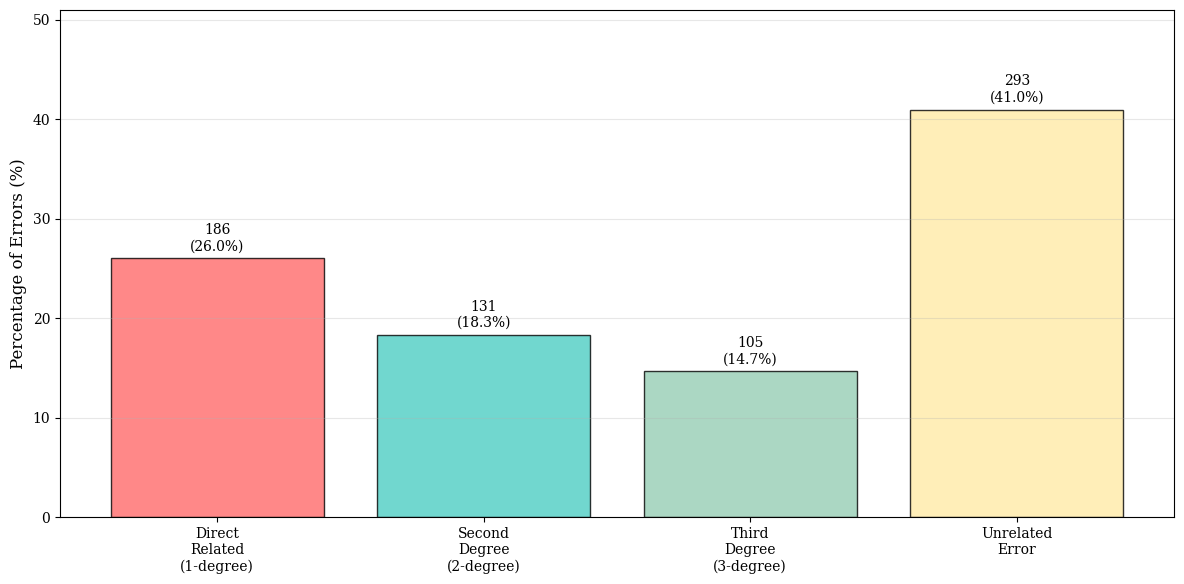

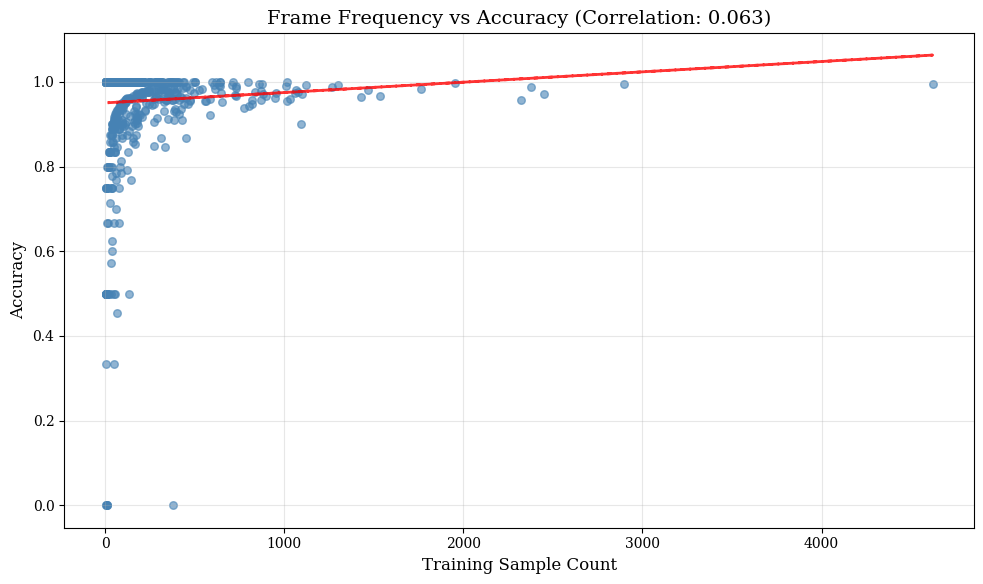


üîç Â§±Ë¥•ÁâπÂæÅÂàÜÊûê...


NameError: name 'predictions_df' is not defined

In [29]:
# =============================================================================
# @title ‚úÖ ÈîôËØØÂàÜÊûê
# =============================================================================

# =============================================================================
# ÁÆÄÂåñÁâàÈîôËØØÂàÜÊûê - ÈÅøÂÖçKeyError
# =============================================================================

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# ËÆæÁΩÆÂ≠ó‰Ωì
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman', 'Cambria', 'DejaVu Serif']

def run_simple_error_analysis():
    """ËøêË°åÁÆÄÂåñÁöÑÈîôËØØÂàÜÊûê - ÂåÖÂê´full textÈ¢ÑÊµãÁªìÊûú"""

    print("üöÄ ÂºÄÂßãÁÆÄÂåñÈîôËØØÂàÜÊûê...")

    # 1. ÊåâÁÖß‰Ω†ÁöÑÊñπÂºèÂä†ËΩΩÊ®°ÂûãÂíåÊï∞ÊçÆ
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã - ‰ΩøÁî®‰Ω†ÁöÑÊµÅÁ®ã
        model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
        print(f"Âä†ËΩΩÊ®°Âûã: {model_path}")

        # ÂàõÂª∫learnerÂπ∂Âä†ËΩΩÊ®°Âûã
        learner = OptimizedPrototypeLearner(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        learner.model.load_state_dict(checkpoint['model_state_dict'])

        # Â∞ÜprototypesËΩ¨Êç¢‰∏∫CPU‰∏äÁöÑnumpyÊ†ºÂºè
        raw_prototypes = checkpoint['prototypes']
        learner.prototypes = {}
        for frame_name, proto in raw_prototypes.items():
            if isinstance(proto, torch.Tensor):
                learner.prototypes[frame_name] = proto.cpu().numpy()
            else:
                learner.prototypes[frame_name] = proto

        print(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(learner.prototypes)}")

        # Âä†ËΩΩÊï∞ÊçÆ
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        full_test_df = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        train_counts = train_df['frame_name'].value_counts()

        with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
            frame_relations = pickle.load(f)

    except Exception as e:
        print(f"‚ùå Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return None

    # 2. ËØÑ‰º∞ÂéüÂßãÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ËØÑ‰º∞ÂéüÂßãÊµãËØïÈõÜ")
    print("="*50)
    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result1['top3_accuracy']:.4f}")

    # 3. ËØÑ‰º∞Full textÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ËØÑ‰º∞Full TextÊµãËØïÈõÜ")
    print("="*50)
    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result2['top3_accuracy']:.4f}")

    # 4. ÁªìÊûúÂØπÊØî
    print("\n" + "="*50)
    print("ÁªìÊûúÂØπÊØî")
    print("="*50)
    print(f"{'ÊåáÊ†á':<15} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'Full Text':<12} {'Â∑ÆÂºÇ':<10}")
    print("-" * 50)
    print(f"Top-1 ÂáÜÁ°ÆÁéá    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")

    # 5. ÁîüÊàêÂéüÂßãÊµãËØïÈõÜÁöÑËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
    print("\nüîç ÁîüÊàêÂéüÂßãÊµãËØïÈõÜËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    original_predictions_df = generate_detailed_predictions(learner, test_df, "ÂéüÂßãÊµãËØïÈõÜ")

    # 6. ÁîüÊàêFull textÊµãËØïÈõÜÁöÑËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
    print("\nüîç ÁîüÊàêFull textÊµãËØïÈõÜËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    fulltext_predictions_df = generate_detailed_predictions(learner, full_test_df, "Full textÊµãËØïÈõÜ")

    # 7. ‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú
    save_dir = "/content/drive/MyDrive/more50/framenet_data"
    original_predictions_df.to_pickle(f"{save_dir}/original_test_detailed_predictions.pkl")
    fulltext_predictions_df.to_pickle(f"{save_dir}/fulltext_test_detailed_predictions.pkl")
    print(f"‚úÖ È¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞ {save_dir}")

    # 8. Âè™ÂØπÂéüÂßãÊµãËØïÈõÜËøõË°åÈîôËØØÂàÜÊûê
    print("\n" + "="*50)
    print("ÂéüÂßãÊµãËØïÈõÜÈîôËØØÂàÜÊûê")
    print("="*50)

    predictions_df = original_predictions_df  # Âè™ÂàÜÊûêÂéüÂßãÊµãËØïÈõÜ

    # Â§±Ë¥•ÁâπÂæÅÂàÜÊûê
    print("\nüîç Â§±Ë¥•ÁâπÂæÅÂàÜÊûê...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3ÂÆåÂÖ®Â§±Ë¥•: {len(top3_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{top3_failures.sum()}Ê¨°Â§±Ë¥•")
    print("   ÊúÄÂÆπÊòìÂÆåÂÖ®Â§±Ë¥•ÁöÑframes:")
    for frame, count in top3_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: {train_count})")

    print(f"\nTop-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü: {len(ranking_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{ranking_failures.sum()}Ê¨°ÊéíÂ∫èÈóÆÈ¢ò")
    print("   ÊúÄÂÆπÊòìÊéíÂ∫èÈîôËØØÁöÑframes:")
    for frame, count in ranking_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: {train_count})")

    # ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê
    print("\nüß† ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê...")
    semantic_results = analyze_semantic_relations_simple(predictions_df, frame_relations)

    # Ê†∑Êú¨È•±ÂíåÊïàÂ∫î
    print("\nüìä Ê†∑Êú¨È•±ÂíåÊïàÂ∫î...")
    saturation_results = analyze_sample_saturation_simple(predictions_df, train_counts)

    # ÁîüÊàêÂõæË°®
    print("\nüìä ÁîüÊàêÂõæË°®...")
    generate_charts(semantic_results, saturation_results, save_dir)

    print("\n‚úÖ ÂàÜÊûêÂÆåÊàê!")

    return {
        'original_predictions': original_predictions_df,
        'fulltext_predictions': fulltext_predictions_df,
        'original_results': result1,
        'fulltext_results': result2
    }

def generate_detailed_predictions(learner, test_df, dataset_name):
    """ÁîüÊàêËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú"""
    print(f"üìä Â§ÑÁêÜ{dataset_name}...")

    # ÂáÜÂ§áÂéüÂûãÊï∞ÊçÆ
    prototype_frames = list(learner.prototypes.keys())
    prototype_vectors = [learner.prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # ÂáÜÂ§áÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊï∞ÊçÆ
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Å
    learner.model.eval()
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, learner.tokenizer, learner.model,
        batch_size=64, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ÊûÑÂª∫È¢ÑÊµãÁªìÊûú
    predictions_data = []
    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        sorted_indices = np.argsort(scores)[::-1]  # ÈôçÂ∫è

        result_row = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        predictions_data.append(result_row)

    predictions_df = pd.DataFrame(predictions_data)

    # È™åËØÅÂáÜÁ°ÆÁéá
    calculated_top1 = predictions_df['is_top1_correct'].mean()
    calculated_top3 = predictions_df['is_top3_correct'].mean()
    print(f"üéØ {dataset_name} Top1ÂáÜÁ°ÆÁéá: {calculated_top1:.4f}")
    print(f"üéØ {dataset_name} Top3ÂáÜÁ°ÆÁéá: {calculated_top3:.4f}")

    return predictions_df

def analyze_semantic_relations_simple(predictions_df, frame_relations):
    """ÁÆÄÂåñÁöÑËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê"""
    # ÊûÑÂª∫ÂÖ≥Á≥ªÂõæ
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # ‰∫åÁ∫ßÂÖ≥Á≥ª
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # ‰∏âÁ∫ßÂÖ≥Á≥ª
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # ÂàÜÊûêÈîôËØØ
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2Á∫ß): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"‰∏âÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (3Á∫ß): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊÄªËÆ°: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"Êó†ÂÖ≥ÈîôËØØ: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    return {
        'total_errors': total_errors,
        'direct_errors': direct_errors,
        'second_errors': second_errors,
        'third_errors': third_errors,
        'unrelated_errors': unrelated_errors
    }

def analyze_sample_saturation_simple(predictions_df, train_counts):
    """ÁÆÄÂåñÁöÑÊ†∑Êú¨È•±ÂíåÊïàÂ∫îÂàÜÊûê"""
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}Ê†∑Êú¨: {len(segment_data)}‰∏™frames, "
                  f"ÂáÜÁ°ÆÁéá {segment_data['is_top1_correct'].mean():.3f}¬±{segment_data['is_top1_correct'].std():.3f}")

    return frame_accuracy

def generate_charts(semantic_results, frame_accuracy, save_dir):
    """ÁîüÊàêÂõæË°®"""
    # ËØ≠‰πâÈîôËØØÂàÜËß£Âõæ
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [semantic_results['direct_errors'], semantic_results['second_errors'],
              semantic_results['third_errors'], semantic_results['unrelated_errors']]
    percentages = [v/semantic_results['total_errors']*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # È¢ëÁéáÁõ∏ÂÖ≥Âõæ
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Â§±Ë¥•ÁâπÂæÅÂàÜÊûê
    print("\nüîç Â§±Ë¥•ÁâπÂæÅÂàÜÊûê...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3ÂÆåÂÖ®Â§±Ë¥•: {len(top3_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{top3_failures.sum()}Ê¨°Â§±Ë¥•")
    print(f"Top-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü: {len(ranking_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{ranking_failures.sum()}Ê¨°ÊéíÂ∫èÈóÆÈ¢ò")

    # 3. ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê
    print("\nüß† ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê...")

    # ÊûÑÂª∫ÂÖ≥Á≥ªÂõæ
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # ‰∫åÁ∫ßÂÖ≥Á≥ª
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # ‰∏âÁ∫ßÂÖ≥Á≥ª
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # ÂàÜÊûêÈîôËØØ
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2Á∫ß): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"‰∏âÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (3Á∫ß): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊÄªËÆ°: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"Êó†ÂÖ≥ÈîôËØØ: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    # 4. Ê†∑Êú¨È•±ÂíåÊïàÂ∫î
    print("\nüìä Ê†∑Êú¨È•±ÂíåÊïàÂ∫î...")
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}Ê†∑Êú¨: {len(segment_data)}‰∏™frames, "
                  f"ÂáÜÁ°ÆÁéá {segment_data['is_top1_correct'].mean():.3f}¬±{segment_data['is_top1_correct'].std():.3f}")

    # 5. ÁîüÊàêÂõæË°®
    print("\nüìä ÁîüÊàêÂõæË°®...")
    save_dir = "/content/drive/MyDrive/more50/framenet_data"

    # ËØ≠‰πâÈîôËØØÂàÜËß£Âõæ
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [direct_errors, second_errors, third_errors, unrelated_errors]
    percentages = [v/total_errors*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # È¢ëÁéáÁõ∏ÂÖ≥Âõæ
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("‚úÖ ÂàÜÊûêÂÆåÊàê!")

    return {
        'semantic_errors': {
            'direct': direct_errors,
            'second': second_errors,
            'third': third_errors,
            'unrelated': unrelated_errors,
            'total': total_errors
        },
        'frame_accuracy': frame_accuracy
    }

# ËøêË°åÂàÜÊûê
if __name__ == "__main__":
    results = run_simple_error_analysis()

In [54]:
# @title ÂÖ®ÈõÜËÅöÁ±ªÊµãËØï
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI Ëá™Âä®ÈÄâÊã©ËÅöÁ±ªÊï∞ÔºàKMeansÔºâ"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # ‰∏çË∂≥‰ª•ËÅöÁ±ªÔºåÁõ¥Êé•Âπ≥Âùá

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # Ê≥®ÊÑèÂéªÊéâ +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã"""
    print("üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # Êåâ‰ºòÂÖàÁ∫ßÊü•ÊâæÊ®°ÂûãÊñá‰ª∂
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # ‰πüÊü•ÊâæÂÖ∂‰ªñÂèØËÉΩÁöÑÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"üìÅ ÊâæÂà∞Ê®°Âûã: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("‚ùå Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None, None, None, None

    # Âä†ËΩΩÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Ëé∑ÂèñËÆ≠ÁªÉÊó∂ÁöÑÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã"""
    print("\nüîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...")

    model.eval()
    frame2embeds = defaultdict(list)

    # ÈáçÊñ∞ÁºñÁ†ÅÊâÄÊúâËÆ≠ÁªÉÊï∞ÊçÆ
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # Êî∂ÈõÜÊØè‰∏™frameÁöÑembeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"ÊâπÊ¨°ÁºñÁ†ÅÈîôËØØ: {e}")
                continue

    print(f"ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ {len(frame2embeds)} ‰∏™frameÁöÑembeddings")

    # ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ªÊûÑÈÄ†Â≠êÂéüÂûã
    print("\nüéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"ËÅöÁ±ªÂÆåÊàê:")
    print(f"  ÂçïÂéüÂûãframe: {clustering_stats['single_prototype']}")
    print(f"  Â§öÂéüÂûãframe: {clustering_stats['multi_prototype']}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    ‰ΩøÁî®Â§öÂéüÂûãËøõË°åËØÑ‰º∞ÔºåÂØπÊØè‰∏™Ê†∑Êú¨ÈÄâÊã©ÊúÄÊé•ËøëÁöÑÂ≠êÂéüÂûã
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞")

    # ÂáÜÂ§áÊâÄÊúâÂéüÂûã - Â±ïÂºÄÂ§öÂéüÂûã
    all_prototype_info = []  # (frame_name, prototype_idx, prototype_vector)
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(all_prototype_vectors)} ‰∏™ÂéüÂûã (Êù•Ëá™{len(frame_multi_prototypes)}‰∏™frame)")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # ËÆ°ÁÆó‰∏éÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑ÂèñÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶ÂàÜÊï∞
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                # ÂØπÊØè‰∏™frameÔºåÂèñËØ•frameÊâÄÊúâÂ≠êÂéüÂûã‰∏≠Áõ∏‰ººÂ∫¶ÊúÄÈ´òÁöÑÈÇ£‰∏™
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # Ê†πÊçÆframeÁ∫ßÂà´ÁöÑÊúÄÈ´òÂàÜÊï∞ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1ÂíåTop-3È¢ÑÊµã
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ Â§öÂéüÂûãËØÑ‰º∞ÁªìÊûú (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Â§ÑÁêÜÊ†∑Êú¨: {results['valid_samples']}/{len(test_df)}")
    print(f"‰ΩøÁî®ÂéüÂûã: {results['prototype_count']} (Êù•Ëá™{results['frame_count']}‰∏™frame)")

    return results

def test_clustered_model_on_datasets():
    """ÊµãËØïËÅöÁ±ªÊ®°ÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞"""
    print("="*80)
    print("ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞")
    print("="*80)

    # 1. Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÔºàÁî®‰∫éÈáçÊñ∞ÊûÑÂª∫ÂéüÂûãÔºâ
    print("\nüìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"ËÆ≠ÁªÉÊï∞ÊçÆ: {len(train_df):,} Ê†∑Êú¨")

    # 3. ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. ÂàÜÊûêÂ§öÂéüÂûã‰ø°ÊÅØ
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. Âä†ËΩΩ‰∏§‰∏™ÊµãËØïÈõÜ
    print("\nüìä Âä†ËΩΩÊµãËØïÈõÜ...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(test_df_original):,} Ê†∑Êú¨")
    print(f"FulltextÊµãËØïÈõÜ: {len(test_df_fulltext):,} Ê†∑Êú¨")

    # 6. Âú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äËøõË°åËØÑ‰º∞
    results = {}

    # ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # FulltextÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"FulltextÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå FulltextÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*80)
    print("ËÅöÁ±ªÊ®°ÂûãÊµãËØïÁªìÊûúÊ±áÊÄª (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)")
    print("="*80)

    print(f"Ê®°Âûã‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {train_best_acc:.4f}")
    print(f"  ËÅöÁ±ªÁªüËÆ°: {clustering_stats}")

    # ÊòæÁ§∫Â§öÂéüÂûãÁªüËÆ°
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  Â§öÂéüÂûãframeÊï∞: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {total_prototypes}")

    print(f"\nÊµãËØïÈõÜÁªìÊûú:")
    print(f"{'ÊµãËØïÈõÜ':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'ÂéüÂßãÊµãËØïÈõÜ':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'FulltextÊµãËØïÈõÜ':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. ‰øùÂ≠òÁªìÊûú
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """‰øùÂ≠òÁªìÊûúÂà∞drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\nüíæ ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: {save_path}")

def analyze_clustering_results():
    """ÁÆÄÂçïÂàÜÊûêËÅöÁ±ªÁªìÊûú"""
    print(f"\nüìà ËÅöÁ±ªÁªìÊûúÂàÜÊûê...")

    # ËøôÈáåÂèØ‰ª•Ê∑ªÂä†Êõ¥ËØ¶ÁªÜÁöÑÂàÜÊûêÔºåÊØîÂ¶ÇÔºö
    # - Âì™‰∫õframeË¢´ËÅöÁ±ª‰∫Ü
    # - ËÅöÁ±ªÊï∞ÈáèÂàÜÂ∏É
    # - ËÅöÁ±ªË¥®ÈáèËØÑ‰º∞Á≠â
    pass

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅ")

            # ÁÆÄÂçïÁöÑÊÄßËÉΩÂàÜÊûê
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\nüìä ÊÄßËÉΩÊÄªÁªì:")
                print(f"  ÂéüÂßãÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {orig_acc:.4f}")
                print(f"  FulltextÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {full_acc:.4f}")
                print(f"  ‰∏§‰∏™ÊµãËØïÈõÜÂπ≥ÂùáÂáÜÁ°ÆÁéá: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  ÂéüÂßãÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  FulltextÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{full_acc - orig_acc:.4f})")

        else:
            print(f"‚ùå ÊµãËØïÂ§±Ë¥•")

    except Exception as e:
        print(f"‚ùå ÊµãËØïËøáÁ®ãÂá∫Èîô: {e}")
        import traceback
        traceback.print_exc()

üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...
ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞
üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...
üìÅ ÊâæÂà∞Ê®°Âûã: best_model.pt
‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.9282

üìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...
ËÆ≠ÁªÉÊï∞ÊçÆ: 150,110 Ê†∑Êú¨

üîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...


ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2346/2346 [05:04<00:00,  7.70it/s]


ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ 1014 ‰∏™frameÁöÑembeddings

üéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...


ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:36<00:00, 27.43it/s]


ËÅöÁ±ªÂÆåÊàê:
  ÂçïÂéüÂûãframe: 53
  Â§öÂéüÂûãframe: 961
  ÊÄªÂéüÂûãÊï∞Èáè: 2974

üìä Âä†ËΩΩÊµãËØïÈõÜ...
ÂéüÂßãÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
FulltextÊµãËØïÈõÜ: 6,872 Ê†∑Êú¨

üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã (Êù•Ëá™1014‰∏™frame)
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Â§öÂéüÂûãËØÑ‰º∞ÁªìÊûú (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)
Top-1ÂáÜÁ°ÆÁéá: 0.9606
Top-3ÂáÜÁ°ÆÁéá: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527
‰ΩøÁî®ÂéüÂûã: 2974 (Êù•Ëá™1014‰∏™frame)
ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.9606
  Top-3ÂáÜÁ°ÆÁéá: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã (Êù•Ëá™1014‰∏™frame)
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872

‚úÖ Â§öÂéüÂûãËØÑ‰º∞ÁªìÊûú (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)
Top-1ÂáÜÁ°ÆÁéá: 0.9415
Top-3ÂáÜÁ°ÆÁéá: 0.9722
Macro F1: 0.8670
Weig

In [58]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI Ëá™Âä®ÈÄâÊã©ËÅöÁ±ªÊï∞ÔºàKMeansÔºâ"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # ‰∏çË∂≥‰ª•ËÅöÁ±ªÔºåÁõ¥Êé•Âπ≥Âùá

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # Ê≥®ÊÑèÂéªÊéâ +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã"""
    print("üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # Êåâ‰ºòÂÖàÁ∫ßÊü•ÊâæÊ®°ÂûãÊñá‰ª∂
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # ‰πüÊü•ÊâæÂÖ∂‰ªñÂèØËÉΩÁöÑÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"üìÅ ÊâæÂà∞Ê®°Âûã: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("‚ùå Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None, None, None, None

    # Âä†ËΩΩÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Ëé∑ÂèñËÆ≠ÁªÉÊó∂ÁöÑÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã"""
    print("\nüîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...")

    model.eval()
    frame2embeds = defaultdict(list)

    # ÈáçÊñ∞ÁºñÁ†ÅÊâÄÊúâËÆ≠ÁªÉÊï∞ÊçÆ
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # Êî∂ÈõÜÊØè‰∏™frameÁöÑembeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"ÊâπÊ¨°ÁºñÁ†ÅÈîôËØØ: {e}")
                continue

    print(f"ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ {len(frame2embeds)} ‰∏™frameÁöÑembeddings")

    # ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ªÊûÑÈÄ†Â≠êÂéüÂûã
    print("\nüéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"ËÅöÁ±ªÂÆåÊàê:")
    print(f"  ÂçïÂéüÂûãframe: {clustering_stats['single_prototype']}")
    print(f"  Â§öÂéüÂûãframe: {clustering_stats['multi_prototype']}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    ‰ΩøÁî®Â§öÂéüÂûãËøõË°åËØÑ‰º∞ÔºåÂØπÊØè‰∏™Ê†∑Êú¨ÈÄâÊã©ÊúÄÊé•ËøëÁöÑÂ≠êÂéüÂûã
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞")

    # ÂáÜÂ§áÊâÄÊúâÂéüÂûã - Â±ïÂºÄÂ§öÂéüÂûã
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(all_prototype_vectors)} ‰∏™ÂéüÂûã")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings - ÂÆåÂÖ®ÈùôÈªò
    print("ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # Á¶ÅÁî®ÊâÄÊúâtqdmËøõÂ∫¶Êù°ÁöÑÁéØÂ¢ÉÂèòÈáè
            import os
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                # ÊÅ¢Â§çÂéüÊù•ÁöÑÁéØÂ¢ÉÂèòÈáè
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # ËÆ°ÁÆó‰∏éÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶
    print("ËÆ°ÁÆóÁõ∏‰ººÂ∫¶...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú - ÂÆåÂÖ®ÈùôÈªòÂ§ÑÁêÜ
    print("ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    # ÂÆåÂÖ®ÈùôÈªòÁöÑÂæ™ÁéØÔºå‰∏ç‰ΩøÁî®‰ªª‰ΩïËøõÂ∫¶Êù°
    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑ÂèñÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶ÂàÜÊï∞
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # Ê†πÊçÆframeÁ∫ßÂà´ÁöÑÊúÄÈ´òÂàÜÊï∞ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1ÂíåTop-3È¢ÑÊµã
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ ËØÑ‰º∞ÂÆåÊàê")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú - Âè™‰øùÁïôËøô‰∏™ËøõÂ∫¶Êù°
    print("ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    from tqdm import tqdm
    for i, gold_frame in enumerate(tqdm(valid_frames, desc="ËØÑ‰º∞‰∏≠", ncols=80, ascii=True)):
        # Ëé∑ÂèñÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶ÂàÜÊï∞
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # Ê†πÊçÆframeÁ∫ßÂà´ÁöÑÊúÄÈ´òÂàÜÊï∞ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1ÂíåTop-3È¢ÑÊµã
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ ËØÑ‰º∞ÂÆåÊàê")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results

def test_clustered_model_on_datasets():
    """ÊµãËØïËÅöÁ±ªÊ®°ÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞"""
    print("="*80)
    print("ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞")
    print("="*80)

    # 1. Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÔºàÁî®‰∫éÈáçÊñ∞ÊûÑÂª∫ÂéüÂûãÔºâ
    print("\nüìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"ËÆ≠ÁªÉÊï∞ÊçÆ: {len(train_df):,} Ê†∑Êú¨")

    # 3. ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. ÂàÜÊûêÂ§öÂéüÂûã‰ø°ÊÅØ
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. Âä†ËΩΩ‰∏§‰∏™ÊµãËØïÈõÜ
    print("\nüìä Âä†ËΩΩÊµãËØïÈõÜ...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(test_df_original):,} Ê†∑Êú¨")
    print(f"FulltextÊµãËØïÈõÜ: {len(test_df_fulltext):,} Ê†∑Êú¨")

    # 6. Âú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äËøõË°åËØÑ‰º∞
    results = {}

    # ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # FulltextÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"FulltextÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå FulltextÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*80)
    print("ËÅöÁ±ªÊ®°ÂûãÊµãËØïÁªìÊûúÊ±áÊÄª (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)")
    print("="*80)

    print(f"Ê®°Âûã‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {train_best_acc:.4f}")
    print(f"  ËÅöÁ±ªÁªüËÆ°: {clustering_stats}")

    # ÊòæÁ§∫Â§öÂéüÂûãÁªüËÆ°
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  Â§öÂéüÂûãframeÊï∞: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {total_prototypes}")

    print(f"\nÊµãËØïÈõÜÁªìÊûú:")
    print(f"{'ÊµãËØïÈõÜ':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'ÂéüÂßãÊµãËØïÈõÜ':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'FulltextÊµãËØïÈõÜ':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. ‰øùÂ≠òÁªìÊûú
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """‰øùÂ≠òÁªìÊûúÂà∞drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\nüíæ ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: {save_path}")

def analyze_clustering_results():
    """ÁÆÄÂçïÂàÜÊûêËÅöÁ±ªÁªìÊûú"""
    print(f"\nüìà ËÅöÁ±ªÁªìÊûúÂàÜÊûê...")

    # ËøôÈáåÂèØ‰ª•Ê∑ªÂä†Êõ¥ËØ¶ÁªÜÁöÑÂàÜÊûêÔºåÊØîÂ¶ÇÔºö
    # - Âì™‰∫õframeË¢´ËÅöÁ±ª‰∫Ü
    # - ËÅöÁ±ªÊï∞ÈáèÂàÜÂ∏É
    # - ËÅöÁ±ªË¥®ÈáèËØÑ‰º∞Á≠â
    pass

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅ")

            # ÁÆÄÂçïÁöÑÊÄßËÉΩÂàÜÊûê
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\nüìä ÊÄßËÉΩÊÄªÁªì:")
                print(f"  ÂéüÂßãÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {orig_acc:.4f}")
                print(f"  FulltextÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {full_acc:.4f}")
                print(f"  ‰∏§‰∏™ÊµãËØïÈõÜÂπ≥ÂùáÂáÜÁ°ÆÁéá: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  ÂéüÂßãÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  FulltextÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{full_acc - orig_acc:.4f})")

        else:
            print(f"‚ùå ÊµãËØïÂ§±Ë¥•")

    except Exception as e:
        print(f"‚ùå ÊµãËØïËøáÁ®ãÂá∫Èîô: {e}")
        import traceback
        traceback.print_exc()

üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...
ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞
üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...
üìÅ ÊâæÂà∞Ê®°Âûã: best_model.pt
‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.9282

üìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...


Ê≠•È™§3/8: ÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã:  25%|‚ñà‚ñà‚ñå       | 2/8 [10:17<30:53, 308.86s/it]


ËÆ≠ÁªÉÊï∞ÊçÆ: 150,110 Ê†∑Êú¨

üîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...


ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2346/2346 [05:08<00:00,  7.61it/s]


ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ 1014 ‰∏™frameÁöÑembeddings

üéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...


ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:36<00:00, 27.55it/s]


ËÅöÁ±ªÂÆåÊàê:
  ÂçïÂéüÂûãframe: 53
  Â§öÂéüÂûãframe: 961
  ÊÄªÂéüÂûãÊï∞Èáè: 2974

üìä Âä†ËΩΩÊµãËØïÈõÜ...
ÂéüÂßãÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
FulltextÊµãËØïÈõÜ: 6,872 Ê†∑Êú¨

üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527
ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...
ËÆ°ÁÆóÁõ∏‰ººÂ∫¶...
ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...

‚úÖ ËØÑ‰º∞ÂÆåÊàê
Top-1ÂáÜÁ°ÆÁéá: 0.9606
Top-3ÂáÜÁ°ÆÁéá: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.9606
  Top-3ÂáÜÁ°ÆÁéá: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872
ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...
ËÆ°ÁÆóÁõ∏‰ººÂ∫¶...
ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...

‚úÖ ËØÑ‰º∞ÂÆåÊàê
Top-1ÂáÜÁ°ÆÁéá: 0.9415
Top-3ÂáÜÁ°ÆÁéá: 0.9722
Macro F1: 0.8670
Weighted F1: 0.9454
FulltextÊµãËØïÈõÜÁªìÊûú:
  Top-1ÂáÜÁ°Æ

In [41]:
# @title ‚úÖ ÂÆåÊï¥‰øÆÂ§çÁâà Few-shot Prototype LearnerÔºàÂê´ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò + Test ËØÑ‰º∞Ôºâ

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ‚úÖ ‰Ω†Ëá™Â∑±Â∑≤ÊúâÁöÑ‰æùËµñÈ°πÔºà‰ª•‰∏ãÂÅáËÆæÈÉΩÂ∑≤ÁªèÂØºÂÖ•Ôºâ
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"‰ΩøÁî® {shot_method} ÊñπÊ≥ïËÆ≠ÁªÉ")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\nÁîüÊàê {shot_num}-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:")
        print(f"   ÊÄªÊ†∑Êú¨Êï∞: {len(few_shot_df):,}")
        print(f"   Ê†∑Êú¨ÂÖÖË∂≥frame: {stats['sufficient_samples']}")
        print(f"   Ê†∑Êú¨‰∏çË∂≥frame: {stats['insufficient_samples']}")
        print(f"   Âπ≥ÂùáÊØèframe: {stats['total_samples']/len(frame_groups):.1f} Ê†∑Êú¨")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # Á°Æ‰øùlossÊòØÊ†áÈáèÂÄºÔºå‰∏çÊòØÂº†Èáè
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
            print(f"   ÊÅ¢Â§çepoch: {checkpoint['epoch']}, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"Âä†ËΩΩÂ§±Ë¥•: {e}")
            print(f"Âä†ËΩΩÂ§±Ë¥•Ë∑ØÂæÑ: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """ÂÆâÂÖ®ËÆ°ÁÆóÂº†ÈáèÂàóË°®ÁöÑÂπ≥ÂùáÂÄºÔºåÁ°Æ‰øùÂ§ÑÁêÜCUDAÂº†Èáè"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # Â∞ÜÂº†ÈáèÁßªÂà∞CPUÂπ∂ËΩ¨Êç¢‰∏∫Ê†áÈáè
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # Êî∂ÈõÜÊçüÂ§±ÂÄºÔºåÁ°Æ‰øùÈÉΩËΩ¨Êç¢‰∏∫Ê†áÈáè
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # Êõ¥Êñ∞ËøõÂ∫¶Êù°ÊòæÁ§∫
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # È™åËØÅ
            acc = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"È™åËØÅÂáÜÁ°ÆÁéá: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # ÈáçÂª∫ÂéüÂûã
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # Ê£ÄÊü•ÊòØÂê¶ÊòØÊúÄ‰Ω≥Ê®°Âûã
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"ËøûÁª≠{patience}ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢")
                    break

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂Ôºå‰ΩøÁî®ÊúÄÂêéÁä∂ÊÄÅ")

        # ‰øùÂ≠òÊúÄÁªàÊ®°Âûã
        torch.save({
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc,
        }, f"{self.save_dir}/final_model.pt")
        print(f"ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"‰∏çÊîØÊåÅÁöÑÊñπÊ≥ï: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\nÂä†ËΩΩÊµãËØïÈõÜ: {len(test_df):,} Ê†∑Êú¨")
    result = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"\nTestËØÑ‰º∞ÂÆåÊàê: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\nüöÄ ÂºÄÂßã {method} ËÆ≠ÁªÉ...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\nüìä {method} ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...")

    # È™åËØÅÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:")
    val_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # ÊµãËØïÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"‚úÖ {method} ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆåÊàê!")
    print(f"üìä ÊúÄÁªàÁªìÊûúÊ±áÊÄª:")
    print(f"   È™åËØÅÈõÜ - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   ÊµãËØïÈõÜ - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# ËøêË°åËÆ≠ÁªÉ
if __name__ == "__main__":
    # Á≠ñÁï•B: È¢ëÁπÅÊõ¥Êñ∞ÔºåÊõ¥‰ΩéÂ≠¶‰π†ÁéáÔºåÊõ¥Â§öepoch

    # 3-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('3-shot', epochs=20)

    # 5-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)


üöÄ ÂºÄÂßã 3-shot ËÆ≠ÁªÉ...
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ

ÁîüÊàê 3-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...
3-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:
   ÊÄªÊ†∑Êú¨Êï∞: 2,962
   Ê†∑Êú¨ÂÖÖË∂≥frame: 961
   Ê†∑Êú¨‰∏çË∂≥frame: 53
   Âπ≥ÂùáÊØèframe: 2.9 Ê†∑Êú¨
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11339.37it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4081
Top-3ÂáÜÁ°ÆÁéá: 0.5936
Macro F1: 0.3998
Weighted F1: 0.4231
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4081 | Loss: 2.1969
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11279.41it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep1_acc0.4081.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4265
Top-3ÂáÜÁ°ÆÁéá: 0.6075
Macro F1: 0.4163
Weighted F1: 0.4414
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4265 | Loss: 0.9228
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11396.77it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4259
Top-3ÂáÜÁ°ÆÁéá: 0.6067
Macro F1: 0.4186
Weighted F1: 0.4408
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4259 | Loss: 0.5376
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11163.94it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4235
Top-3ÂáÜÁ°ÆÁéá: 0.6021
Macro F1: 0.4163
Weighted F1: 0.4386
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4235 | Loss: 0.3413
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11137.33it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4182
Top-3ÂáÜÁ°ÆÁéá: 0.5966
Macro F1: 0.4146
Weighted F1: 0.4329
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4182 | Loss: 0.2255
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11285.78it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4161
Top-3ÂáÜÁ°ÆÁéá: 0.5952
Macro F1: 0.4131
Weighted F1: 0.4312
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4161 | Loss: 0.1558
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11185.63it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ËøûÁª≠4ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò

üìä 3-shot ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...
üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [49]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_on_original_test():
    """ÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""
    print("üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...")
    print("=" * 70)

    # ËÆæÂ§áËÆæÁΩÆ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # 1. Âä†ËΩΩ3-shotÊúÄ‰Ω≥Ê®°Âûã
    print("\nüì• Ê≠•È™§1: Âä†ËΩΩ3-shotÊúÄ‰Ω≥Ê®°Âûã")
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("‚ùå Êú™ÊâæÂà∞3-shotÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None

    # ÈÄâÊã©ÂáÜÁ°ÆÁéáÊúÄÈ´òÁöÑÊ®°ÂûãÊñá‰ª∂
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"üìÅ ÈÄâÊã©Ê®°Âûã: {os.path.basename(best_model_path)}")
    print(f"üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: {best_acc:.4f}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("‚ùå 3-shotÊ®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ3-shotÊ®°Âûã (epoch {epoch})")

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩ3-shotÊ®°ÂûãÊó∂Âá∫Èîô: {e}")
        return None

    # 2. Âä†ËΩΩÂéüÂßãÊµãËØïÈõÜ
    print("\nüìä Ê≠•È™§2: Âä†ËΩΩÂéüÂßãÊµãËØïÈõÜ")
    original_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    try:
        original_test_df = pd.read_pickle(original_test_path)
        print(f"‚úÖ ÂéüÂßãÊµãËØïÈõÜÂ§ßÂ∞è: {len(original_test_df):,} Ê†∑Êú¨")

        # ÊòæÁ§∫ÊµãËØïÈõÜÂü∫Êú¨‰ø°ÊÅØ
        unique_frames = original_test_df['frame_name'].nunique()
        print(f"üìã ÂåÖÂê´frameÊï∞Èáè: {unique_frames}")

    except Exception as e:
        print(f"‚ùå Êó†Ê≥ïÂä†ËΩΩÂéüÂßãÊµãËØïÈõÜ: {e}")
        print(f"Ê£ÄÊü•Ë∑ØÂæÑ: {original_test_path}")
        return None

    # 3. Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äËØÑ‰º∞
    print("\nüéØ Ê≠•È™§3: Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äËØÑ‰º∞3-shotÊ®°Âûã")
    print("=" * 70)

    # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
    learner.model.eval()

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                original_test_df,
                learner.prototypes
            )

        # 4. ÊòæÁ§∫ËØ¶ÁªÜÁªìÊûú
        print("\n" + "=" * 70)
        print("üéâ 3-shotÊ®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑËØÑ‰º∞ÂÆåÊàêÔºÅ")
        print("=" * 70)

        print(f"üìà ËØ¶ÁªÜÊµãËØïÁªìÊûú:")
        print(f"   üéØ Top-1 ÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   üéØ Top-3 ÂáÜÁ°ÆÁéá: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   üìä Macro Precision: {result['macro_precision']:.4f}")
        print(f"   üìä Macro Recall: {result['macro_recall']:.4f}")
        print(f"   üìä Macro F1: {result['macro_f1']:.4f}")
        print(f"   üìä Weighted Precision: {result['weighted_precision']:.4f}")
        print(f"   üìä Weighted Recall: {result['weighted_recall']:.4f}")
        print(f"   üìä Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   üìã Â§ÑÁêÜÊ†∑Êú¨Êï∞: {result['valid_samples']:,} / {result['total_samples']:,}")
        print(f"   üè∑Ô∏è  ÂéüÂûãÊï∞Èáè: {result['prototype_count']}")

        # 5. ÊÄßËÉΩÂàÜÊûê
        print(f"\nüìã ÊÄßËÉΩÂàÜÊûê:")
        coverage = result['valid_samples'] / len(original_test_df) * 100
        print(f"   Ê†∑Êú¨Ë¶ÜÁõñÁéá: {coverage:.2f}%")

        if result['top1_accuracy'] > 0.4:
            print("   üü¢ Ë°®Áé∞: ‰ºòÁßÄ")
        elif result['top1_accuracy'] > 0.3:
            print("   üü° Ë°®Áé∞: ËâØÂ•Ω")
        else:
            print("   üî¥ Ë°®Áé∞: ÈúÄË¶ÅÊîπËøõ")

        # 6. ‰∏éÈ™åËØÅÈõÜÊÄßËÉΩÂØπÊØî
        print(f"\nüîÑ ‰∏éÈ™åËØÅÈõÜÊÄßËÉΩÂØπÊØî:")
        print(f"   È™åËØÅÈõÜÂáÜÁ°ÆÁéá: {best_acc:.4f}")
        print(f"   ÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f}")
        diff = result['top1_accuracy'] - best_acc
        if abs(diff) < 0.01:
            print(f"   Â∑ÆÂºÇ: {diff:+.4f} (Á®≥ÂÆö)")
        elif diff > 0:
            print(f"   Â∑ÆÂºÇ: {diff:+.4f} (ÊµãËØïÈõÜÊõ¥Â•Ω)")
        else:
            print(f"   Â∑ÆÂºÇ: {diff:+.4f} (ÂèØËÉΩËøáÊãüÂêà)")

        return result

    except Exception as e:
        print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        return None

    finally:
        # Ê∏ÖÁêÜGPUÂÜÖÂ≠ò
        if 'learner' in locals():
            del learner
        torch.cuda.empty_cache()

def quick_3shot_test():
    """Âø´ÈÄüÁâàÊú¨ÁöÑ3-shotÂéüÂßãÊµãËØïÈõÜÊµãËØï"""
    print("‚ö° Âø´ÈÄüÊµãËØï3-shotÊ®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ...")

    result = test_3shot_on_original_test()

    if result:
        print(f"\nüéä ÊµãËØïÂÆåÊàêÔºÅ")
        print(f"üèÜ ÊúÄÁªàÁªìÊûú: Top-1ÂáÜÁ°ÆÁéá {result['top1_accuracy']:.4f}, Macro F1 {result['macro_f1']:.4f}")
        return result
    else:
        print("üí• ÊµãËØïÂ§±Ë¥•")
        return None

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üß™ 3-shotÊ®°ÂûãÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞")
    print("ÈÄâÊã©ËøêË°åÊñπÂºè:")
    print("1. ËØ¶ÁªÜÊµãËØï (Êé®Ëçê)")
    print("2. Âø´ÈÄüÊµãËØï")

    # ËøêË°åËØ¶ÁªÜÊµãËØï
    result = test_3shot_on_original_test()

    # Â¶ÇÊûú‰Ω†ÊÉ≥Ë¶ÅÂø´ÈÄüÊµãËØïÔºåÂèØ‰ª•Áî®‰∏ãÈù¢ËøôË°åÔºö
    # result = quick_3shot_test()

üß™ 3-shotÊ®°ÂûãÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞
ÈÄâÊã©ËøêË°åÊñπÂºè:
1. ËØ¶ÁªÜÊµãËØï (Êé®Ëçê)
2. Âø´ÈÄüÊµãËØï
üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...
‰ΩøÁî®ËÆæÂ§á: cuda

üì• Ê≠•È™§1: Âä†ËΩΩ3-shotÊúÄ‰Ω≥Ê®°Âûã
üìÅ ÈÄâÊã©Ê®°Âûã: best_model_ep2_acc0.4265.pt
üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: 0.4265
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩ3-shotÊ®°Âûã (epoch 2)

üìä Ê≠•È™§2: Âä†ËΩΩÂéüÂßãÊµãËØïÈõÜ
‚úÖ ÂéüÂßãÊµãËØïÈõÜÂ§ßÂ∞è: 25,527 Ê†∑Êú¨
üìã ÂåÖÂê´frameÊï∞Èáè: 907

üéØ Ê≠•È™§3: Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äËØÑ‰º∞3-shotÊ®°Âûã
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4381
Top-3ÂáÜÁ°ÆÁéá: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527

üéâ 3-shotÊ®°Âûã

In [47]:
# ‚úÖ ÂÆåÊï¥‰øÆÂ§çÁâà Few-shot Prototype LearnerÔºàÂê´ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò + Test ËØÑ‰º∞Ôºâ

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ‚úÖ ‰Ω†Ëá™Â∑±Â∑≤ÊúâÁöÑ‰æùËµñÈ°πÔºà‰ª•‰∏ãÂÅáËÆæÈÉΩÂ∑≤ÁªèÂØºÂÖ•Ôºâ
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"‰ΩøÁî® {shot_method} ÊñπÊ≥ïËÆ≠ÁªÉ")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\nÁîüÊàê {shot_num}-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:")
        print(f"   ÊÄªÊ†∑Êú¨Êï∞: {len(few_shot_df):,}")
        print(f"   Ê†∑Êú¨ÂÖÖË∂≥frame: {stats['sufficient_samples']}")
        print(f"   Ê†∑Êú¨‰∏çË∂≥frame: {stats['insufficient_samples']}")
        print(f"   Âπ≥ÂùáÊØèframe: {stats['total_samples']/len(frame_groups):.1f} Ê†∑Êú¨")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # Á°Æ‰øùlossÊòØÊ†áÈáèÂÄºÔºå‰∏çÊòØÂº†Èáè
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
            print(f"   ÊÅ¢Â§çepoch: {checkpoint['epoch']}, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"Âä†ËΩΩÂ§±Ë¥•: {e}")
            print(f"Âä†ËΩΩÂ§±Ë¥•Ë∑ØÂæÑ: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """ÂÆâÂÖ®ËÆ°ÁÆóÂº†ÈáèÂàóË°®ÁöÑÂπ≥ÂùáÂÄºÔºåÁ°Æ‰øùÂ§ÑÁêÜCUDAÂº†Èáè"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # Â∞ÜÂº†ÈáèÁßªÂà∞CPUÂπ∂ËΩ¨Êç¢‰∏∫Ê†áÈáè
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # Êî∂ÈõÜÊçüÂ§±ÂÄºÔºåÁ°Æ‰øùÈÉΩËΩ¨Êç¢‰∏∫Ê†áÈáè
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # Êõ¥Êñ∞ËøõÂ∫¶Êù°ÊòæÁ§∫
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # È™åËØÅ
            self.model.eval()
            with torch.no_grad():
                acc = evaluate_target_known_fixed(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"È™åËØÅÂáÜÁ°ÆÁéá: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # ÂàáÊç¢ÂõûËÆ≠ÁªÉÊ®°Âºè
            self.model.train()

            # ÈáçÂª∫ÂéüÂûã
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # Ê£ÄÊü•ÊòØÂê¶ÊòØÊúÄ‰Ω≥Ê®°Âûã
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"ËøûÁª≠{patience}ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢")
                    break

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂Ôºå‰ΩøÁî®ÊúÄÂêéÁä∂ÊÄÅ")

        # ‰øùÂ≠òÊúÄÁªàÊ®°Âûã
        final_checkpoint = {
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc if 'acc' in locals() else 0.0,
        }
        torch.save(final_checkpoint, f"{self.save_dir}/final_model.pt")
        print(f"ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"‰∏çÊîØÊåÅÁöÑÊñπÊ≥ï: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    """ÂÆâÂÖ®ÁöÑÊµãËØïÈõÜËØÑ‰º∞ÂáΩÊï∞ÔºåÁ°Æ‰øùÊâÄÊúâÂº†ÈáèÊìç‰ΩúÊ≠£Á°ÆÂ§ÑÁêÜ"""
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\nÂä†ËΩΩÊµãËØïÈõÜ: {len(test_df):,} Ê†∑Êú¨")

    # Á°Æ‰øùÊ®°ÂûãÂú®evalÊ®°Âºè
    learner.model.eval()

    with torch.no_grad():
        result = evaluate_target_known_fixed(learner.model, learner.tokenizer, test_df, learner.prototypes)

    print(f"\nTestËØÑ‰º∞ÂÆåÊàê: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def safe_evaluate_target_known(model, tokenizer, df, prototypes):
    """ÂÆâÂÖ®ÁâàÊú¨ÁöÑevaluate_target_knownÔºåÂ§ÑÁêÜCUDAÂº†ÈáèÈóÆÈ¢ò"""
    try:
        model.eval()
        with torch.no_grad():
            result = evaluate_target_known(model, tokenizer, df, prototypes)
        return result
    except Exception as e:
        print(f"ËØÑ‰º∞ËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {e}")
        print("Â∞ùËØïÊâãÂä®Ê∏ÖÁêÜGPUÁºìÂ≠ò...")
        torch.cuda.empty_cache()

        # ÈáçËØï‰∏ÄÊ¨°
        try:
            model.eval()
            with torch.no_grad():
                result = evaluate_target_known(model, tokenizer, df, prototypes)
            return result
        except Exception as e2:
            print(f"ÈáçËØïÂêé‰ªçÁÑ∂Â§±Ë¥•: {e2}")
            # ËøîÂõûÈªòËÆ§ÁªìÊûúÈÅøÂÖçÂ¥©Ê∫É
            return {'top1_accuracy': 0.0, 'macro_f1': 0.0}

def evaluate_target_known_fixed(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    ‰øÆÂ§çÁâàÁöÑTarget-knownËØÑ‰º∞ÔºöÁªôÂÆötarget spanÔºåËØÑ‰º∞frameÂàÜÁ±ªÂáÜÁ°ÆÁéá
    ‰øÆÂ§ç‰∫ÜCUDAÂº†ÈáèËΩ¨Êç¢ÈóÆÈ¢ò
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()

    # Ëé∑ÂèñÊàñËÆ°ÁÆóframeÂéüÂûã
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("ÂøÖÈ°ªÊèê‰æõframe_prototypesÊàñtrain_df‰πã‰∏Ä")
        print("üîÑ Áé∞Âú∫ËÆ°ÁÆóframeÂéüÂûã...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã")

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ - ‰øÆÂ§çCUDAÂº†ÈáèÈóÆÈ¢ò
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = []

    for frame in prototype_frames:
        prototype_vec = frame_prototypes[frame]
        # Á°Æ‰øùÂéüÂûãÂêëÈáèËΩ¨Êç¢‰∏∫numpyÊï∞ÁªÑ
        if torch.is_tensor(prototype_vec):
            prototype_vectors.append(prototype_vec.detach().cpu().numpy())
        else:
            prototype_vectors.append(prototype_vec)

    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(prototype_frames)} ‰∏™frameÂéüÂûã")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings - ‰øÆÂ§çCUDAÂº†ÈáèÈóÆÈ¢ò
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        # Á°Æ‰øùÂÆâÂÖ®ËΩ¨Êç¢‰∏∫numpy
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # ËÆ°ÁÆócosineÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑Âèñtop-NÈ¢ÑÊµã
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # ÈôçÂ∫èÊéíÂàó
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Â§ÑÁêÜÊ†∑Êú¨: {results['valid_samples']}/{len(test_df)}")

    return results

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\nüöÄ ÂºÄÂßã {method} ËÆ≠ÁªÉ...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\nüìä {method} ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...")

    # È™åËØÅÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:")
    val_result = evaluate_target_known_fixed(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # ÊµãËØïÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"‚úÖ {method} ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆåÊàê!")
    print(f"üìä ÊúÄÁªàÁªìÊûúÊ±áÊÄª:")
    print(f"   È™åËØÅÈõÜ - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   ÊµãËØïÈõÜ - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# ËøêË°åËÆ≠ÁªÉ
if __name__ == "__main__":
    # Á≠ñÁï•B: È¢ëÁπÅÊõ¥Êñ∞ÔºåÊõ¥‰ΩéÂ≠¶‰π†ÁéáÔºåÊõ¥Â§öepoch


    # 5-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)




üöÄ ÂºÄÂßã 5-shot ËÆ≠ÁªÉ...
‰ΩøÁî® 5-shot ÊñπÊ≥ïËÆ≠ÁªÉ

ÁîüÊàê 5-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...
5-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:
   ÊÄªÊ†∑Êú¨Êï∞: 4,804
   Ê†∑Êú¨ÂÖÖË∂≥frame: 910
   Ê†∑Êú¨‰∏çË∂≥frame: 104
   Âπ≥ÂùáÊØèframe: 4.7 Ê†∑Êú¨
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7919.19it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4590
Top-3ÂáÜÁ°ÆÁéá: 0.6517
Macro F1: 0.4742
Weighted F1: 0.4795
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4590 | Loss: 5.3338
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7802.68it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep1_acc0.4590.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4971
Top-3ÂáÜÁ°ÆÁéá: 0.6811
Macro F1: 0.5150
Weighted F1: 0.5213
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4971 | Loss: 1.7640
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 8065.05it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4870
Top-3ÂáÜÁ°ÆÁéá: 0.6651
Macro F1: 0.5158
Weighted F1: 0.5136
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4870 | Loss: 0.8143
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7843.94it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4874
Top-3ÂáÜÁ°ÆÁéá: 0.6643
Macro F1: 0.5050
Weighted F1: 0.5109
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4874 | Loss: 0.4664
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7945.49it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4905
Top-3ÂáÜÁ°ÆÁéá: 0.6688
Macro F1: 0.4995
Weighted F1: 0.5108
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4905 | Loss: 0.3111
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7966.99it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4847
Top-3ÂáÜÁ°ÆÁéá: 0.6622
Macro F1: 0.4951
Weighted F1: 0.5051
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4847 | Loss: 0.2274
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 8057.46it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ËøûÁª≠4ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4971
ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò

üìä 5-shot ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...
üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5168
Top-3ÂáÜÁ°ÆÁéá: 0.7045
Macro F1: 0.5085
Weighted F1: 0.5353
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
Val Top-1: 0.5168, Macro F1: 0.5085
üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:

Âä†ËΩΩÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5231
Top-3ÂáÜÁ°ÆÁéá: 0.7052
Macro F1: 0.5161
Weighted F1: 0.5388
Â§ÑÁêÜÊ†∑Êú¨: 25527/255

Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4788.62it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4361
Top-3ÂáÜÁ°ÆÁéá: 0.6209
Macro F1: 0.4970
Weighted F1: 0.4639
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4361 | Loss: 6.9749
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4935.35it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep1_acc0.4361.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4995
Top-3ÂáÜÁ°ÆÁéá: 0.6674
Macro F1: 0.5658
Weighted F1: 0.5365
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4995 | Loss: 1.3416
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4888.73it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep2_acc0.4995.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5927
Top-3ÂáÜÁ°ÆÁéá: 0.7729
Macro F1: 0.5974
Weighted F1: 0.6046
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5927 | Loss: 0.6197
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4886.51it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep3_acc0.5927.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6051
Top-3ÂáÜÁ°ÆÁéá: 0.7828
Macro F1: 0.6128
Weighted F1: 0.6209
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.6051 | Loss: 0.4709
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4932.78it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep4_acc0.6051.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6076
Top-3ÂáÜÁ°ÆÁéá: 0.7863
Macro F1: 0.6122
Weighted F1: 0.6225
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.6076 | Loss: 0.3826
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4904.27it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6032
Top-3ÂáÜÁ°ÆÁéá: 0.7839
Macro F1: 0.6080
Weighted F1: 0.6161
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.6032 | Loss: 0.3206
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4879.61it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5950
Top-3ÂáÜÁ°ÆÁéá: 0.7763
Macro F1: 0.6021
Weighted F1: 0.6070
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5950 | Loss: 0.2629
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4914.16it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5999
Top-3ÂáÜÁ°ÆÁéá: 0.7841
Macro F1: 0.6008
Weighted F1: 0.6116
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5999 | Loss: 0.2204
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4952.47it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5905
Top-3ÂáÜÁ°ÆÁéá: 0.7717
Macro F1: 0.6012
Weighted F1: 0.6022
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5905 | Loss: 0.1887
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4891.65it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ËøûÁª≠4ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt
   ÊÅ¢Â§çepoch: 5, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.6076
ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò

üìä 10-shot ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...
üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6059
Top-3ÂáÜÁ°ÆÁéá: 0.7854
Macro F1: 0.6087
Weighted F1: 0.6193
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
Val Top-1: 0.6059, Macro F1: 0.6087
üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:

Âä†ËΩΩÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6051
Top-3ÂáÜÁ°ÆÁéá: 0.7876
Macro F1: 0.6134
Weighted F1: 0.6168
Â§ÑÁêÜÊ†∑Êú¨: 25527/2

In [48]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def load_best_model(shot_method):
    """Âä†ËΩΩÊåáÂÆöshotÊñπÊ≥ïÁöÑÊúÄ‰Ω≥Ê®°Âûã"""
    print(f"\nüöÄ Âä†ËΩΩ {shot_method} ÊúÄ‰Ω≥Ê®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"‚ùå Êú™ÊâæÂà∞ {shot_method} ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None

    # ÈÄâÊã©ÂáÜÁ°ÆÁéáÊúÄÈ´òÁöÑÊ®°ÂûãÊñá‰ª∂
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        # ‰ªéÊñá‰ª∂ÂêçÊèêÂèñÂáÜÁ°ÆÁéá
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]  # Â§áÈÄâÊñπÊ°à

    print(f"üìÅ ÈÄâÊã©Ê®°Âûã: {best_model_path}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"‚ùå {shot_method} Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ {shot_method} Ê®°Âûã (epoch {epoch}, acc {best_acc:.4f})")
        return learner

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩ {shot_method} Ê®°ÂûãÊó∂Âá∫Èîô: {e}")
        return None

def test_on_fulltext(learner, shot_method):
    """Âú®fulltextÊµãËØïÈõÜ‰∏äÊµãËØïÊ®°Âûã"""
    print(f"\nüéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï {shot_method} Ê®°Âûã...")

    # Âä†ËΩΩfulltextÊµãËØïÊï∞ÊçÆ
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

    try:
        fulltext_test_df = pd.read_pickle(test_path)
        print(f"üìä FulltextÊµãËØïÈõÜÂ§ßÂ∞è: {len(fulltext_test_df):,} Ê†∑Êú¨")
    except Exception as e:
        print(f"‚ùå Êó†Ê≥ïÂä†ËΩΩFulltextÊµãËØïÈõÜ: {e}")
        return None

    # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
    learner.model.eval()

    # Âú®fulltextÊµãËØïÈõÜ‰∏äËØÑ‰º∞
    print("=" * 60)
    print(f"üî• ÂºÄÂßã {shot_method} Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑËØÑ‰º∞...")

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                fulltext_test_df,
                learner.prototypes
            )

        print("=" * 60)
        print(f"üéâ {shot_method} Ê®°ÂûãFulltextÊµãËØïÂÆåÊàêÔºÅ")
        print(f"üìà FulltextÊµãËØïÁªìÊûú:")
        print(f"   Top-1 ÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 ÂáÜÁ°ÆÁéá: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {result['macro_f1']:.4f}")
        print(f"   Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   Â§ÑÁêÜÊ†∑Êú¨Êï∞: {result['valid_samples']}")
        print(f"   ÂéüÂûãÊï∞Èáè: {result['prototype_count']}")

        return result

    except Exception as e:
        print(f"‚ùå {shot_method} Ê®°ÂûãFulltextÊµãËØïÂ§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_all_models_on_fulltext():
    """ÊµãËØïÊâÄÊúâÊúÄ‰Ω≥Ê®°ÂûãÂú®fulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""
    print("üöÄ ÂºÄÂßãÊµãËØïÊâÄÊúâÊúÄ‰Ω≥Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...")
    print("=" * 80)

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n{'='*20} {shot_method.upper()} MODEL {'='*20}")

        # Âä†ËΩΩÊ®°Âûã
        learner = load_best_model(shot_method)
        if learner is None:
            print(f"‚ö†Ô∏è  Ë∑≥Ëøá {shot_method} Ê®°ÂûãÊµãËØï")
            continue

        # Âú®fulltextÊµãËØïÈõÜ‰∏äÊµãËØï
        result = test_on_fulltext(learner, shot_method)
        if result:
            results[shot_method] = result

        # Ê∏ÖÁêÜGPUÂÜÖÂ≠ò
        del learner
        torch.cuda.empty_cache()

    # Ê±áÊÄªÁªìÊûú
    print("\n" + "="*80)
    print("üìä FULLTEXTÊµãËØïÈõÜÁªìÊûúÊ±áÊÄª:")
    print("="*80)

    if results:
        print(f"{'Model':<10} {'Top-1 Acc':<12} {'Top-3 Acc':<12} {'Macro F1':<10} {'Weighted F1':<12}")
        print("-" * 60)

        for shot_method, result in results.items():
            print(f"{shot_method:<10} {result['top1_accuracy']:<12.4f} {result['top3_accuracy']:<12.4f} {result['macro_f1']:<10.4f} {result['weighted_f1']:<12.4f}")

        # ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã
        best_method = max(results.keys(), key=lambda x: results[x]['top1_accuracy'])
        best_acc = results[best_method]['top1_accuracy']
        print(f"\nüèÜ Âú®FulltextÊµãËØïÈõÜ‰∏äË°®Áé∞ÊúÄ‰Ω≥: {best_method} (Top-1: {best_acc:.4f})")
    else:
        print("‚ùå Ê≤°ÊúâÊàêÂäüÁöÑÊµãËØïÁªìÊûú")

    return results

def test_single_model_fulltext(shot_method):
    """ÊµãËØïÂçï‰∏™Ê®°ÂûãÂú®fulltext‰∏äÁöÑÊïàÊûú"""
    print(f"üéØ ÂçïÁã¨ÊµãËØï {shot_method} Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú")

    # Âä†ËΩΩÊ®°Âûã
    learner = load_best_model(shot_method)
    if learner is None:
        return None

    # ÊµãËØï
    result = test_on_fulltext(learner, shot_method)

    # Ê∏ÖÁêÜ
    del learner
    torch.cuda.empty_cache()

    return result

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    # ÈÄâÊã©ÊµãËØïÊñπÂºèÔºö

    # ÊñπÂºè1: ÊµãËØïÊâÄÊúâÊ®°Âûã
    print("üî• ÈÄâÊã©ÊµãËØïÊñπÂºè:")
    print("1. ÊµãËØïÊâÄÊúâÊ®°Âûã (3-shot, 5-shot, 10-shot)")
    print("2. ÂçïÁã¨ÊµãËØïÊüê‰∏™Ê®°Âûã")

    # ÈªòËÆ§ÊµãËØïÊâÄÊúâÊ®°Âûã
    all_results = test_all_models_on_fulltext()

    # Â¶ÇÊûú‰Ω†Âè™ÊÉ≥ÊµãËØïÊüê‰∏™ÁâπÂÆöÊ®°ÂûãÔºåÂèØ‰ª•Áî®‰∏ãÈù¢ÁöÑ‰ª£Á†ÅÔºö
    # result = test_single_model_fulltext("3-shot")
    # result = test_single_model_fulltext("5-shot")
    # result = test_single_model_fulltext("10-shot")

üî• ÈÄâÊã©ÊµãËØïÊñπÂºè:
1. ÊµãËØïÊâÄÊúâÊ®°Âûã (3-shot, 5-shot, 10-shot)
2. ÂçïÁã¨ÊµãËØïÊüê‰∏™Ê®°Âûã
üöÄ ÂºÄÂßãÊµãËØïÊâÄÊúâÊúÄ‰Ω≥Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...

==================== 3-SHOT MODEL ====================

üöÄ Âä†ËΩΩ 3-shot ÊúÄ‰Ω≥Ê®°Âûã...
üìÅ ÈÄâÊã©Ê®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩ 3-shot Ê®°Âûã (epoch 2, acc 0.4265)

üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï 3-shot Ê®°Âûã...
üìä FulltextÊµãËØïÈõÜÂ§ßÂ∞è: 6,872 Ê†∑Êú¨
üî• ÂºÄÂßã 3-shot Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑËØÑ‰º∞...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4288
Top-3ÂáÜÁ°ÆÁéá: 0.6032
M

In [46]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_best_model():
    """ÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""

    print("üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°Âûã...")

    # ËÆæÂ§áËÆæÁΩÆ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Êü•Êâæ3-shotÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("‚ùå Êú™ÊâæÂà∞3-shotÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        print(f"Ê£ÄÊü•Ë∑ØÂæÑ: {checkpoint_dir}")
        return None

    # ÈÄâÊã©ÊúÄÊñ∞ÁöÑÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºàÊåâÊñá‰ª∂ÂêçÊéíÂ∫èÔºâ
    best_model_path = sorted(best_model_files)[-1]
    print(f"üìÅ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã: {best_model_path}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        print("üì• Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã...")
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°Âûã (epoch {epoch})")

        # Âä†ËΩΩÊµãËØïÊï∞ÊçÆ
        print("üìä Âä†ËΩΩÊµãËØïÊï∞ÊçÆ...")
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        print(f"ÊµãËØïÈõÜÂ§ßÂ∞è: {len(test_df):,} Ê†∑Êú¨")

        # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
        learner.model.eval()

        # Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞
        print("üéØ ÂºÄÂßãÊµãËØïÈõÜËØÑ‰º∞...")
        print("=" * 60)

        with torch.no_grad():
            test_result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                test_df,
                learner.prototypes
            )

        print("=" * 60)
        print("üéâ 3-shotÊ®°ÂûãÊµãËØïÂÆåÊàêÔºÅ")
        print(f"üìà ÊúÄÁªàÊµãËØïÁªìÊûú:")
        print(f"   Top-1 ÂáÜÁ°ÆÁéá: {test_result['top1_accuracy']:.4f} ({test_result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 ÂáÜÁ°ÆÁéá: {test_result['top3_accuracy']:.4f} ({test_result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {test_result['macro_f1']:.4f}")
        print(f"   Weighted F1: {test_result['weighted_f1']:.4f}")
        print(f"   Â§ÑÁêÜÊ†∑Êú¨Êï∞: {test_result['valid_samples']}")
        print(f"   ÂéüÂûãÊï∞Èáè: {test_result['prototype_count']}")

        return test_result

    except Exception as e:
        print(f"‚ùå ÊµãËØïËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_test_model_loading():
    """Âø´ÈÄüÊµãËØïÊ®°ÂûãÂä†ËΩΩÂäüËÉΩ"""
    print("üîß Âø´ÈÄüÊµãËØïÊ®°ÂûãÂä†ËΩΩ...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®
        learner = OptimizedPrototypeLearnerWithFewShot(device=device, shot_method="3-shot")
        print("‚úÖ Â≠¶‰π†Âô®ÂàõÂª∫ÊàêÂäü")

        # Ê£ÄÊü•Ê®°ÂûãÊñá‰ª∂
        checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
        if os.path.exists(checkpoint_dir):
            files = os.listdir(checkpoint_dir)
            print(f"üìÅ checkpointÁõÆÂΩïÂÜÖÂÆπ: {files}")

            best_files = [f for f in files if f.startswith('best_model_')]
            if best_files:
                print(f"üéØ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: {best_files}")
            else:
                print("‚ö†Ô∏è  Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂")
        else:
            print(f"‚ùå checkpointÁõÆÂΩï‰∏çÂ≠òÂú®: {checkpoint_dir}")

        return True

    except Exception as e:
        print(f"‚ùå Âø´ÈÄüÊµãËØïÂ§±Ë¥•: {e}")
        return False

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üß™ ÂºÄÂßãÊ®°ÂûãÊµãËØï...")

    # ÂÖàÂÅöÂø´ÈÄüÊµãËØï
    if quick_test_model_loading():
        print("\n" + "="*60)
        # ÂÜçÂÅöÂÆåÊï¥ÊµãËØï
        result = test_3shot_best_model()

        if result:
            print(f"\nüéä ÊµãËØïÊàêÂäüÂÆåÊàêÔºÅÊúÄÁªàÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f}")
        else:
            print("\nüí• ÊµãËØïÂ§±Ë¥•ÔºåËØ∑Ê£ÄÊü•ÈîôËØØ‰ø°ÊÅØ")
    else:
        print("üí• Âø´ÈÄüÊµãËØïÂ§±Ë¥•ÔºåÊó†Ê≥ïÁªßÁª≠")

üß™ ÂºÄÂßãÊ®°ÂûãÊµãËØï...
üîß Âø´ÈÄüÊµãËØïÊ®°ÂûãÂä†ËΩΩ...
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
‚úÖ Â≠¶‰π†Âô®ÂàõÂª∫ÊàêÂäü
üìÅ checkpointÁõÆÂΩïÂÜÖÂÆπ: ['checkpoint_epoch2.pt', 'checkpoint_epoch4.pt', 'checkpoint_epoch5.pt', 'best_model.pt', 'best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt', 'final_model.pt']
üéØ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: ['best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt']

üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°Âûã...
‰ΩøÁî®ËÆæÂ§á: cuda
üìÅ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
üì• Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã...
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°Âûã (epoch 2)
üìä Âä†ËΩΩÊµãËØïÊï∞ÊçÆ...
ÊµãËØïÈõÜÂ§ßÂ∞è: 25,527 Ê†∑Êú¨
üéØ ÂºÄÂßãÊµãËØïÈõÜËØÑ‰º∞...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014

In [59]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support

def few_shot_clustering(embeddings, shot_num, frame_name=None, max_k=3, similarity_threshold=0.7):
    """
    ÈÄÇÂ∫îfew-shotÁöÑËÅöÁ±ªÁ≠ñÁï•

    Args:
        embeddings: numpy array of embeddings
        shot_num: few-shotÊï∞Èáè (3, 5, 10)
        frame_name: frameÂêçÁß∞
        max_k: ÊúÄÂ§ßËÅöÁ±ªÊï∞
        similarity_threshold: Áõ∏‰ººÂ∫¶ÈòàÂÄº
    """
    if len(embeddings) <= 1:
        return [embeddings[0]] if len(embeddings) == 1 else [np.zeros(768)], "single_sample"

    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)], "two_samples"

    # Few-shotÁâπÂåñÁöÑÁ≠ñÁï•
    if shot_num == 3:
        # 3-shot: ÈùûÂ∏∏ÊøÄËøõÔºåÂè™Ë¶ÅÊúâ‰∏ÄÁÇπÂ∑ÆÂºÇÂ∞±ËÅöÁ±ª
        min_samples = 2
        max_clusters = 2  # ÊúÄÂ§ö2‰∏™Á∞á
        sil_threshold = 0.1
        dist_threshold = 0.05
    elif shot_num == 5:
        # 5-shot: ‰∏≠Á≠âÊøÄËøõ
        min_samples = 2
        max_clusters = 3  # ÊúÄÂ§ö3‰∏™Á∞á
        sil_threshold = 0.15
        dist_threshold = 0.08
    elif shot_num == 10:
        # 10-shot: Áõ∏ÂØπ‰øùÂÆà
        min_samples = 3
        max_clusters = 3  # ÊúÄÂ§ö3‰∏™Á∞á
        sil_threshold = 0.2
        dist_threshold = 0.1
    else:
        # ÂÖ∂‰ªñÊÉÖÂÜµÈªòËÆ§Á≠ñÁï•
        min_samples = max(2, len(embeddings) // 3)
        max_clusters = min(3, len(embeddings) // 2)
        sil_threshold = 0.2
        dist_threshold = 0.1

    # ËÆ°ÁÆóÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
    center = np.mean(embeddings, axis=0, keepdims=True)
    similarities = cosine_similarity(embeddings, center).flatten()
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)

    # Few-shot‰∏ãÈôç‰ΩéÁõ∏‰ººÂ∫¶Ë¶ÅÊ±Ç
    if avg_similarity > similarity_threshold:
        return [np.mean(embeddings, axis=0)], f"high_similarity_{avg_similarity:.3f}"

    # Â∞ùËØïËÅöÁ±ª
    best_score = float("inf")
    best_centers = None
    best_k = 1

    actual_max_k = min(max_clusters + 1, len(embeddings))

    for k in range(2, actual_max_k):
        if k > len(embeddings):
            break

        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
            labels = kmeans.fit_predict(embeddings)

            # Á°Æ‰øùÊØè‰∏™Á∞áËá≥Â∞ëÊúâË∂≥Â§üÊ†∑Êú¨
            unique_labels, counts = np.unique(labels, return_counts=True)
            if np.min(counts) < min_samples:
                continue

            # ‰ΩøÁî®DBIÂàÜÊï∞
            dbi_score = davies_bouldin_score(embeddings, labels)

            # Few-shot‰∏ãÈôç‰ΩésilhouetteË¶ÅÊ±Ç
            try:
                sil_score = silhouette_score(embeddings, labels)
            except:
                sil_score = 0

            if sil_score > sil_threshold and dbi_score < best_score:
                best_score = dbi_score
                best_centers = kmeans.cluster_centers_
                best_k = k

        except Exception as e:
            continue

    # ÊúÄÁªàÂÜ≥Á≠ñ - Few-shot‰∏ãÊõ¥ÂÆπÊòìÊé•ÂèóËÅöÁ±ª
    if best_centers is not None and best_k > 1:
        # ËÆ°ÁÆóÁ∞áÈó¥Ë∑ùÁ¶ªÔºåFew-shot‰∏ãÈôç‰ΩéË¶ÅÊ±Ç
        from scipy.spatial.distance import pdist
        try:
            inter_cluster_dist = np.mean(pdist(best_centers, metric='cosine'))
            if inter_cluster_dist > dist_threshold:
                return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}_dist{inter_cluster_dist:.3f}"
        except:
            # Â¶ÇÊûúË∑ùÁ¶ªËÆ°ÁÆóÂ§±Ë¥•Ôºå‰ªçÁÑ∂Â∞ùËØï‰ΩøÁî®ËÅöÁ±ªÁªìÊûú
            return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}"

    # ÂõûÈÄÄÂà∞ÂçïÂéüÂûã
    return [np.mean(embeddings, axis=0)], f"fallback_single"

def load_few_shot_best_model(shot_method):
    """Âä†ËΩΩÊåáÂÆöfew-shotÊñπÊ≥ïÁöÑÊúÄ‰Ω≥Ê®°Âûã"""
    print(f"\nüöÄ Âä†ËΩΩ {shot_method} ÊúÄ‰Ω≥Ê®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"‚ùå Êú™ÊâæÂà∞ {shot_method} ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None, None, None, None, None

    # ÈÄâÊã©ÂáÜÁ°ÆÁéáÊúÄÈ´òÁöÑÊ®°ÂûãÊñá‰ª∂
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"üìÅ ÈÄâÊã©Ê®°Âûã: {os.path.basename(best_model_path)}")
    print(f"üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: {best_acc:.4f}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"‚ùå {shot_method} Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None, None, None, None, None

        # ÊèêÂèñshotÊï∞Èáè
        shot_num = int(shot_method.split('-')[0])

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ {shot_method} Ê®°Âûã (epoch {epoch})")
        return learner.model, learner.tokenizer, device, best_acc, shot_num

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩ {shot_method} Ê®°ÂûãÊó∂Âá∫Èîô: {e}")
        return None, None, None, None, None

def build_few_shot_clustered_prototypes(model, tokenizer, train_df, shot_method, device):
    """ÊûÑÂª∫few-shotËÅöÁ±ªÂéüÂûã"""
    print(f"\nüîÑ ‰∏∫ {shot_method} ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...")

    shot_num = int(shot_method.split('-')[0])

    # ÁîüÊàêfew-shotËÆ≠ÁªÉÊï∞ÊçÆ
    print(f"ÁîüÊàê {shot_num}-shot Êï∞ÊçÆ...")
    few_shot_samples = []
    frame_groups = train_df.groupby('frame_name')

    for frame_name, group in frame_groups:
        if len(group) >= shot_num:
            sampled = group.sample(n=shot_num, random_state=42)
        else:
            sampled = group
        few_shot_samples.append(sampled)

    few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
    print(f"Few-shotÊï∞ÊçÆ: {len(few_shot_df)} Ê†∑Êú¨")

    # ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÁºñÁ†Åfew-shotÊï∞ÊçÆ
    model.eval()
    frame2embeds = defaultdict(list)

    print("ÁºñÁ†Åfew-shotÊï∞ÊçÆ...")
    with torch.no_grad():
        for batch_idx in range(0, len(few_shot_df), 64):
            batch = few_shot_df.iloc[batch_idx:batch_idx+64]
            try:
                # Á¶ÅÁî®ËøõÂ∫¶Êù°
                import os
                old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
                os.environ['TQDM_DISABLE'] = '1'

                try:
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        tokenizer, model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        if torch.is_tensor(embs[j]):
                            frame2embeds[frame_name].append(embs[j].cpu().numpy())
                        else:
                            frame2embeds[frame_name].append(embs[j])
                finally:
                    os.environ['TQDM_DISABLE'] = old_tqdm_disable

            except Exception as e:
                pass

    print(f"ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ {len(frame2embeds)} ‰∏™frameÁöÑembeddings")

    # ÂØπÊØè‰∏™frameËøõË°åfew-shotËÅöÁ±ª
    print("ÂºÄÂßãfew-shotËÅöÁ±ª...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0,
        'clustering_reasons': defaultdict(int)
    }

    for frame, embeds in frame2embeds.items():
        embeds = np.array(embeds)

        # ‰ΩøÁî®few-shotËÅöÁ±ªÁ≠ñÁï•
        centers, reason = few_shot_clustering(embeds, shot_num, frame_name=frame)
        frame_multi_prototypes[frame] = centers

        # ÁªüËÆ°
        clustering_stats['clustering_reasons'][reason] += 1
        if len(centers) == 1:
            clustering_stats['single_prototype'] += 1
        else:
            clustering_stats['multi_prototype'] += 1
        clustering_stats['total_prototypes'] += len(centers)

    print(f"Few-shotËÅöÁ±ªÂÆåÊàê:")
    print(f"  ÂçïÂéüÂûãframe: {clustering_stats['single_prototype']}")
    print(f"  Â§öÂéüÂûãframe: {clustering_stats['multi_prototype']}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {clustering_stats['total_prototypes']}")

    # ÊòæÁ§∫ËÅöÁ±ªÂéüÂõ†ÁªüËÆ°
    print(f"‰∏ªË¶ÅËÅöÁ±ªÂÜ≥Á≠ñ:")
    for reason, count in sorted(clustering_stats['clustering_reasons'].items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {reason}: {count} frames")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes_simple(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """ÁÆÄÂåñÁâàÂ§öÂéüÂûãËØÑ‰º∞"""
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("üìä ‰ΩøÁî®Â§öÂéüÂûãËØÑ‰º∞")

    # ÂáÜÂ§áÊâÄÊúâÂéüÂûã
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(all_prototype_vectors)} ‰∏™ÂéüÂûã")

    # Â§ÑÁêÜÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊ†∑Êú¨
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_sentences)}/{len(test_df)}")

    # ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨
    print("ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # Á¶ÅÁî®ËøõÂ∫¶Êù°
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶Âπ∂ËØÑ‰º∞
    print("ËÆ°ÁÆóÁõ∏‰ººÂ∫¶ÂíåËØÑ‰º∞ÁªìÊûú...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑÊâæÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_f1": macro_f,
        "weighted_f1": weighted_f,
    }

    print(f"‚úÖ ËØÑ‰º∞ÂÆåÊàê: Top-1 {results['top1_accuracy']:.4f}, Macro F1 {results['macro_f1']:.4f}")
    return results

def test_few_shot_models_with_clustering():
    """ÊµãËØïÊâÄÊúâfew-shotÊ®°ÂûãÁöÑËÅöÁ±ªÊïàÊûú"""
    print("="*80)
    print("Few-shotÊ®°ÂûãËÅöÁ±ªÊïàÊûúÊµãËØï")
    print("="*80)

    # Âä†ËΩΩÊï∞ÊçÆ
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n" + "="*60)
        print(f"ÊµãËØï {shot_method} Ê®°Âûã")
        print("="*60)

        # Âä†ËΩΩÊ®°Âûã
        model, tokenizer, device, train_acc, shot_num = load_few_shot_best_model(shot_method)
        if model is None:
            continue

        # ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã
        frame_multi_prototypes, clustering_stats = build_few_shot_clustered_prototypes(
            model, tokenizer, train_df, shot_method, device
        )

        # Âú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äËØÑ‰º∞
        method_results = {}

        # ÂéüÂßãÊµãËØïÈõÜ
        print(f"\nüìä {shot_method} Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_orig = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_original, frame_multi_prototypes
            )
            method_results['original'] = result_orig
        except Exception as e:
            print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜÂ§±Ë¥•: {e}")
            method_results['original'] = None

        # FulltextÊµãËØïÈõÜ
        print(f"\nüéØ {shot_method} Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_full = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_fulltext, frame_multi_prototypes
            )
            method_results['fulltext'] = result_full
        except Exception as e:
            print(f"‚ùå FulltextÊµãËØïÈõÜÂ§±Ë¥•: {e}")
            method_results['fulltext'] = None

        results[shot_method] = {
            'train_acc': train_acc,
            'clustering_stats': clustering_stats,
            'test_results': method_results
        }

        # Ê∏ÖÁêÜÂÜÖÂ≠ò
        del model, tokenizer
        torch.cuda.empty_cache()

    # ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*80)
    print("Few-shotÊ®°ÂûãËÅöÁ±ªÊïàÊûúÊ±áÊÄª")
    print("="*80)

    print(f"{'ÊñπÊ≥ï':<10} {'ËÆ≠ÁªÉÂáÜÁ°ÆÁéá':<12} {'Â§öÂéüÂûãÊï∞':<10} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'FulltextÊµãËØïÈõÜ':<15}")
    print("-" * 70)

    for method, data in results.items():
        train_acc = data['train_acc']
        multi_proto = data['clustering_stats']['multi_prototype']

        orig_acc = "Â§±Ë¥•"
        full_acc = "Â§±Ë¥•"
        if data['test_results']['original']:
            orig_acc = f"{data['test_results']['original']['top1_accuracy']:.4f}"
        if data['test_results']['fulltext']:
            full_acc = f"{data['test_results']['fulltext']['top1_accuracy']:.4f}"

        print(f"{method:<10} {train_acc:<12.4f} {multi_proto:<10} {orig_acc:<12} {full_acc:<15}")

    return results

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üöÄ ÂºÄÂßãFew-shotÊ®°ÂûãËÅöÁ±ªÊµãËØï...")
    results = test_few_shot_models_with_clustering()

    print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅÁªìÊûú‰øùÂ≠òÂú® results ÂèòÈáè‰∏≠")

üöÄ ÂºÄÂßãFew-shotÊ®°ÂûãËÅöÁ±ªÊµãËØï...
Few-shotÊ®°ÂûãËÅöÁ±ªÊïàÊûúÊµãËØï

ÊµãËØï 3-shot Ê®°Âûã

üöÄ Âä†ËΩΩ 3-shot ÊúÄ‰Ω≥Ê®°Âûã...
üìÅ ÈÄâÊã©Ê®°Âûã: best_model_ep2_acc0.4265.pt
üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: 0.4265
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩ 3-shot Ê®°Âûã (epoch 2)

üîÑ ‰∏∫ 3-shot ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...
ÁîüÊàê 3-shot Êï∞ÊçÆ...
Few-shotÊï∞ÊçÆ: 2962 Ê†∑Êú¨
ÁºñÁ†Åfew-shotÊï∞ÊçÆ...
ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ 1014 ‰∏™frameÁöÑembeddings
ÂºÄÂßãfew-shotËÅöÁ±ª...
Few-shotËÅöÁ±ªÂÆåÊàê:
  ÂçïÂéüÂûãframe: 1014
  Â§öÂéüÂûãframe: 0
  ÊÄªÂéüÂûãÊï∞Èáè: 1014
‰∏ªË¶ÅËÅöÁ±ªÂÜ≥Á≠ñ:
  single_sample: 27 frames
  two_samples: 26 frames
  high_similarity_0.900: 19 frames

üìä 3-shot Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï...
üìä ‰ΩøÁî®Â§öÂéüÂûãËØÑ‰º∞
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™ÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527
ÁºñÁ†Å

In [ ]:
# @title ÊµãËØïÂÖ®ÈõÜ


# ‚úÖ Ë∑ØÂæÑËÆæÁΩÆ
model_path = "/content/drive/MyDrive/more50/framenet_data/optimized_prototype_model_distilbert.pt"
proto_path = "/content/drive/MyDrive/more50/framenet_data/frame_prototypes_distilbert.pkl"
test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ‚úÖ Âä†ËΩΩÊ®°Âûã‰∏é tokenizer


# ‚úÖ Âä†ËΩΩÊµãËØïÈõÜ‰∏éÂéüÂûã
with open(test_path, "rb") as f:
    test_df = pickle.load(f)
test_df = test_df.to_dict("records")

with open(proto_path, "rb") as f:
    frame_multi_prototypes = pickle.load(f)



‚úÖ ‰ºòÂåñDistilBERTÁºñÁ†ÅÂô®ÂàùÂßãÂåñÂÆåÊàê
   Âü∫Á°ÄÊ®°Âûã: distilbert-base-uncased
   Áª¥Â∫¶: 768
   ÁâπËâ≤: ÊúÄÂêé‰∏ÄÂ±Ç + ÊîπËøõspan pooling (ÂàÜÁ±ª‰ªªÂä°ÊúÄ‰ºò)


[cosine] Fulltext Target-known Evaluation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1247/1247 [03:33<00:00,  5.83it/s]


üéØ Final Evaluation Results (Fulltext Test Set, Target-Known, Multi-Prototype, Cosine)
------------------------------------------------------------
Top-1 Accuracy        : 0.8573
Top-3 Accuracy        : 0.9487
Macro Precision       : 0.7175
Macro Recall          : 0.6969
Macro F1              : 0.6937
Weighted Precision    : 0.9193
Weighted Recall       : 0.8573
Weighted F1           : 0.8711
Total evaluated targets: 1247
------------------------------------------------------------


In [17]:
# @title Ê£ÄÊµãfeÁöÑÂå∫ÂàÜËÉΩÂäõ

from tqdm import tqdm

def extract_fe_embeddings_batch(sentences, fe_spans_list, all_preferred_fes, model, tokenizer, device, batch_size=64):
    """
    ÊâπÈáèÊèêÂèñ FE embeddingsÔºåËøîÂõûÊØè‰∏™Ê†∑Êú¨ÁöÑ {fe_name: embedding} Â≠óÂÖ∏ÔºåÂ∏¶ËøõÂ∫¶Êù°
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for batch_start in tqdm(range(0, len(sentences), batch_size), desc="üß† ÊèêÂèñFE embeddings", leave=False):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_fe_spans = fe_spans_list[batch_start:batch_end]

        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True,
            return_offsets_mapping=True,
            return_attention_mask=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            hidden_states = outputs.last_hidden_state

        for i in range(len(batch_sentences)):
            try:
                offset_mapping = encoding['offset_mapping'][i]
                fe_spans = batch_fe_spans[i]
                fe_embeddings = {}

                if isinstance(fe_spans, list):
                    for fe in fe_spans:
                        if (
                            isinstance(fe, dict)
                            and 'fe_name' in fe
                            and fe['fe_name'] in all_preferred_fes
                            and 'start' in fe and 'end' in fe
                        ):
                            start_char, end_char = fe['start'], fe['end']
                            selected_indices = []

                            for idx, (start, end) in enumerate(offset_mapping):
                                start, end = int(start), int(end)
                                if (start <= start_char < end or start < end_char <= end) and start != end:
                                    selected_indices.append(idx)

                            if selected_indices:
                                selected_hidden = hidden_states[i, list(set(selected_indices)), :]
                                fe_embedding = selected_hidden.mean(dim=0).cpu().numpy()
                                fe_embeddings[fe['fe_name']] = fe_embedding

                all_fe_embeddings.append(fe_embeddings)
                stats["success"] += int(bool(fe_embeddings))
                stats["failed"] += int(not fe_embeddings)

            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats


def batched_fe_only_classification_test(val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device):
    """
    ÊâπÈáè FE-only frame ÂàÜÁ±ªÂÆûÈ™åÔºå‰ΩøÁî®ÁúüÂÆû cosine Áõ∏‰ººÂ∫¶ÂåπÈÖçÔºåÂ∏¶ËøõÂ∫¶Êù°
    """
    print("üß™ ÊâπÈáè FE-only frame ÂàÜÁ±ªÊµãËØï‰∏≠...")

    val_sentences = val_df['sentence'].tolist()
    val_fe_spans = val_df['fe_spans'].tolist()
    val_true_frames = val_df['frame_name'].tolist()

    # ÊâÄÊúâÂá∫Áé∞Âú®ÂÅèÂ•ΩË°®‰∏≠ÁöÑ FE Á±ªÂûã
    all_preferred_fes = set()
    for fes in frame_fe_preferences.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)

    print(f"üìä Ê∂âÂèäÁöÑ FE Á±ªÂûãÊï∞Èáè: {len(all_preferred_fes)}")

    # ÊâπÈáèÊèêÂèñ FE embeddingsÔºàÂ∏¶ËøõÂ∫¶Êù°Ôºâ
    print("‚ö° ÊèêÂèñ FE embeddings...")
    query_fe_embeddings, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"‚úÖ ÊèêÂèñÂÆåÊàê: ÊàêÂäü {fe_stats['success']}, Â§±Ë¥• {fe_stats['failed']}")

    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0
    }

    print("üîÑ ËÆ°ÁÆóÁõ∏‰ººÂ∫¶Âπ∂È¢ÑÊµã‰∏≠...")
    for i in tqdm(range(len(query_fe_embeddings)), desc="üîç Áõ∏‰ººÂ∫¶È¢ÑÊµã"):
        query_fe_embs = query_fe_embeddings[i]

        if not query_fe_embs:
            prediction = list(frame_fe_prototypes.keys())[0]
            predictions.append(prediction)
            stats["samples_without_fes"] += 1
            stats["random_predictions"] += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}

        for frame_name in frame_fe_prototypes:
            preferred_fes = frame_fe_preferences.get(frame_name, [])
            fe_protos = frame_fe_prototypes.get(frame_name, {})

            total_sim, count = 0.0, 0
            for fe_name, query_emb in query_fe_embs.items():
                if fe_name in fe_protos:
                    query_tensor = torch.tensor(query_emb, device=device)
                    proto_tensor = fe_protos[fe_name]
                    sim = F.cosine_similarity(query_tensor, proto_tensor, dim=0).item()
                    total_sim += sim
                    count += 1

            frame_scores[frame_name] = total_sim / count if count > 0 else 0.0

        if max(frame_scores.values()) > 0:
            prediction = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            prediction = list(frame_fe_prototypes.keys())[0]
            stats["random_predictions"] += 1

        predictions.append(prediction)

    # ÂáÜÁ°ÆÁéáËØÑ‰º∞
    correct = sum(pred == gold for pred, gold in zip(predictions, val_true_frames))
    fe_correct = sum(
        pred == gold for pred, gold, fe_emb in zip(predictions, val_true_frames, query_fe_embeddings) if fe_emb
    )

    overall_accuracy = correct / stats['total_samples']
    fe_only_accuracy = fe_correct / stats['samples_with_fes'] if stats['samples_with_fes'] > 0 else 0.0
    fe_coverage = stats['samples_with_fes'] / stats['total_samples']

    # ÊâìÂç∞ÁªìÊûú
    print("\nüìä FE-only ÂàÜÁ±ªÁªìÊûú:")
    print(f"   ÊÄªÊ†∑Êú¨Êï∞: {stats['total_samples']:,}")
    print(f"   ÊúâFEÁöÑÊ†∑Êú¨: {stats['samples_with_fes']:,}")
    print(f"   Êó†FEÁöÑÊ†∑Êú¨: {stats['samples_without_fes']:,}")
    print(f"   Êï¥‰ΩìÂáÜÁ°ÆÁéá: {overall_accuracy:.4f}")
    print(f"   ‰ªÖFEÊ†∑Êú¨ÂáÜÁ°ÆÁéá: {fe_only_accuracy:.4f}")
    print(f"   FEË¶ÜÁõñÁéá: {fe_coverage:.2%}")

    # Âà§Êñ≠Ë¥°ÁåÆÊΩúÂäõ
    if fe_only_accuracy > 0:
        print(f"\nüí° ÁªìËÆ∫:")
        if fe_only_accuracy >= 0.6:
            print(f"   ‚úÖ FEÂÖ∑ÊúâËæÉÂº∫ÁöÑÁã¨Á´ãÂå∫ÂàÜËÉΩÂäõ ({fe_only_accuracy:.1%})")
        elif fe_only_accuracy >= 0.4:
            print(f"   ‚ö†Ô∏è  FEÂÖ∑Êúâ‰∏≠Á≠âÂå∫ÂàÜËÉΩÂäõ ({fe_only_accuracy:.1%})")
        else:
            print(f"   ‚ùå FEÁã¨Á´ãÂå∫ÂàÜËÉΩÂäõËæÉÂº± ({fe_only_accuracy:.1%})")

        target_baseline = 0.76
        potential_gain = fe_only_accuracy * (1 - target_baseline)
        print(f"   üìà ÁêÜËÆ∫Â¢ûÁõä‰∏äÈôê: +{potential_gain:.1%} (Â¶ÇÂÆåÁæéËûçÂêà)")

    return overall_accuracy, fe_only_accuracy, stats


In [19]:
# ÊâßË°åÂÆûÈ™å
import pickle



fe_acc, fe_only_acc, stats = batched_fe_only_classification_test(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/your_path/frame_fe_prototypes.pkl'

In [ ]:
# @title üöÄ Run Initial Prototype

# ====== ËÆæÁΩÆÂèÇÊï∞ ======
model_name = "distilbert-base-uncased"
variant_name = "VariantA"
batch_size = 64
epochs = 1
lr = 1e-5
save_dir = "/content/drive/MyDrive/more50/variantA_new_outputs"
os.makedirs(save_dir, exist_ok=True)

train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")

# ====== Âä†ËΩΩÊ®°Âûã‰∏éÂàÜËØçÂô® ======
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ====== ÂáÜÂ§áÊï∞ÊçÆÈõÜ ======
from torch.utils.data import DataLoader

class FrameClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.samples = df.to_dict(orient="records")
        self.frame2idx = {frame: i for i, frame in enumerate(sorted(df["frame_name"].unique()))}
        self.idx2frame = {i: f for f, i in self.frame2idx.items()}

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        return {
            "sentence": item["sentence"],
            "target_spans": item["target_spans"],
            "frame_name": item["frame_name"]
        }

train_dataset_A = FrameClassificationDataset(train_df)
val_dataset_A = FrameClassificationDataset(val_df)

train_dataloader_A = DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True)
val_dataloader_A = DataLoader(val_dataset_A, batch_size=batch_size, shuffle=False)

sentences = train_df["sentence"].tolist()
spans_list = train_df["target_spans"].tolist()

# 1. ÊèêÂèñÊâÄÊúâ span ÁöÑÂêëÈáè
embeddings = encode_target_span_batch_batched(sentences, spans_list, tokenizer, model)

# 2. ËÅöÂêàÊàêÊØè‰∏™ frame ÁöÑ prototypeÔºàÂπ≥ÂùáÂêëÈáèÔºâ
frame_prototypes_A = {}
frame_names = train_df["frame_name"].tolist()

for frame in set(frame_names):
    indices = [i for i, f in enumerate(frame_names) if f == frame]
    if not indices:
        continue
    vecs = torch.stack([embeddings[i] for i in indices])
    frame_prototypes_A[frame] = {
        "fused_prototype": vecs.mean(dim=0).cpu().numpy()
    }


# ====== È™åËØÅÈõÜËØÑ‰º∞ ======
print("üîç Running validation evaluation (target-known)...")
val_results_A = evaluate_target_known(model, tokenizer, val_df, frame_prototypes_A, device, metric="cosine")
val_macro_f1_A = val_results_A["cosine"]["macro_f1"]
print(f"‚úÖ Variant A Validation Macro F1 (cosine): {val_macro_f1_A:.4f}")

# ‰øùÂ≠ò‰∏≠Èó¥ÁªìÊûúÂèòÈáè
variantA_frame_prototypes = frame_prototypes_A
variantA_val_results = val_results_A
variantA_val_macro_f1 = val_macro_f1_A

# ====== ÊµãËØïÈõÜËØÑ‰º∞ ======
print("üöÄ Running final test evaluation (target-known / target-unknown)...")
test_prototypes_A = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
results_known_A, results_unknown_A = run_full_evaluation(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    frame_prototypes=test_prototypes_A,
    device=device,
    top_n=3,
    save_path=save_dir,
    metric="cosine"
)

# ‰øùÂ≠òÊµãËØïÁªìÊûúÂèòÈáè
variantA_test_prototypes = test_prototypes_A
variantA_results_known = results_known_A
variantA_results_unknown = results_unknown_A

# ====== ‰øùÂ≠òÂéüÂûã‰∏éÁõ∏‰ººÂ∫¶Áü©ÈòµÔºà‰æõ B ÂÆûÈ™åÁî®Ôºâ======
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# ‰øùÂ≠òÂéüÂûãÂêëÈáè
with open(os.path.join(save_dir, "variantA_test_prototypes.pkl"), "wb") as f:
    pickle.dump(variantA_test_prototypes, f)

# ËÆ°ÁÆóÂπ∂‰øùÂ≠òÂéüÂûãÁõ∏‰ººÂ∫¶Áü©Èòµ
proto_names = list(variantA_test_prototypes.keys())
proto_mat = np.stack([proto["fused_prototype"] for proto in variantA_test_prototypes.values()])
proto_sim = cosine_similarity(proto_mat)

with open(os.path.join(save_dir, "variantA_test_prototype_sim_matrix.pkl"), "wb") as f:
    pickle.dump({
        "matrix": proto_sim,
        "frame2idx": {f: i for i, f in enumerate(proto_names)}
    }, f)

# ‰øùÂ≠òËØÑ‰º∞ÁªìÊûú
with open(os.path.join(save_dir, "variantA_results_known.pkl"), "wb") as f:
    pickle.dump(variantA_results_known, f)

with open(os.path.join(save_dir, "variantA_results_unknown.pkl"), "wb") as f:
    pickle.dump(variantA_results_unknown, f)

print("‚úÖ Variant A ÊâÄÊúâÂéüÂûã‰∏éËØÑ‰º∞ÁªìÊûúÂ∑≤ÊàêÂäü‰øùÂ≠òËá≥ Google Drive")



üîÑ Encoding in batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1225/1225 [01:39<00:00, 12.34it/s]


üîç Running validation evaluation (target-known)...


[cosine] Target-known: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25179/25179 [04:37<00:00, 90.61it/s]



‚úÖ Target-known Evaluation - COSINE
top1_accuracy: 0.6608
top3_accuracy: 0.8516
macro_precision: 0.5693
macro_recall: 0.7017
macro_f1: 0.5938
weighted_precision: 0.7412
weighted_recall: 0.6608
weighted_f1: 0.6719
‚úÖ Variant A Validation Macro F1 (cosine): 0.5938
üöÄ Running final test evaluation (target-known / target-unknown)...


Computing frame prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 17182.69it/s]



=== Running Target-Known Evaluation ===


[cosine] Target-known: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25579/25579 [04:39<00:00, 91.37it/s] 



‚úÖ Target-known Evaluation - COSINE
top1_accuracy: 0.6598
top3_accuracy: 0.8529
macro_precision: 0.5846
macro_recall: 0.7012
macro_f1: 0.6062
weighted_precision: 0.7358
weighted_recall: 0.6598
weighted_f1: 0.6677

=== Running Target-Unknown Evaluation ===


[cosine] Target-unknown:   6%|‚ñå         | 1564/25279 [03:41<56:00,  7.06it/s]


KeyboardInterrupt: 

In [10]:
# @title ‚úÖFrameNetÊï∞ÊçÆÈõÜÂÖ®Èù¢ÂàÜÊûê

# FrameNet Dataset Comprehensive Analysis

import pandas as pd
from collections import defaultdict

def comprehensive_data_analysis(train_df, val_df, test_df):
    """Comprehensive FrameNet dataset analysis"""

    print("üîç FrameNet Dataset Comprehensive Analysis")
    print("=" * 80)

    # Basic statistics
    basic_statistics(train_df, val_df, test_df)

    # Frame distribution analysis
    frame_distribution_analysis(train_df)

    # Sentence quality analysis
    sentence_quality_analysis(train_df)

    # Target span analysis
    target_span_analysis(train_df)

    # Data quality issues detection
    data_quality_issues(train_df)

    print("\n‚úÖ Analysis completed!")

def basic_statistics(train_df, val_df, test_df):
    """Basic statistics"""
    print("\nüìä Basic Statistics")
    print("-" * 50)

    datasets = {'Train': train_df, 'Val': val_df, 'Test': test_df}

    for name, df in datasets.items():
        print(f"\n{name} Set:")
        print(f"  Total samples: {len(df):,}")
        print(f"  Unique sentences: {df['sentence'].nunique():,}")
        print(f"  Unique frames: {df['frame_name'].nunique():,}")
        print(f"  Avg targets per sentence: {len(df) / df['sentence'].nunique():.2f}")

def frame_distribution_analysis(train_df):
    """Frame distribution analysis"""
    print("\nüìà Frame Distribution Analysis")
    print("-" * 50)

    frame_counts = train_df['frame_name'].value_counts()

    # Basic distribution statistics
    print(f"Frame distribution:")
    print(f"  Total frames: {len(frame_counts)}")
    print(f"  Max samples: {frame_counts.iloc[0]:,} (frame: {frame_counts.index[0]})")
    print(f"  Min samples: {frame_counts.iloc[-1]:,} (frame: {frame_counts.index[-1]})")
    print(f"  Median samples: {frame_counts.median():.1f}")
    print(f"  Mean samples: {frame_counts.mean():.1f}")

    # Frame categories by training instances
    print(f"\nFrame categories by training instances:")

    # Rich (‚â•50), Medium (20-49), Poor (10-19), Very Poor (<10)
    rich_frames = (frame_counts >= 50).sum()
    medium_frames = ((frame_counts >= 20) & (frame_counts <= 49)).sum()
    poor_frames = ((frame_counts >= 10) & (frame_counts <= 19)).sum()
    very_poor_frames = (frame_counts < 10).sum()

    total_frames = len(frame_counts)

    print(f"  Rich (‚â•50 instances): {rich_frames} frames ({rich_frames/total_frames*100:.1f}%)")
    print(f"  Medium (20-49 instances): {medium_frames} frames ({medium_frames/total_frames*100:.1f}%)")
    print(f"  Poor (10-19 instances): {poor_frames} frames ({poor_frames/total_frames*100:.1f}%)")
    print(f"  Very Poor (<10 instances): {very_poor_frames} frames ({very_poor_frames/total_frames*100:.1f}%)")

    return frame_counts

def sentence_quality_analysis(train_df):
    """Sentence quality analysis"""
    print("\nüìù Sentence Quality Analysis")
    print("-" * 50)

    # Sentence length analysis
    sentence_lengths = train_df['sentence'].apply(lambda x: len(x.split()))

    print(f"Sentence length statistics:")
    print(f"  Mean length: {sentence_lengths.mean():.1f} words")
    print(f"  Median length: {sentence_lengths.median():.1f} words")
    print(f"  Shortest: {sentence_lengths.min()} words")
    print(f"  Longest: {sentence_lengths.max()} words")
    print(f"  Std deviation: {sentence_lengths.std():.1f}")

    # Anomaly detection
    print(f"\nAnomaly detection:")

    # Duplicate sentences
    duplicate_sentences = train_df['sentence'].duplicated().sum()
    print(f"  Duplicate sentences: {duplicate_sentences} ({duplicate_sentences/len(train_df)*100:.2f}%)")

    return sentence_lengths

def target_span_analysis(train_df):
    """Target span analysis"""
    print("\nüéØ Target Span Analysis")
    print("-" * 50)

    # Extract target span information
    target_info = []
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            target_text = sentence[start:end]
            target_info.append({
                'text': target_text,
                'length': end - start,
                'char_length': len(target_text),
                'word_count': len(target_text.split()),
                'frame': row['frame_name']
            })

    target_df = pd.DataFrame(target_info)

    print(f"Target span statistics:")
    print(f"  Total targets: {len(target_df):,}")
    print(f"  Mean char length: {target_df['char_length'].mean():.1f}")
    print(f"  Mean word count: {target_df['word_count'].mean():.1f}")
    print(f"  Longest target: {target_df['char_length'].max()} chars")
    print(f"  Shortest target: {target_df['char_length'].min()} chars")

    # Target length distribution
    print(f"\nTarget word count distribution:")
    word_counts = target_df['word_count'].value_counts().sort_index()
    for words, count in word_counts.head(10).items():
        print(f"  {words} word(s): {count:,} ({count/len(target_df)*100:.1f}%)")

    # Most common target words
    print(f"\nMost common target words:")
    target_words = target_df['text'].value_counts()
    for word, count in target_words.head(10).items():
        print(f"  '{word}': {count} times")

    # Anomaly detection
    print(f"\nTarget anomaly detection:")
    empty_targets = target_df[target_df['char_length'] == 0]
    print(f"  Empty targets: {len(empty_targets)}")

    very_long_targets = target_df[target_df['word_count'] >= 5]
    print(f"  Very long targets (>=5 words): {len(very_long_targets)} ({len(very_long_targets)/len(target_df)*100:.2f}%)")

    return target_df

def data_quality_issues(train_df):
    """Data quality issues detection"""
    print("\n‚ö†Ô∏è Data Quality Issues Detection")
    print("-" * 50)

    issues = []

    # Target span boundary issues
    boundary_issues = 0
    for idx, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            if start < 0 or end > len(sentence) or start >= end:
                boundary_issues += 1
                issues.append(f"Row {idx}: Invalid span ({start}, {end}) for sentence length {len(sentence)}")

    print(f"Target span boundary issues: {boundary_issues}")

    # Inconsistent annotations
    sentence_frame_map = defaultdict(set)
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        frame = row['frame_name']
        sentence_frame_map[sentence].add(frame)

    inconsistent_sentences = {s: frames for s, frames in sentence_frame_map.items() if len(frames) > 1}
    print(f"Inconsistently annotated sentences: {len(inconsistent_sentences)}")

    # Empty/abnormal characters
    empty_sentences = train_df[train_df['sentence'].str.strip() == '']
    print(f"Empty sentences: {len(empty_sentences)}")

    # Frame name issues
    frame_name_issues = train_df[train_df['frame_name'].str.contains(r'[^a-zA-Z0-9_]', regex=True, na=False)]
    print(f"Frame names with special characters: {len(frame_name_issues)}")

    return issues

# Usage example
if __name__ == "__main__":
    # Load data
    train_df = pd.read_pickle("path/to/train_df.pkl")
    val_df = pd.read_pickle("path/to/val_df.pkl")
    test_df = pd.read_pickle("path/to/test_df.pkl")

    # Run analysis
    comprehensive_data_analysis(train_df, val_df, test_df)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/train_df.pkl'

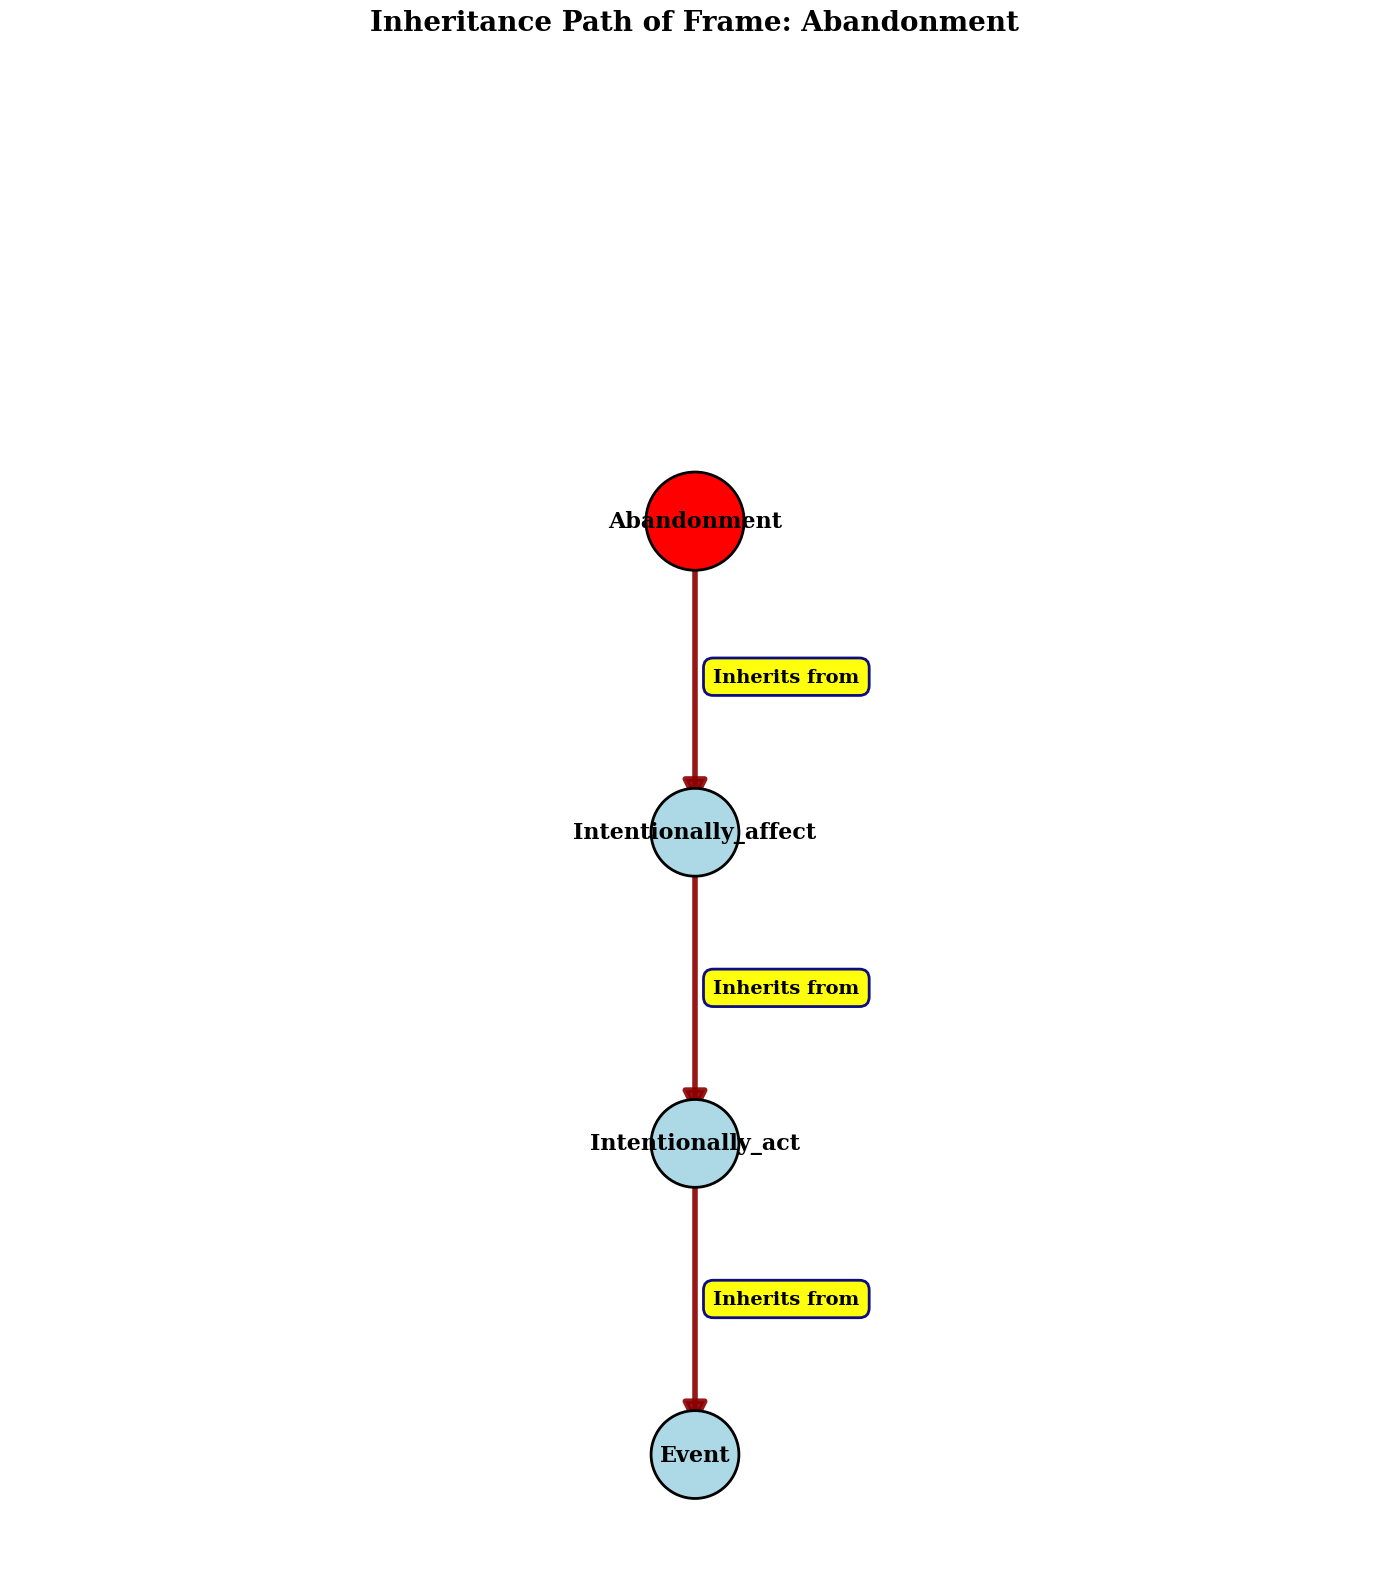

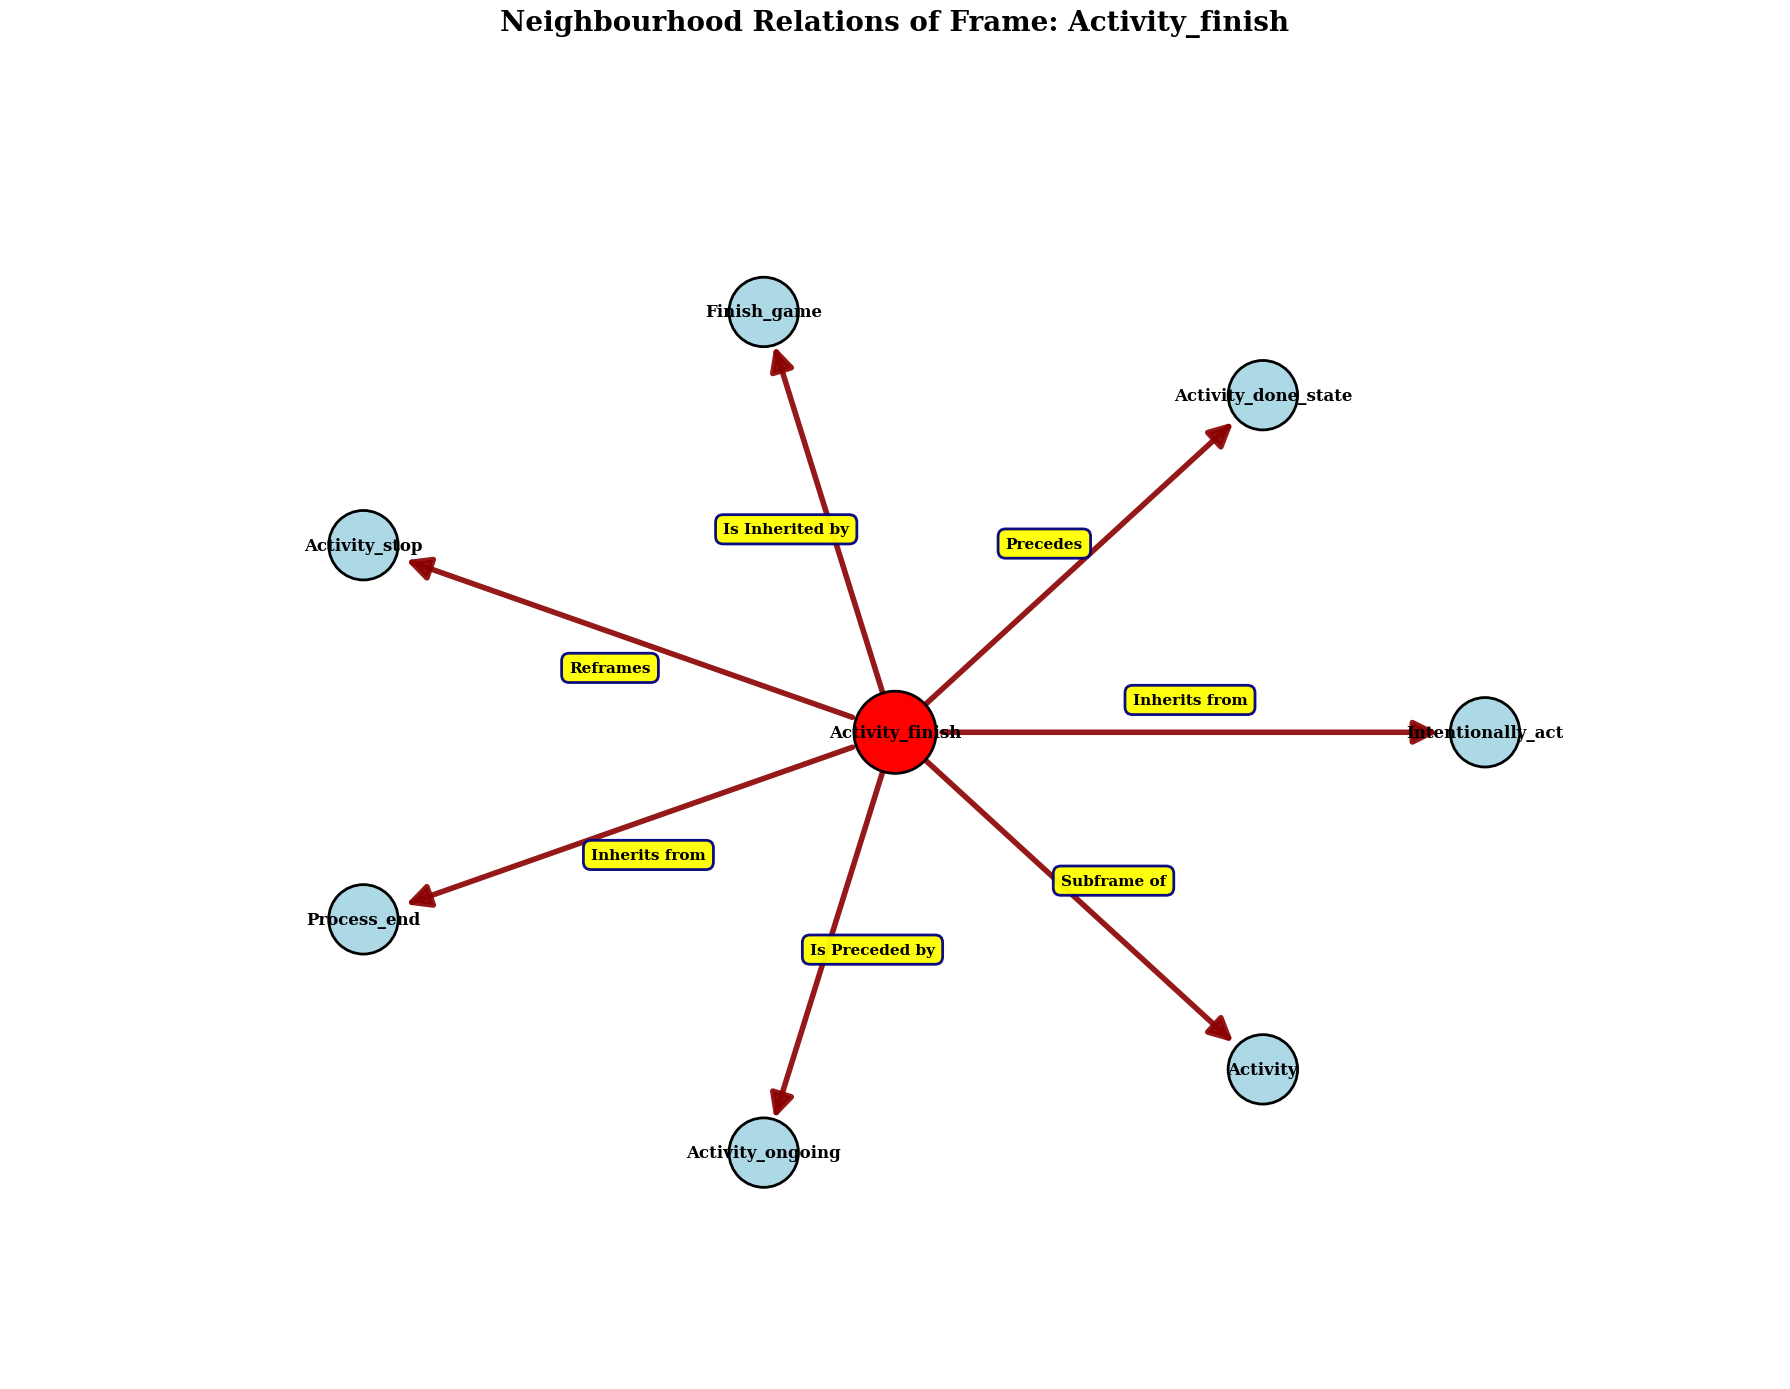

In [ ]:
# @title üîç Visualise FrameNet Data Structures

# Set font for better appearance (Colab compatible)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10

def visualize_frame_structure(frame_relations, target_frame, mode="neighbourhood", layout='spring', title=None, save_path=None):
    """
    Visualize frame semantic structure using extracted FrameNet data.
    """

    if target_frame not in frame_relations:
        print(f"[ERROR] Frame not found: {target_frame}")
        return

    if mode == "upward":
        if not title:
            title = f"Inheritance Path of Frame: {target_frame}"

        # Find inheritance path by following inheritance relations
        path = [target_frame]
        current = target_frame
        visited = {current}

        while True:
            parent_found = False
            relations = frame_relations.get(current, [])

            for neighbor, rel_type, direction, edge_label in relations:
                if neighbor in visited:
                    continue
                # Look for inheritance where current frame inherits from neighbor
                if rel_type == "Inheritance" and direction == "in":
                    path.insert(0, neighbor)  # Add parent at beginning
                    current = neighbor
                    visited.add(current)
                    parent_found = True
                    break

            if not parent_found:
                break

        # Create inheritance subgraph
        subgraph = nx.DiGraph()
        if len(path) == 1:
            subgraph.add_node(target_frame)
            print(f"[INFO] No inheritance path found for {target_frame}")
        else:
            for i in range(len(path) - 1):
                parent = path[i]
                child = path[i + 1]
                # Arrow from child to parent: child -> parent "Inherits from"
                subgraph.add_edge(child, parent, relation="Inherits from")

    elif mode == "neighbourhood":
        if not title:
            title = f"Neighbourhood Relations of Frame: {target_frame}"

        # Get all relations for the target frame
        relations = frame_relations.get(target_frame, [])

        # Collect all neighbor frames
        neighbors = set()
        for neighbor, rel_type, direction, edge_label in relations:
            neighbors.add(neighbor)

        # Create subgraph with all arrows FROM target frame
        subgraph = nx.DiGraph()
        subgraph.add_node(target_frame)
        subgraph.add_nodes_from(neighbors)

        # Add edges with labels from RELATION_LABELS
        for neighbor, rel_type, direction, edge_label in relations:
            # Get the appropriate label based on direction
            if rel_type in RELATION_LABELS:
                label_out, label_in = RELATION_LABELS[rel_type]
                if direction == "out":
                    label = label_out  # target gives the relation
                else:  # direction == "in"
                    label = label_in   # target receives the relation
            else:
                label = f"{rel_type} ({direction})"

            # All arrows point FROM target_frame TO neighbors
            subgraph.add_edge(target_frame, neighbor, relation=label)

    else:
        raise ValueError("mode must be 'neighbourhood' or 'upward'")

    if len(subgraph.nodes()) == 0:
        print(f"[ERROR] No nodes found for visualization")
        return

    # Layout calculation
    num_nodes = len(subgraph.nodes())

    if num_nodes == 1:
        pos = {list(subgraph.nodes())[0]: (0, 0)}
    elif mode == "upward":
        # Vertical hierarchical layout for inheritance
        nodes = list(subgraph.nodes())
        if subgraph.edges():
            try:
                ordered_nodes = list(nx.topological_sort(subgraph))
                pos = {}
                level_height = 5.0  # Large spacing
                for i, node in enumerate(ordered_nodes):
                    pos[node] = (0, (len(ordered_nodes) - i - 1) * level_height)
            except:
                pos = {node: (0, i * 5.0) for i, node in enumerate(reversed(nodes))}
        else:
            pos = {nodes[0]: (0, 0)}
    else:
        # Radial layout for neighbourhood - target in center
        pos = {}
        other_nodes = [n for n in subgraph.nodes() if n != target_frame]
        pos[target_frame] = (0, 0)

        if other_nodes:
            angle_step = 2 * np.pi / len(other_nodes)
            radius = 4.0
            for i, node in enumerate(other_nodes):
                angle = i * angle_step
                pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Create figure with large size
    if mode == "upward":
        fig_height = max(16, len(subgraph.nodes()) * 4)
        fig, ax = plt.subplots(1, 1, figsize=(14, fig_height))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Draw nodes
    node_colors = ["red" if n == target_frame else "lightblue" for n in subgraph.nodes()]
    if mode == "upward":
        node_sizes = [5000 if n == target_frame else 4000 for n in subgraph.nodes()]
    else:
        node_sizes = [3500 if n == target_frame else 2500 for n in subgraph.nodes()]

    nx.draw_networkx_nodes(subgraph, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)

    # Draw node labels
    label_font_size = 16 if mode == "upward" else 12
    nx.draw_networkx_labels(subgraph, pos,
                           font_size=label_font_size,
                           font_weight="bold",
                           font_family='DejaVu Serif',
                           ax=ax)

    # Draw edges with relation labels
    for u, v, data in subgraph.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)

        if length > 0:
            dx_norm = dx / length
            dy_norm = dy / length

            # Adjust arrow positions to avoid node overlap
            node_radius = 0.4 if mode == "upward" else 0.3
            start_x = x1 + dx_norm * node_radius
            start_y = y1 + dy_norm * node_radius
            end_x = x2 - dx_norm * node_radius
            end_y = y2 - dy_norm * node_radius

            # Draw thick, prominent arrow
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                   arrowstyle='-|>',
                                   mutation_scale=35,
                                   color='darkred',
                                   linewidth=4,
                                   alpha=0.9)
            ax.add_patch(arrow)

            # Add relation label
            relation = data.get("relation", "")
            if relation:
                # Position label at edge midpoint
                label_x = (start_x + end_x) / 2
                label_y = (start_y + end_y) / 2

                # Offset label perpendicular to edge for readability
                perp_offset = 0.4 if mode == "upward" else 0.3
                perp_x = -dy_norm * perp_offset
                perp_y = dx_norm * perp_offset

                label_font_size = 14 if mode == "upward" else 11
                ax.text(label_x + perp_x, label_y + perp_y, relation,
                       fontsize=label_font_size,
                       ha='center',
                       va='center',
                       weight='bold',
                       family='DejaVu Serif',
                       bbox=dict(boxstyle="round,pad=0.5",
                               facecolor="yellow",
                               alpha=0.95,
                               edgecolor="navy",
                               linewidth=2))

    ax.set_title(title, fontsize=20, fontweight='bold', family='DejaVu Serif', pad=40)
    ax.axis("off")

    # Set axis limits to ensure everything is visible
    if mode == "upward":
        ax.set_xlim(-3, 3)
        ax.set_ylim(-2, len(subgraph.nodes()) * 5 + 2)
    else:
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)

    plt.tight_layout()
    if save_path:
         plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


visualize_frame_structure(frame_relations, "Abandonment", mode="upward", save_path="abandonment_inheritance.png")
visualize_frame_structure(frame_relations, "Activity_finish", mode="neighbourhood", save_path="activity_finish_neighbourhood.png")

In [ ]:
# @title ÂÆö‰πâÊñá‰ª∂ÊèêÂèñ

# === 1. ‰øÆÂ§çÁâàÔºöÊèêÂèñÁ∫ØÂÆö‰πâÊñáÊú¨ÔºåÂøΩÁï• <ex> ‰æãÂè• ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

# === 2. ‰ΩøÁî® [CLS] ÂêëÈáèÁºñÁ†ÅÂÆö‰πâÊñáÊú¨ÔºàDistilBERTÁâàÔºâ ===
def encode_frame_definition(definition, tokenizer, model, device):
    inputs = tokenizer(
        definition,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding='max_length'
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state  # [B, T, H]
        cls_embedding = last_hidden[:, 0, :]     # Âèñ [CLS]
        return cls_embedding.squeeze(0).cpu()

# === 3. ‰∏ªÂáΩÊï∞ÔºöÁºñÁ†ÅÊâÄÊúâÂÆö‰πâ + ‰øùÂ≠ò ===
def encode_all_framenet_definitions(tokenizer, model, save_path, device):
    import pickle
    frame_definition_embeddings = {}
    skipped = []

    for frame in tqdm(fn.frames(), desc="Encoding FrameNet definitions"):
        name = frame["name"]
        raw_markup = ''.join(frame.get("definitionMarkup", []))
        definition = extract_pure_definition_from_markup(raw_markup)

        if definition == "[ParseError]" or not definition:
            skipped.append(name)
            continue

        try:
            emb = encode_frame_definition(definition, tokenizer, model, device)
            frame_definition_embeddings[name] = {
                "definition": definition,
                "embedding": emb.tolist()
            }
        except Exception as e:
            skipped.append(name)

    with open(save_path, "wb") as f:
        pickle.dump(frame_definition_embeddings, f)

    print(f"\nüì¶ ÊàêÂäü‰øùÂ≠ò {len(frame_definition_embeddings)} Êù°ÂÆö‰πâÂµåÂÖ•ÔºåË∑≥Ëøá {len(skipped)} Êù°ÈîôËØØÂÆö‰πâ„ÄÇ")
    return frame_definition_embeddings, skipped

# === 4. ‰ΩøÁî® distilbert-base-uncased ÁºñÁ†ÅÂô® ===


definition_model_name = "distilbert-base-uncased"
definition_tokenizer = AutoTokenizer.from_pretrained(definition_model_name)
definition_model = AutoModel.from_pretrained(definition_model_name).to(device)

# === 5. ÊâßË°åÂπ∂‰øùÂ≠ò ===
save_path = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
frame_definition_embeddings, skipped = encode_all_framenet_definitions(
    definition_tokenizer, definition_model, save_path, device
)

# === 6. ÊâìÂç∞ÂâçÂá†‰∏™ÁªìÊûúÊ£ÄÊü• ===
for i, (name, info) in enumerate(frame_definition_embeddings.items()):
    print(f"\n‚úÖ Frame {i+1}: {name}")
    print("üìù Definition:", info["definition"])
    print("üî¢ Embedding[:5]:", info["embedding"][:5])
    if i >= 4:
        break

# @title ÂÆö‰πâÊñá‰ª∂‰øùÂ≠ò
import pickle
save_path = "/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl"

with open(save_path, "wb") as f:
    pickle.dump(frame_definition_embeddings, f)

print(f"‚úÖ Â∑≤‰øùÂ≠òÂÆö‰πâÂµåÂÖ•Âà∞: {save_path}")

Encoding FrameNet definitions: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1221/1221 [00:06<00:00, 192.41it/s]



üì¶ ÊàêÂäü‰øùÂ≠ò 1221 Êù°ÂÆö‰πâÂµåÂÖ•ÔºåË∑≥Ëøá 0 Êù°ÈîôËØØÂÆö‰πâ„ÄÇ

‚úÖ Frame 1: Abandonment
üìù Definition: An Agent leaves behind a Theme effectively rendering it no longer within their control or of the normal security as one's property.
üî¢ Embedding[:5]: [-0.19139738380908966, -0.02490539290010929, -0.1134403645992279, -0.05611336603760719, 0.018953654915094376]

‚úÖ Frame 2: Abounding_with
üìù Definition: A Location is filled or covered with the Theme .  The Location is realized as the External Argument, and the Theme either as PP complement headed by with , in or of .

NB:  This frame does not include uses of adjectives like paved when they merely specify the Type of some location, as in "paved and unpaved roads".
üî¢ Embedding[:5]: [-0.3714313209056854, 0.04469132795929909, -0.04548976570367813, -0.21898649632930756, -0.3817424774169922]

‚úÖ Frame 3: Absorb_heat
üìù Definition: An Entity (generally food) is exposed to a Heat_source whose Temperature may also be specifi

üìä Cosine similarity stats (excluding self-match):
   Mean: 0.8911
   Std: 0.0338
   Min: 0.6452
   Max: 0.9988


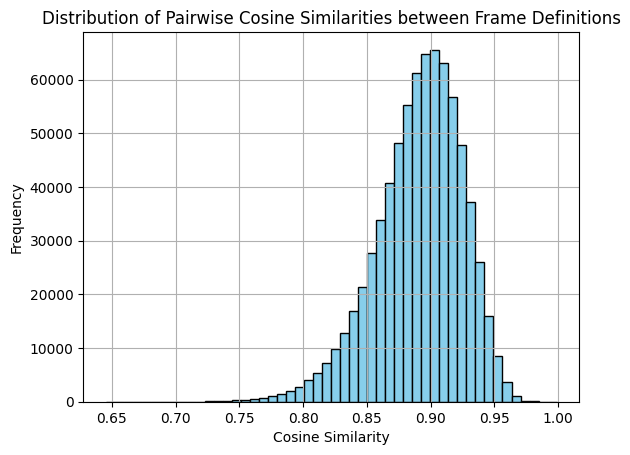

In [ ]:
# @title ÂÆö‰πâÁõ∏‰ººÂ∫¶

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === 1. Âä†ËΩΩÂÆö‰πâÂµåÂÖ• ===
with open("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl", "rb") as f:
    frame_def_embeddings = pickle.load(f)

# === 2. ÊèêÂèñÊâÄÊúâÂêëÈáè‰∏éÂêçÁß∞ ===
frame_names = list(frame_def_embeddings.keys())
embeddings = np.array([frame_def_embeddings[f]["embedding"] for f in frame_names])  # shape: [N, D]

# === 3. ËÆ°ÁÆó‰ΩôÂº¶Áõ∏‰ººÂ∫¶Áü©Èòµ ===
sim_matrix = cosine_similarity(embeddings)  # shape: [N, N]

# === 4. ÊèêÂèñÈùûÂØπËßíÂÖÉÁ¥†ÔºàÂç≥ÈùûËá™Ë∫´ÂåπÈÖçÔºâ ===
all_sims = sim_matrix[np.triu_indices(len(frame_names), k=1)]

# === 5. ÊâìÂç∞ÁªüËÆ°‰ø°ÊÅØ ===
mean_sim = np.mean(all_sims)
std_sim = np.std(all_sims)
min_sim = np.min(all_sims)
max_sim = np.max(all_sims)

print(f"üìä Cosine similarity stats (excluding self-match):")
print(f"   Mean: {mean_sim:.4f}")
print(f"   Std: {std_sim:.4f}")
print(f"   Min: {min_sim:.4f}")
print(f"   Max: {max_sim:.4f}")

# === 6. ÂèØËßÜÂåñÂàÜÂ∏É ===
plt.hist(all_sims, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Cosine Similarities between Frame Definitions")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# @title üì¶ Construct and Analyse Frame Graph

def build_frame_graph(frame_relations):

    """
    Build the semantic frame graph using all FrameNet relation types.

    Args:
        frame_relations (dict): Mapping from a frame to a list of
                                (related_frame, relation_type, direction, edge_label) tuples.

    Returns:
        frame_graph (MultiDiGraph): A directed multi-relation graph of frame relationships.
        relation_levels (dict): Mapping from frame name to structural level (based on all relation types).
    """
    import networkx as nx
    from collections import deque

    frame_graph = nx.MultiDiGraph()

    # Add nodes and edges
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, edge_label in relations:
            if direction == "out":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
            elif direction == "in":
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)
            elif direction == "undirected":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)

    # Identify root nodes (no incoming edges of any kind)
    roots = [node for node in frame_graph.nodes() if frame_graph.in_degree(node) == 0]

    # Compute relation levels from all roots, using all relation types
    relation_levels = {}
    for root in roots:
        queue = deque([(root, 0)])
        visited = set([root])

        while queue:
            node, level = queue.popleft()
            if node in relation_levels:
                relation_levels[node] = min(relation_levels[node], level)
            else:
                relation_levels[node] = level

            for _, child, data in frame_graph.out_edges(node, data=True):
                if child not in visited:
                    visited.add(child)
                    queue.append((child, level + 1))

    # Assign -1 to nodes not reachable from any root
    for node in frame_graph.nodes():
        if node not in relation_levels:
            relation_levels[node] = -1

    return frame_graph, relation_levels


# Load previously saved data
print("Loading FrameNet data...")
try:
    with open("framenet_data.pkl", 'rb') as f:
        data = pickle.load(f)

    frame_relations = data['frame_relations']
    frame_definitions = data['frame_definitions']
    df = data['dataframe']

    print(f"Successfully loaded data: {len(frame_relations)} frame relations, {len(frame_definitions)} frame definitions")
except FileNotFoundError:
    print("Data file not found. Please run the data extraction script first.")
    import sys
    sys.exit(1)

# Build the frame graph and compute structure levels
print("\nBuilding full semantic relation graph...")
frame_graph, relation_levels = build_frame_graph(frame_relations)

# Basic graph statistics
print(f"The graph contains {frame_graph.number_of_nodes()} nodes and {frame_graph.number_of_edges()} edges")

# Analyse structural levels (depths from root using all relations)
print("\nAnalysing frame structure levels (based on all relation types)...")
level_counts = defaultdict(int)
for frame, level in relation_levels.items():
    level_counts[level] += 1

print("Number of frames per level:")
for level in sorted(level_counts.keys()):
    if level >= 0:
        print(f"  Level {level}: {level_counts[level]} frames")
print(f"  Unreachable (level = -1): {level_counts[-1]} frames")

# Identify root nodes (frames with no incoming edges)
roots = [n for n in frame_graph.nodes() if frame_graph.in_degree(n) == 0]
if roots:
    print(f"\nFound {len(roots)} root nodes (frames with no incoming edges):")
    for i, root in enumerate(sorted(roots)[:10]):
        print(f"  {i+1}. {root}")
    if len(roots) > 10:
        print(f"  ...and {len(roots)-10} more")

    # Compute the largest reachable subgraph from any root
    max_subtree_size = 0
    max_root = None
    for root in roots:
        queue = [root]
        visited = set([root])
        while queue:
            node = queue.pop(0)
            for successor in frame_graph.successors(node):
                if successor not in visited:
                    visited.add(successor)
                    queue.append(successor)
        if len(visited) > max_subtree_size:
            max_subtree_size = len(visited)
            max_root = root

    print(f"\nRoot of the largest reachable subgraph: '{max_root}' with {max_subtree_size} frames")

# Extra: print statistics about frame relation distribution
print("\nAnalysing relation density per frame...")
outgoing_counts = defaultdict(int)
incoming_counts = defaultdict(int)
relation_type_counter = defaultdict(int)

for u, v, data in frame_graph.edges(data=True):
    outgoing_counts[u] += 1
    incoming_counts[v] += 1
    relation_type_counter[data['relation']] += 1

total_frames = frame_graph.number_of_nodes()
no_outgoing = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0]
no_incoming = [f for f in frame_graph.nodes() if incoming_counts[f] == 0]
no_edges = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0 and incoming_counts[f] == 0]

print(f"Frames with no outgoing relations: {len(no_outgoing)}")
print(f"Frames with no incoming relations: {len(no_incoming)}")
print(f"Completely isolated frames (no relations at all): {len(no_edges)}")

# Print most relationally dense frames
dense_out = sorted(outgoing_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 frames by number of outgoing relations:")
for f, count in dense_out:
    print(f"  {f}: {count} outgoing")

# Print relation type frequency
print("\nRelation type distribution:")
for rel, count in sorted(relation_type_counter.items(), key=lambda x: -x[1]):
    print(f"  {rel}: {count} edges")

# Save graph and relation-level info
frame_graph_data = {
    'graph': frame_graph,
    'levels': relation_levels,
    'level_stats': dict(level_counts),
    'roots': roots
}
with open('frame_graph_analysis.pkl', 'wb') as f:
    pickle.dump(frame_graph_data, f)
print("\nGraph structure data saved to frame_graph_analysis.pkl")

# Analyse graph connectivity
print("\nAnalysing graph connectivity...")
connected_components = list(nx.weakly_connected_components(frame_graph))
largest_cc = max(connected_components, key=len)
print(f"Largest weakly connected component contains {len(largest_cc)} nodes "
      f"({len(largest_cc)/frame_graph.number_of_nodes():.1%} of total)")

# Compute graph diameter of largest component (undirected)
print("\nComputing diameter of largest connected component...")
try:
    largest_cc_subgraph = frame_graph.subgraph(largest_cc)
    diameter = nx.diameter(nx.Graph(largest_cc_subgraph))
    print(f"Diameter of the largest component: {diameter}")
except Exception as e:
    print(f"Error computing diameter: {e}")

print("\nFull frame graph analysis complete!")
